In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pdb # use 'pdb.set_trace()' where you want to see
import time
from torch.optim.lr_scheduler import LambdaLR

torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
torch.cuda.manual_seed_all(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(1234)

start_time_total = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class SIRENLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first = False, w0=30.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.is_first = is_first
        self.w0 = w0

        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.w0,
                                             np.sqrt(6 / self.in_features) / self.w0)


    def forward(self, x):
        y = self.linear(x)
        y = torch.sin(self.w0 * y)
        return y

In [3]:
class Net(nn.Module):
    def __init__(self,  n_input, n_layer, n_nodes):
        super().__init__()

        num_layers = n_layer
        n_output = 1
        
        first_omega_0=10.0
        hidden_omega_0=20.0

        self.in_features = n_nodes
        self.out_features = n_nodes

        in_features = n_input
        out_features = n_output
        hidden_features = n_nodes

        layers = []
        layers.append(SIRENLayer(in_features, hidden_features,
                                is_first=True, w0 =first_omega_0))

        for _ in range(num_layers - 2):
            layers.append(SIRENLayer(hidden_features, hidden_features,
                                is_first=False, w0 =hidden_omega_0))

        final_linear = nn.Linear(hidden_features, out_features)

        with torch.no_grad():
            final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

        layers.append(final_linear)

        self.layers = nn.Sequential(*layers)


    def forward(self, x,y):

        y = torch.cat([x,y],axis=1)

        y = self.layers(y)

        return y

In [4]:
class NetTO(nn.Module):
    def __init__(self, rho_n_input, rho_n_layer,rho_n_nodes):
        super().__init__()

        n_input = rho_n_input
        n_layer = rho_n_layer
        n_output = 1
        n_nodes = rho_n_nodes

        self.Input = nn.Linear(n_input,n_nodes)
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.zeros_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.constant_(self.Output.weight, 0.0)
        nn.init.constant_(self.Output.bias, 0.0)

        self.bn = nn.BatchNorm1d(num_features=n_nodes)

        self.act = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.act(self.bn(self.Input(x)))
        y = self.Output(y)
        output = self.sigmoid(y)
        return output

In [5]:
def FourierFeatures(x,y,B):
    input = torch.cat((x,y), axis = 1)

    c = torch.cos(2*np.pi*torch.matmul(input,B))
    s = torch.sin(2*np.pi*torch.matmul(input,B))

    output = torch.cat((c,s), axis = 1)

    return output


In [6]:
def pinnLoss(x,y):

    u = 0 + x * net_u(x,y)
    v = 0 + x * net_v(x,y)

    FFM = FourierFeatures(x,y,B)

    rho = net_rho(FFM)

    E = Emin + (Emat - Emin)*rho**p

    lmbd = E * nu/((1+nu)*(1-2*nu))
    mu = E/(2*(1+nu))

    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]

    exx = u_x
    eyy = v_y
    exy = 1/2*(u_y + v_x)

    sxx = (lmbd+2*mu)*exx + lmbd*eyy
    syy = (lmbd+2*mu)*eyy + lmbd*exx
    sxy = 2*mu*exy

    res = 1/2*(exx*sxx+eyy*syy+2*exy*sxy)

    Eint = torch.sum(res) * (area / x.shape[0])
    Vol = torch.sum(rho) * (area / x.shape[0]) /area
    
    return Eint, Vol, rho

In [7]:
def dataPoints(x0,y0,x1,y1,nx,ny):

    x = np.linspace(x0,x1,num = nx)
    y = np.linspace(y0,y1,num = ny)

    X, Y = np.meshgrid(x,y)

    xt = X.reshape(-1,1)
    yt = Y.reshape(-1,1)

    return xt, yt

In [8]:
def boundaryPointsCantileverWithRightBottomLoad(x,y,x0,y0,x1,y1):

    Lx = x1 - x0
    Ly = y1 - y0

    # x = 0
    idxLeft = (x==x0)

    # x = Lx
    idxRight= (x==x1)


    # y = 0
    idxBotFree = (y==y0) & (x<(x1-(Lx)*loadratio))
    idxBotLoad = (y==y0) & (x>=(x1-(Lx)*loadratio))

    # y = Ly
    idxTop = (y==y1)

    idxInner = (x>x0)&(x<x1)&(y>y0)&(y<y1)

    return idxLeft, idxBotFree, idxBotLoad, idxTop, idxRight, idxInner

In [9]:
def drawplot(mse,ep):
    nnx = 200
    nny = 100

    x_plt = np.linspace(x0,x1,nnx)
    y_plt = np.linspace(y0,y1,nny)

    ms_x, ms_y = np.meshgrid(x_plt,y_plt)

    X = ms_x.reshape(-1,1)
    Y = ms_y.reshape(-1,1)

    pt_x = torch.tensor(X, requires_grad = True , dtype=torch.float32).to(device)
    pt_y = torch.tensor(Y, requires_grad = True , dtype=torch.float32).to(device)
    uPred = 0 + pt_x * net_u(pt_x,pt_y)
    vPred = 0 + pt_x * net_v(pt_x,pt_y)

    FFM = FourierFeatures(pt_x, pt_y, B)

    rho = net_rho(FFM)

    E = Emin + (Emat - Emin)*rho**p

    lmbd = E * nu/((1+nu)*(1-2*nu))
    mu = E/(2*(1+nu))

    u_x = torch.autograd.grad(uPred.sum(), pt_x, create_graph=True)[0]
    u_y = torch.autograd.grad(uPred.sum(), pt_y, create_graph=True)[0]
    v_x = torch.autograd.grad(vPred.sum(), pt_x, create_graph=True)[0]
    v_y = torch.autograd.grad(vPred.sum(), pt_y, create_graph=True)[0]

    exx = u_x
    eyy = v_y
    exy = 1/2*(u_y + v_x)

    sxx = (lmbd+2*mu)*exx + lmbd*eyy
    syy = (lmbd+2*mu)*eyy + lmbd*exx
    sxy = 2*mu*exy

    res = 1/2*(exx*sxx+eyy*syy+2*exy*sxy)

    Eint = torch.sum(res) * (area / xi.shape[0])
    Vol = torch.sum(rho) * (area / xi.shape[0]) / area

    xLoad = xpBL.view(-1,1)
    yLoad = ypBL.view(-1,1)
    uLoad = 0 + xLoad * net_u(xLoad,yLoad)
    vLoad = 0 + xLoad * net_v(xLoad,yLoad)

    # External energy
    Eext = torch.sum(f*vLoad) * ( lineload/ xLoad.shape[0])

    Et = -1*(Eint - Eext)

    Vc = (1-Vol/Vf)**2

    # Loss
    loss = Et

    sens = torch.autograd.grad(loss, rho, create_graph=True)[0]
    sensV = torch.autograd.grad(Vc, rho, create_graph=True)[0]

    ms_sens = sens.data.cpu().numpy().reshape(ms_x.shape)
    ms_sensV = sensV.data.cpu().numpy().reshape(ms_x.shape)

    ms_u = uPred.data.cpu().numpy().reshape(ms_x.shape)
    ms_v = vPred.data.cpu().numpy().reshape(ms_x.shape)
    ms_sxx = sxx.data.cpu().numpy().reshape(ms_x.shape)
    ms_syy = syy.data.cpu().numpy().reshape(ms_x.shape)
    ms_sxy = sxy.data.cpu().numpy().reshape(ms_x.shape)
    ms_rho = net_rho(FFM).data.cpu().numpy().reshape(ms_x.shape)

    len_x , len_y = 15,5
    ls = 20

    fig_sens = plt.figure(figsize=(len_x,len_y))
    plt.pcolor(ms_x,ms_y,ms_sens, cmap='jet')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.title(f"epoch: {ep}, prediction sens loss")
    plt.show()

    fig_sensV = plt.figure(figsize=(len_x,len_y))
    plt.pcolor(ms_x,ms_y,ms_sensV, cmap='jet', edgecolors='none')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.title(f"epoch: {ep}, prediction sens V")
    plt.show()

    fig_u = plt.figure(figsize=(len_x,len_y))
    plt.pcolor(ms_x,ms_y,ms_u, cmap='jet', edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=ls)
    plt.title(f"epoch: {ep}, prediction u")
    plt.show()

    fig_v = plt.figure(figsize=(len_x,len_y))
    plt.pcolor(ms_x,ms_y,ms_v, cmap='jet', edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=ls)
    plt.title(f"epoch: {ep}, prediction v")
    plt.show()


    fig_sxx = plt.figure(figsize=(len_x,len_y))
    plt.pcolor(ms_x,ms_y,ms_sxx, cmap='jet', edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=ls)
    plt.title(f"epoch: {ep}, prediction sxx")
    plt.show()

    fig_syy = plt.figure(figsize=(len_x,len_y))
    plt.pcolor(ms_x,ms_y,ms_syy, cmap='jet', edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=ls)
    plt.title(f"epoch: {ep}, prediction syy")
    plt.show()

    fig_sxy = plt.figure(figsize=(len_x,len_y))
    plt.pcolor(ms_x,ms_y,ms_sxy, cmap='jet', edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=ls)
    plt.title(f"epoch: {ep}, prediction sxy")
    plt.show()

    ######## rho ##########
    fig_rho = plt.figure(figsize=(len_x,len_y))
    ax_rho_1 = fig_rho.add_axes([0, 0, 2/3, 1]) #(left, bottom, width, height)
    ax_rho_2 = fig_rho.add_axes([0.7, 0, 0.02, 1])
    c_rho = ax_rho_1.pcolor(ms_x,ms_y,ms_rho, cmap='gray_r',vmin=0,vmax=1, edgecolors='none')
    ax_rho_1.set_xticks([])
    ax_rho_1.set_xticklabels([])
    ax_rho_1.set_yticks([])
    ax_rho_1.set_yticklabels([])
    ax_rho_1.axis('off')
    
    cbar = plt.colorbar(c_rho, cax = ax_rho_2)
    cbar.ax.tick_params(labelsize=ls)
    #ax_rho_1.set_title(f"epoch: {ep}, prediction rho")
    
    plt.show()

    # Convergence
    fig_epoch, ax_epoch = plt.subplots(figsize=(10,7))
    lw = 3
    ax_epoch.plot(history_Et[:,0], history_Et[:,1], label = 'abs(P.E.)', linestyle = '-', linewidth=lw, color='blue')
    ax_epoch.plot(history_Eint[:,0], history_Eint[:,1], label = 'Int. E.', linestyle = '--', linewidth=lw, color='green')
    ax_epoch.plot(history_Eext[:,0], history_Eext[:,1], label = 'Ext. E.', linestyle = '-.', linewidth=lw, color='purple')

    ax_epoch.set_xlabel('Epoch',fontsize=ls)
    ax_epoch.set_ylabel('Energy [N\u00B7m]',fontsize=ls)    
    ax_epoch.tick_params(axis='both', labelsize=ls)
    ax_epoch.legend(fontsize = ls)
    #ax_epoch.set_title('Loss history',fontsize=ls)

    # Convergence
    fig_obj = plt.figure(figsize=(10,7))

    plt.plot(history_Eext[:,0],history_Eext[:,1], linestyle = '-', linewidth=lw, color='black')
    plt.xlabel('Epoch',fontsize=ls)
    plt.ylabel('Compliance [N\u00B7m]',fontsize=ls)
    plt.xticks(fontsize = ls)
    plt.yticks(fontsize = ls)
    #plt.title('Compliance',fontsize=ls)

    fig_vol = plt.figure(figsize=(10,7))

    plt.plot(history_Vol[:,0],history_Vol[:,1], linestyle = '-', linewidth=lw, color='black')
    plt.xlabel('Epoch',fontsize=ls)
    plt.ylabel('Volume fraction',fontsize=ls)
    plt.ylim(0,1)    
    plt.xticks(fontsize = ls)
    plt.yticks(fontsize = ls)
    #plt.title('Volume fraction',fontsize=ls)

    #
    fig_u.savefig('u_'+ '_epoch_' + str(ep)+'.png')
    fig_v.savefig('v_' + '_epoch_' + str(ep)+'.png' )
    fig_rho.savefig('rho_' + '_epoch_' + str(ep)+'.png' )
    #fig_rho_p.savefig('rho_physical_'+'i_' + str(i) + '_epoch_' + str(ep)+'.png' )
    #fig_sxx.savefig('sxx_'+'i_' + str(i) + '_epoch_' + str(ep)+'.png')
    #fig_syy.savefig('syy_'+'i_' + str(i) + '_epoch_' + str(ep)+'.png')
    #fig_sxy.savefig('sxy_'+'i_' + str(i) + '_epoch_' + str(ep)+'.png')
    fig_epoch.savefig('Loss Plot_' + '_epoch_' + str(ep)+'.png')
    fig_obj.savefig('Loss obj_' + '_epoch_' + str(ep)+'.png')
    fig_vol.savefig('Loss vol_' + '_epoch_' + str(ep)+'.png')
    fig_sens.savefig('Sens Plot_' + '_epoch_' + str(ep)+'.png')
    #fig_sensV.savefig('Sens V Plot_'+'i_' + str(i) + '_epoch_' + str(ep)+'.png')

    return 0

In [10]:
"""Main code"""

dim = 2
x0 = 0
y0 = 0
x1 = 2 # [m]
y1 = 1 # [m]
f = -1 # load [N/m2]
Vf = 0.5

# Collocation points
nx = 200      # Points for x-axis
ny = 100      # Points for y-axis

area = x1*y1 # [m2]
loadratio = 0.02 # 1% of (x1-x0)
lineload = loadratio * (x1-x0)
nfourier = 128

# Material property
nu = 0.3
Emat = 1
Emin = 1e-9
p = 3

# FFM
std_dev = 2  # Standard deviation
B = np.random.normal(0, std_dev, size=(dim, nfourier))
B = torch.tensor(B, dtype = torch.float32).to(device)


In [11]:
xnp, ynp = dataPoints(x0,y0,x1,y1,nx,ny)

# Cantilever With Right Bottom Load
idxLeft, idxBotFree, idxBotLoad, idxTop, idxRight, idxInner = boundaryPointsCantileverWithRightBottomLoad(xnp,ynp,x0,y0,x1,y1)

u_n_input = dim
u_n_layer = 5
u_n_nodes = 32

rho_n_input = 2*nfourier # 2 : c s
rho_n_layer = 1
rho_n_nodes = 32

net_u = Net(u_n_input, u_n_layer, u_n_nodes).to(device)
net_v = Net(u_n_input, u_n_layer, u_n_nodes).to(device)
net_rho = NetTO(rho_n_input, rho_n_layer, rho_n_nodes).to(device)

mse = torch.nn.MSELoss() # Mean squared error

history_totalloss = np.zeros((0,2))
history_Et = np.zeros((0,2))
history_Eint = np.zeros((0,2))
history_Eext = np.zeros((0,2))
history_Vol = np.zeros((0,2))
history_Vc = np.zeros((0,2))
history_p = np.zeros((0,2))

x = torch.tensor(xnp, dtype = torch.float32, requires_grad = True).to(device)
y = torch.tensor(ynp, dtype = torch.float32, requires_grad = True).to(device)

cidx = np.any(np.array([idxInner,idxLeft,idxTop,idxRight,idxBotFree]), axis=0)  


xi = x[cidx].view(-1,1)
yi = y[cidx].view(-1,1)

# Cantilever With Right Bottom Load
xpL = x[idxLeft].view(-1,1)
ypL = y[idxLeft].view(-1,1)
xpBL = x[idxBotLoad]
ypBL = y[idxBotLoad]
xpT = x[idxTop].view(-1,1)
ypT = y[idxTop].view(-1,1)
xpR = x[idxRight].view(-1,1)
ypR = y[idxRight].view(-1,1)

xint_line = xpBL.view(1,-1).squeeze()
yint_line = ypBL.view(1,-1).squeeze()


In [12]:
print(xi.shape)

torch.Size([19997, 1])


In [13]:
lrU = 0.0001
lrRho =0.01

optimizerU = torch.optim.Adam( list(net_u.parameters()) + list(net_v.parameters()), amsgrad =True, lr = lrU,  maximize = True)
optimizerRho = torch.optim.Adam( list(net_rho.parameters()), amsgrad =True, lr = lrRho)

fig_epoch = 1000
num_epochs_total = 15000
num_epochs_initial_disp = 1000
change = 1

start_time = time.time()

Epoch:    1/15000, Cost: -0.030579
Et: -3.0579e-02, Eint: 2.0421e-02, Eext and Obj: -1.0158e-02, Vol: 5.0000e-01, Vc: 0.0000e+00
Epoch 1, Training time: 0.13 seconds
change: 1.0000e+00
Epoch:  250/15000, Cost: 0.071568
Et: 7.1568e-02, Eint: 6.8646e-03, Eext and Obj: 7.8432e-02, Vol: 5.0000e-01, Vc: 0.0000e+00
Epoch 250, Training time: 2.90 seconds
change: 1.0000e+00


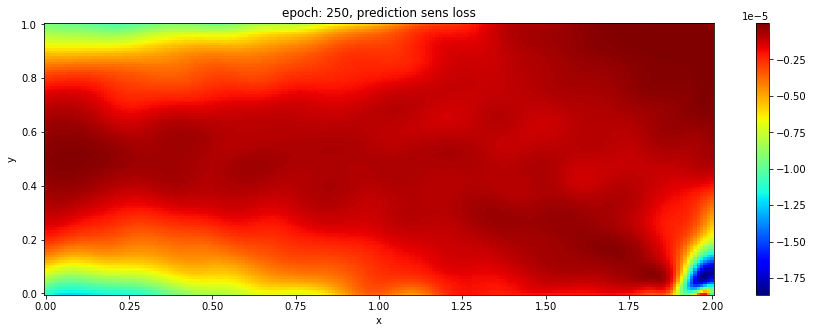

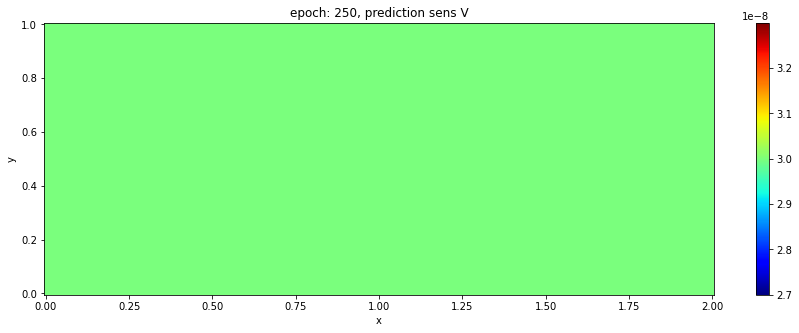

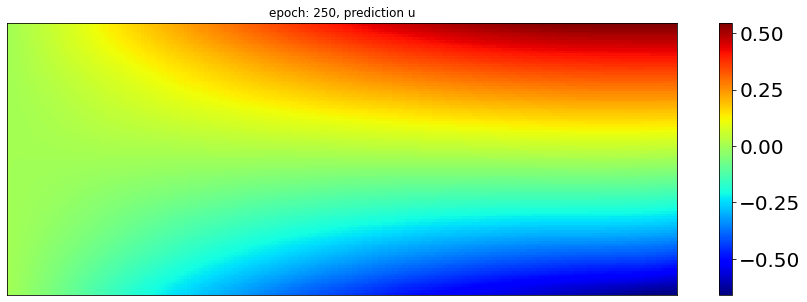

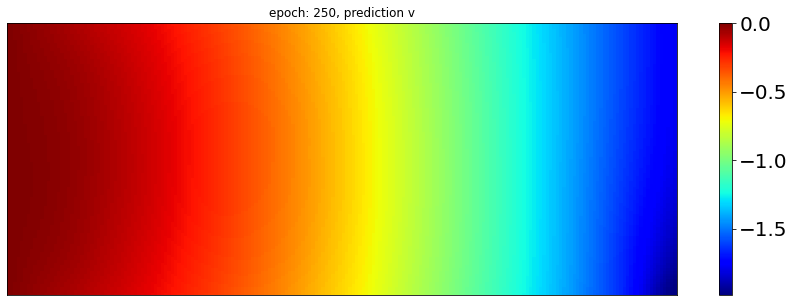

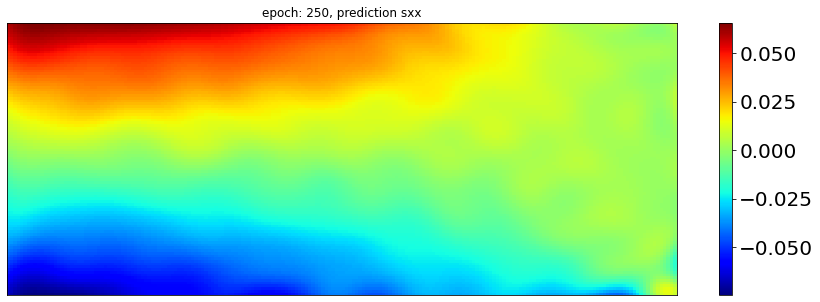

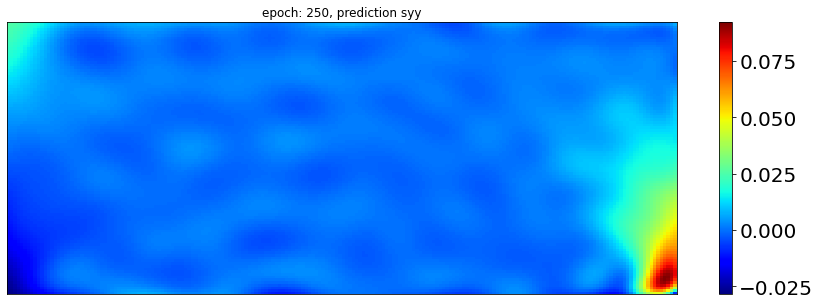

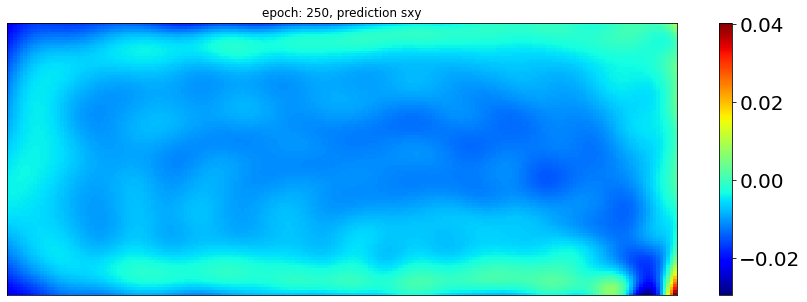

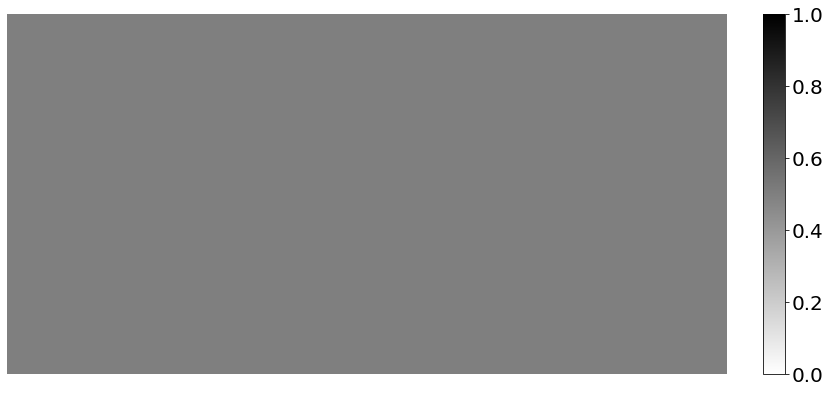

Epoch:  500/15000, Cost: 0.118243
Et: 1.1824e-01, Eint: 2.0911e-02, Eext and Obj: 1.3915e-01, Vol: 5.0000e-01, Vc: 0.0000e+00
Epoch 500, Training time: 7.43 seconds
change: 1.0000e+00


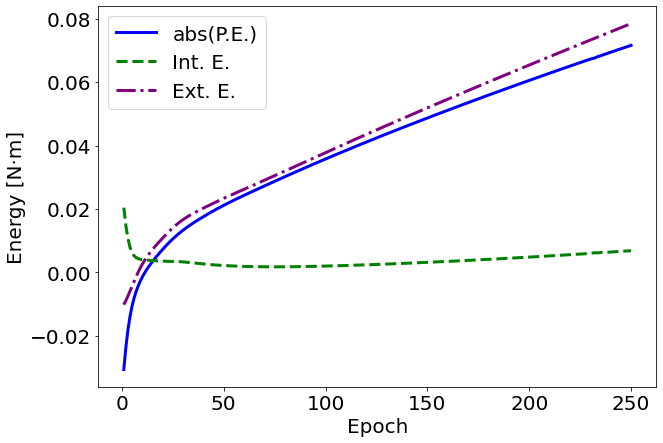

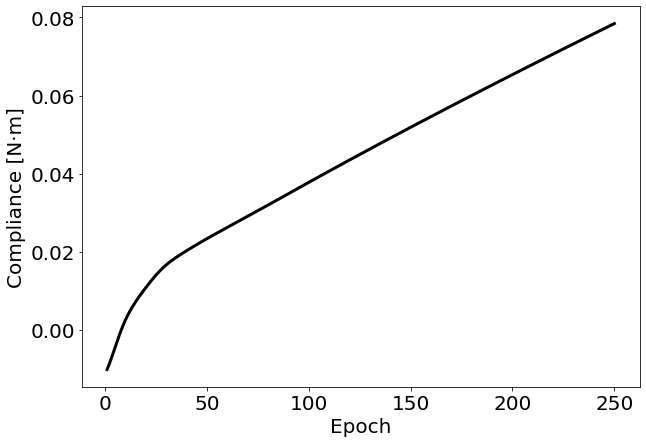

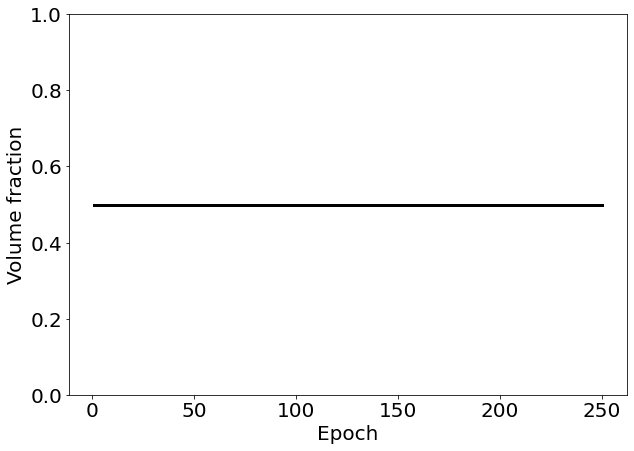

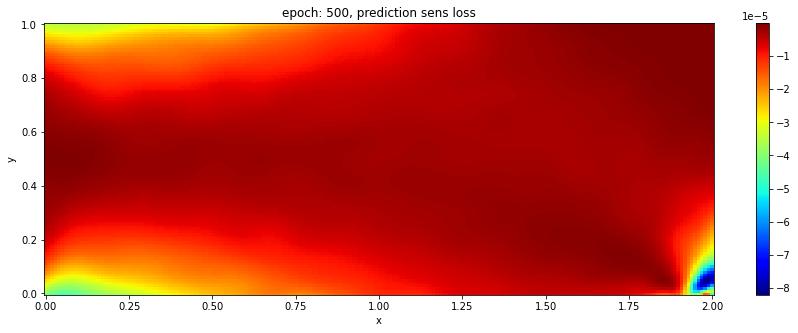

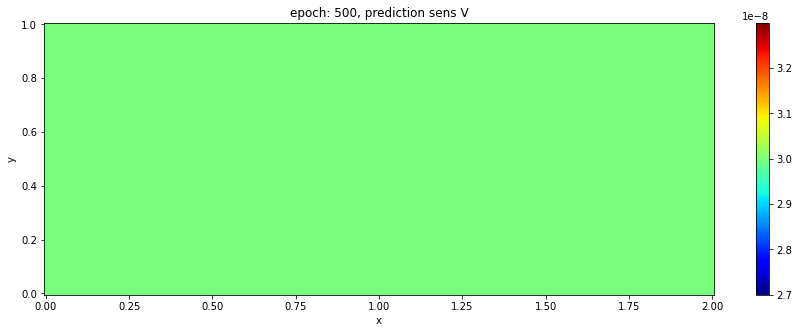

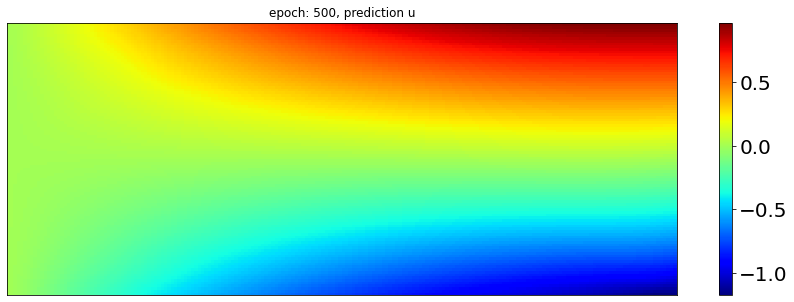

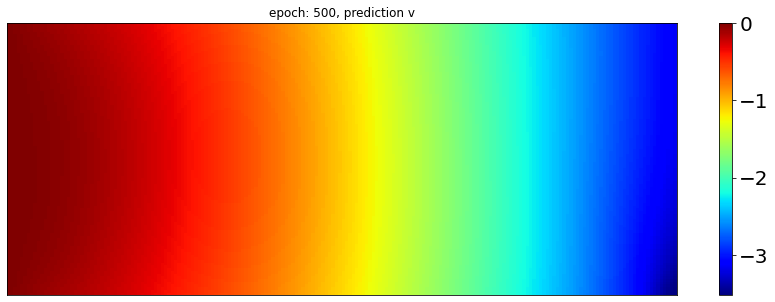

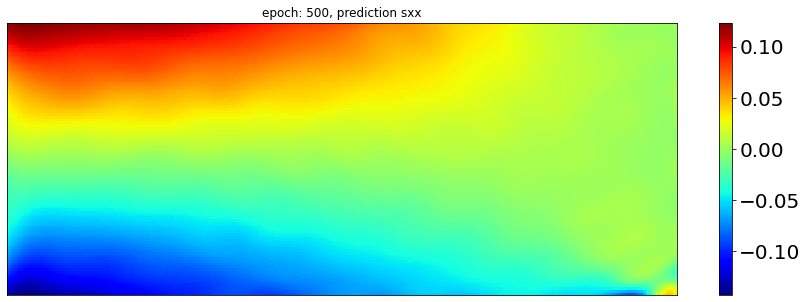

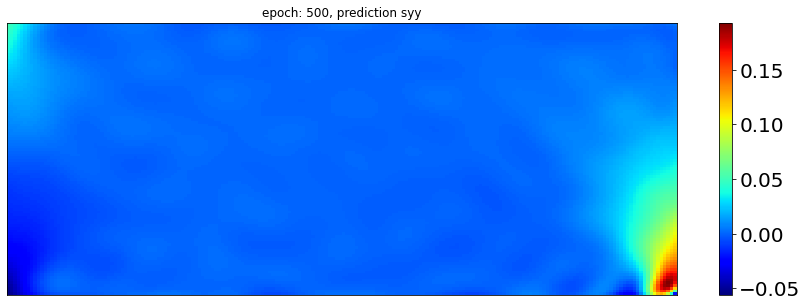

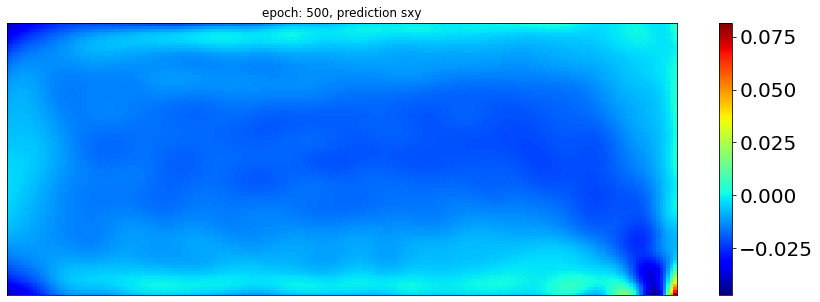

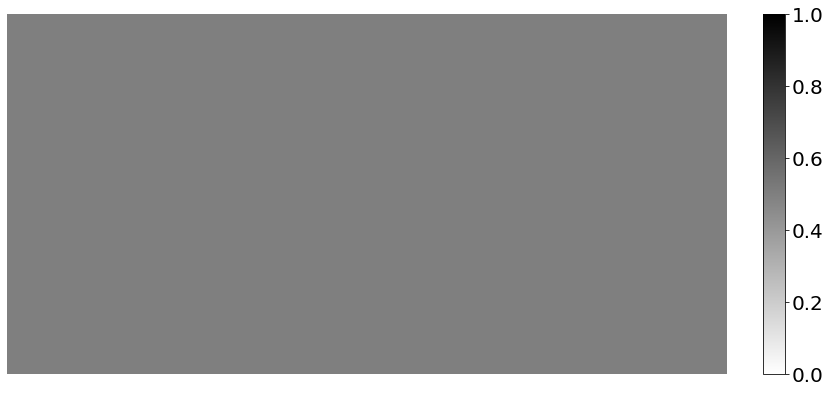

Epoch:  750/15000, Cost: 0.153621
Et: 1.5362e-01, Eint: 4.0166e-02, Eext and Obj: 1.9379e-01, Vol: 5.0000e-01, Vc: 0.0000e+00
Epoch 750, Training time: 12.29 seconds
change: 1.0000e+00


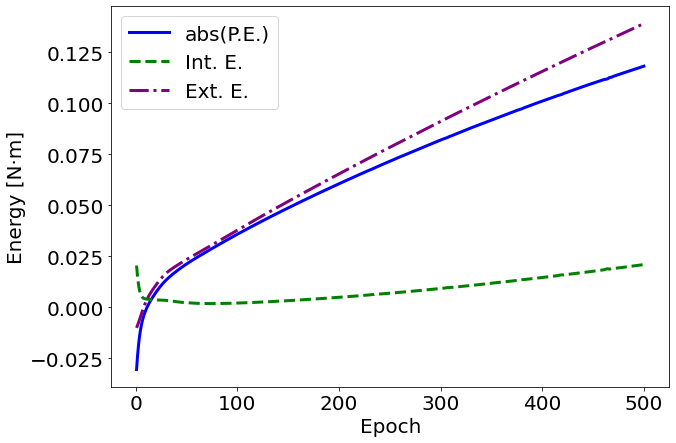

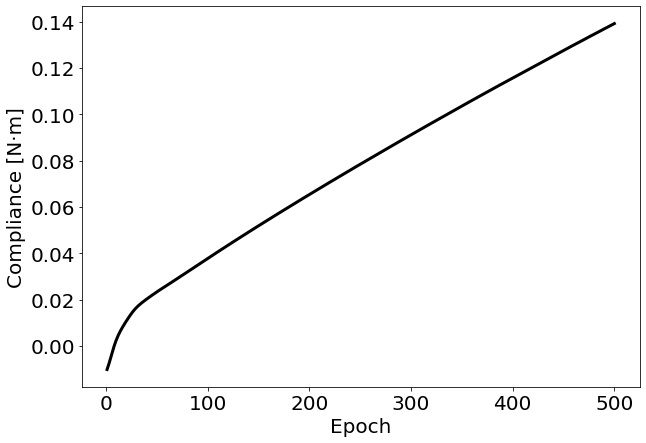

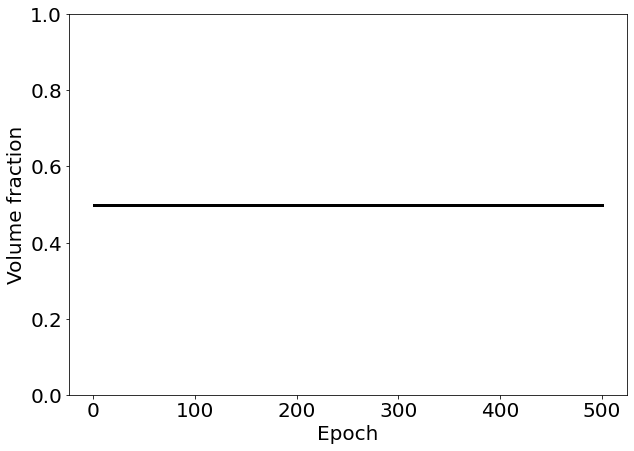

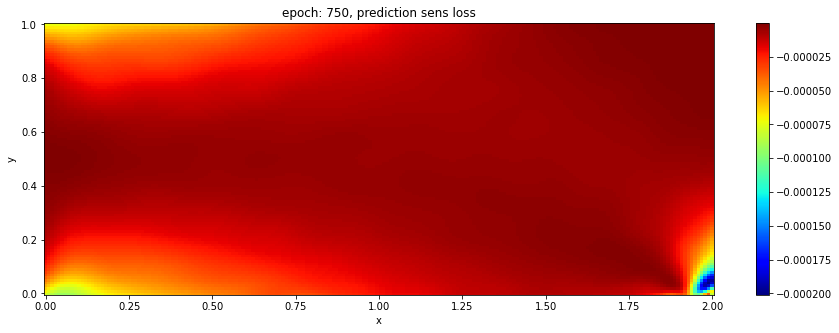

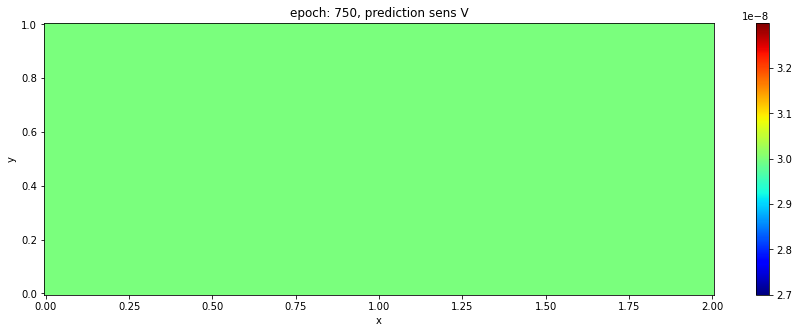

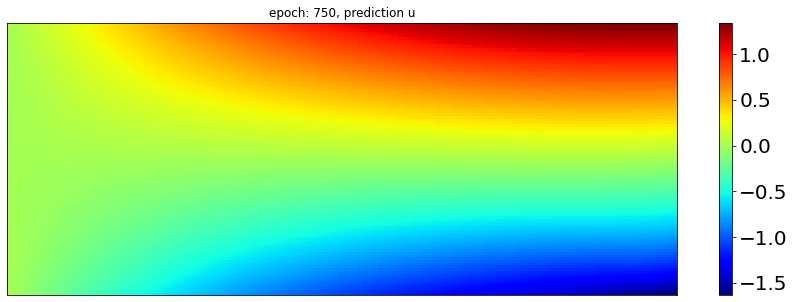

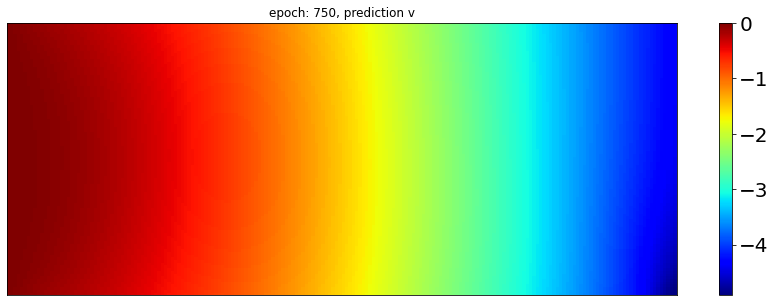

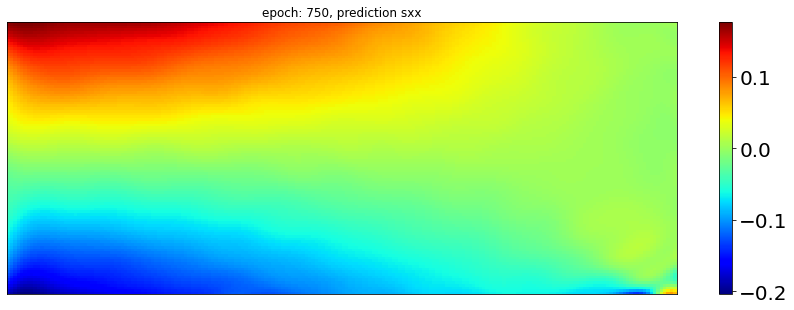

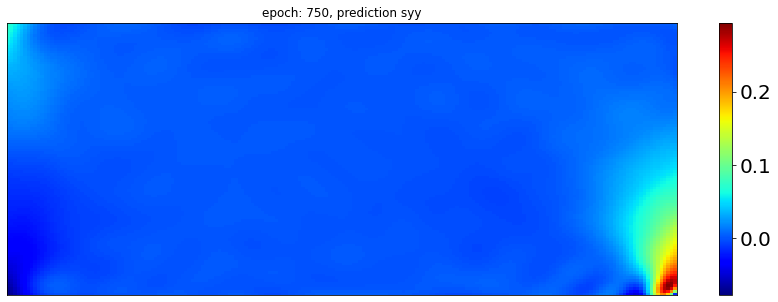

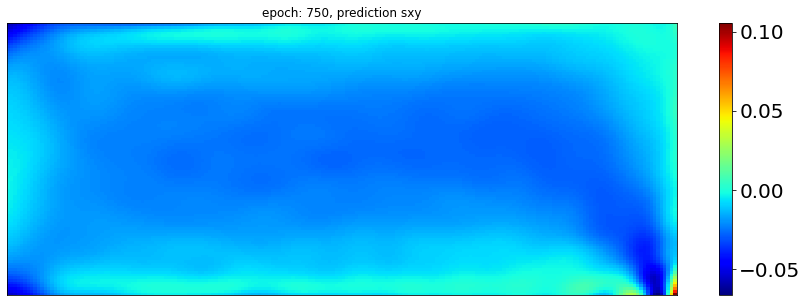

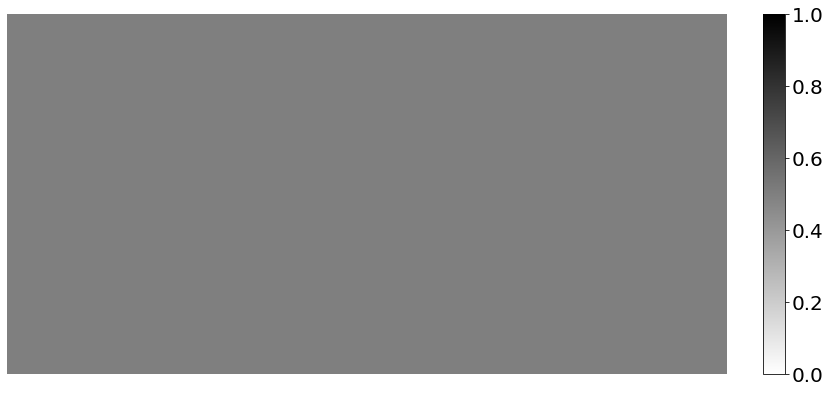

**********c0 : 0.180199**********
Epoch: 1000/15000, Cost: 0.180199
Et: 1.8020e-01, Eint: 6.2749e-02, Eext and Obj: 2.4295e-01, Vol: 5.0000e-01, Vc: 0.0000e+00
Epoch 1000, Training time: 17.15 seconds
change: 1.0000e+00


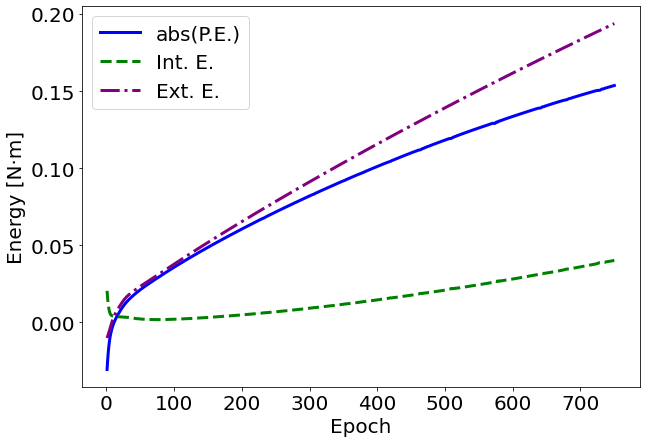

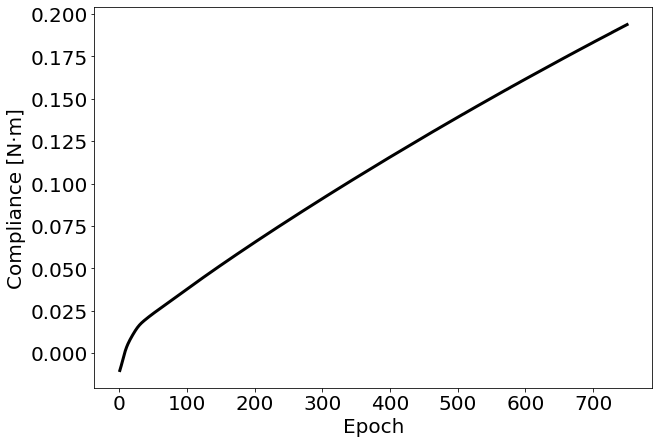

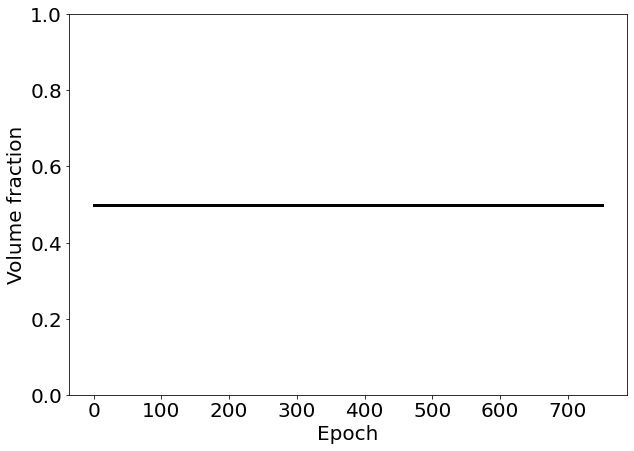

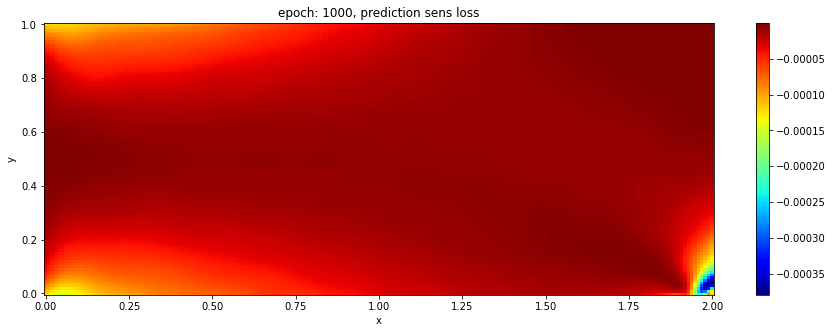

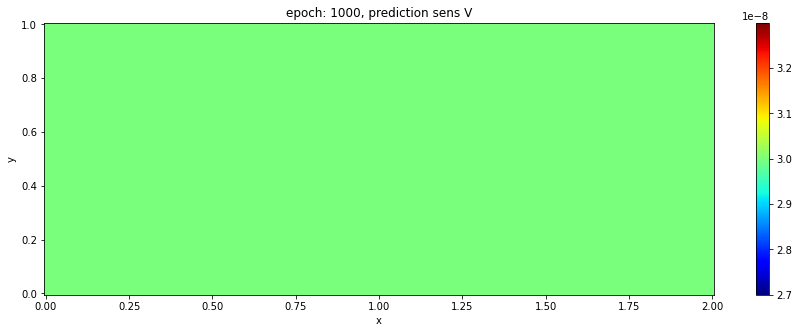

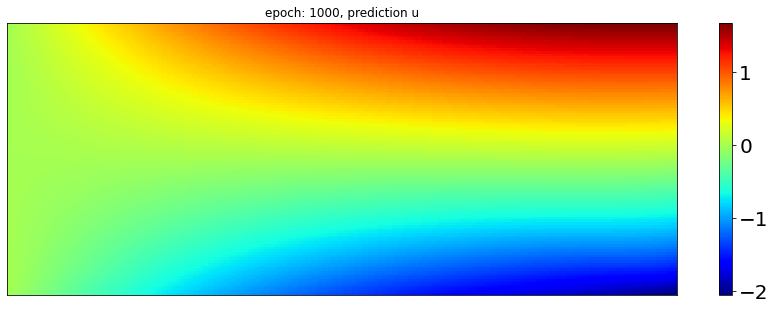

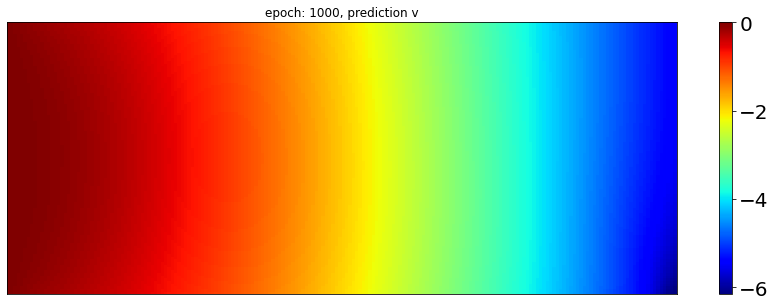

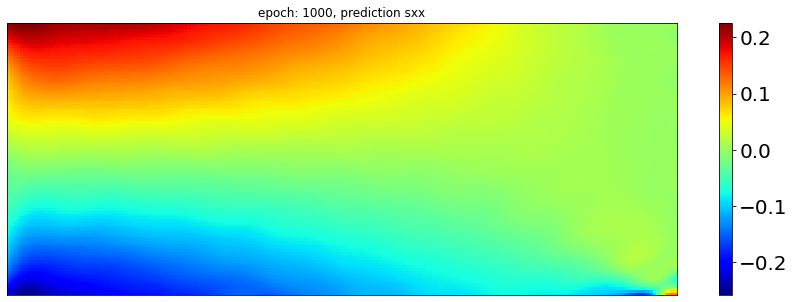

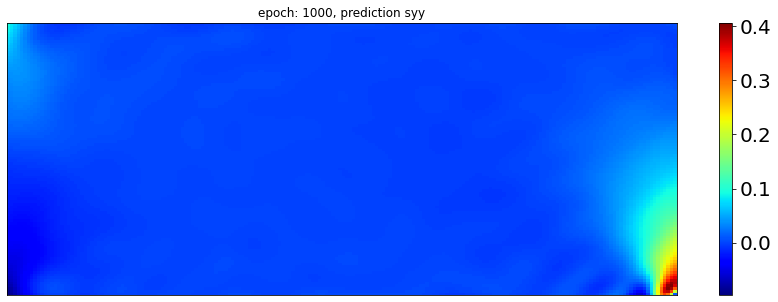

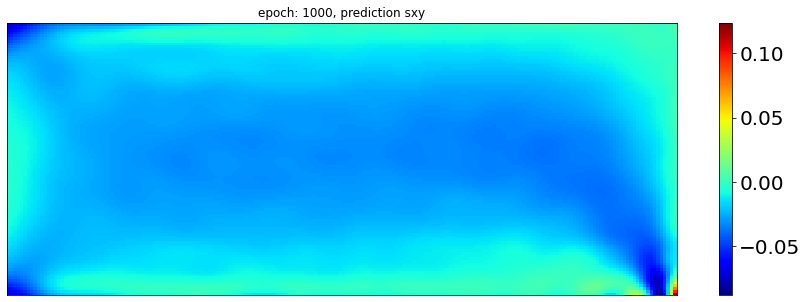

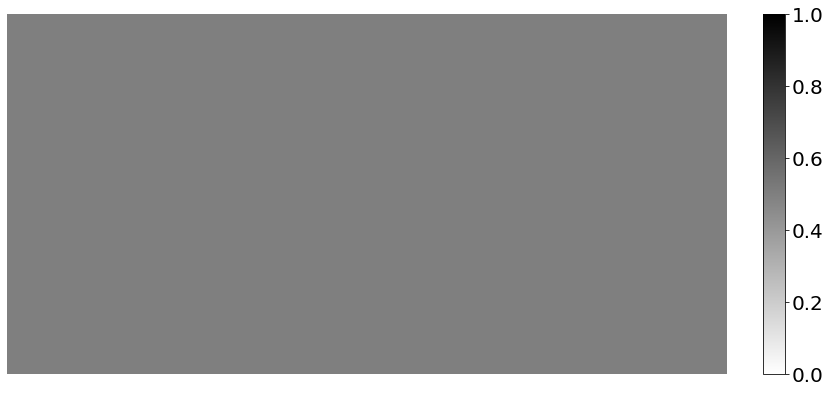

Epoch: 1250/15000, Cost: 0.975926
Et: 1.6795e-01, Eint: 8.7416e-02, Eext and Obj: 2.5536e-01, Vol: 5.1482e-01, Vc: 8.7829e-04
Epoch 1250, Training time: 24.67 seconds
change: 1.1791e-02


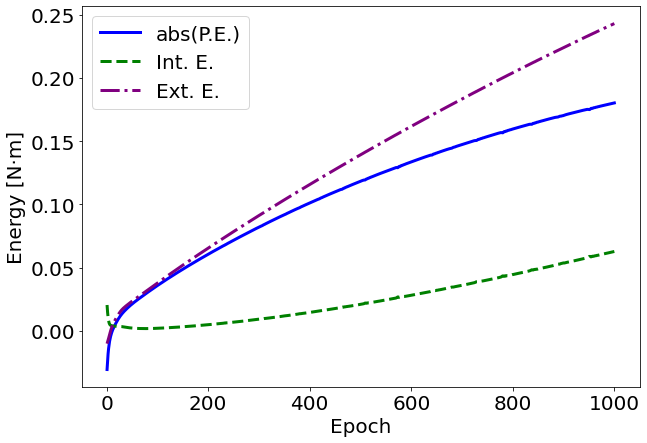

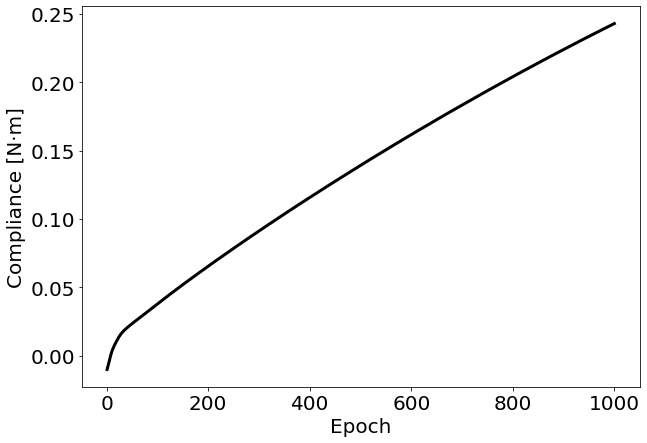

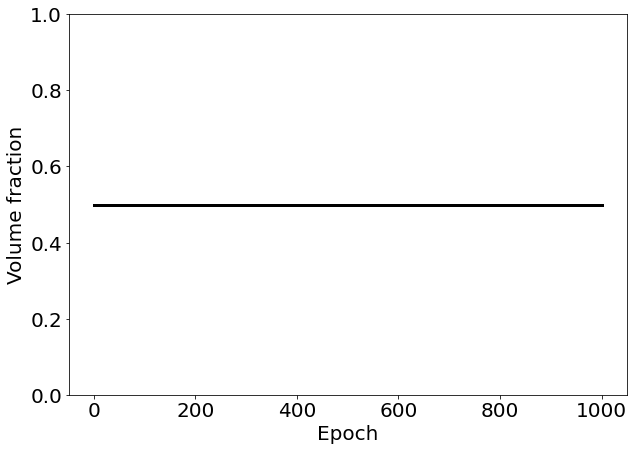

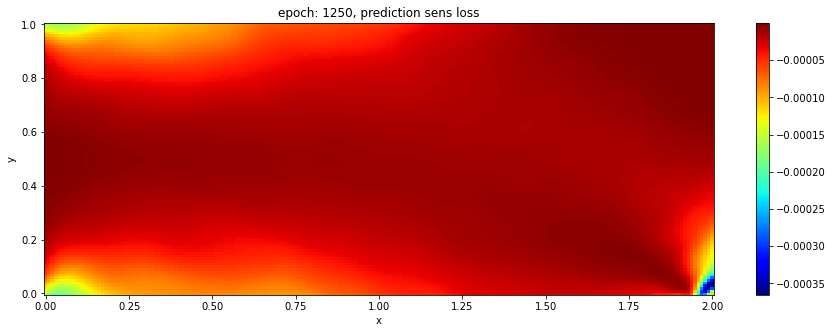

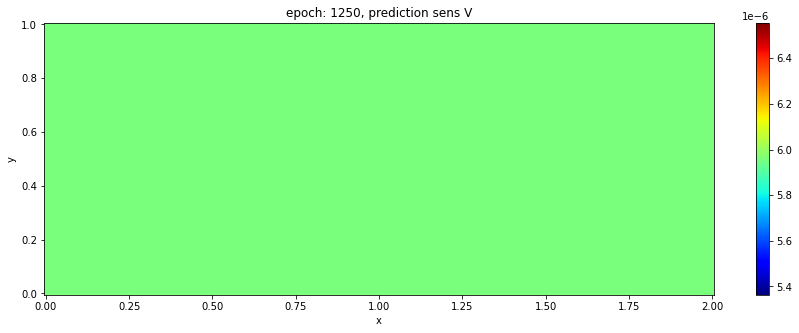

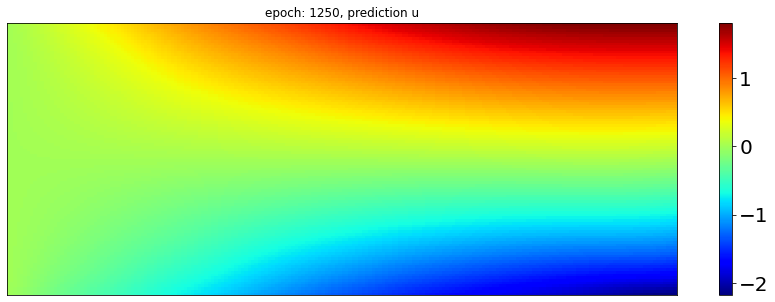

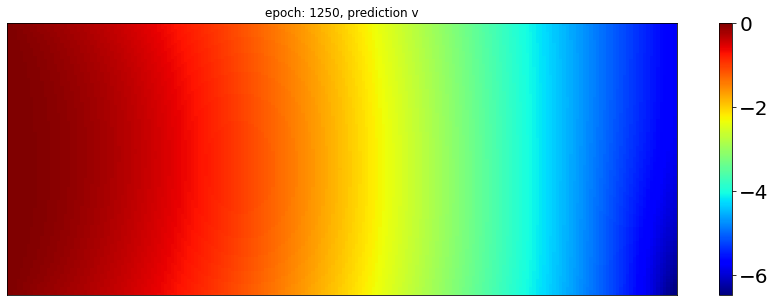

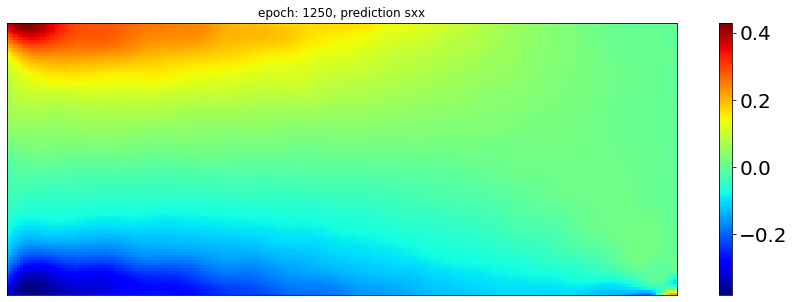

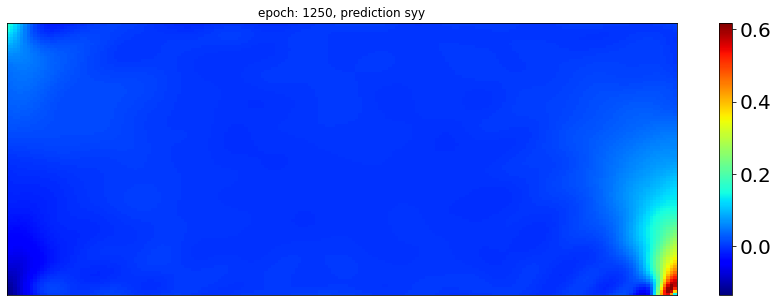

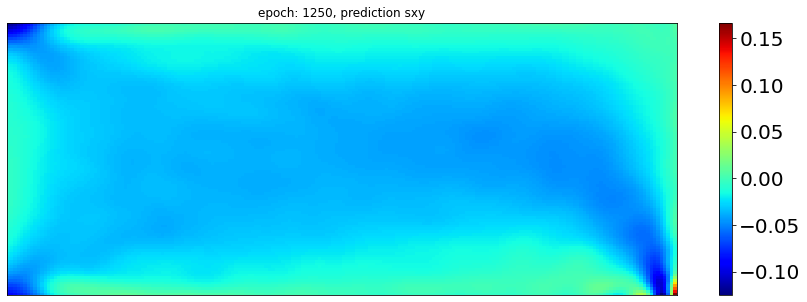

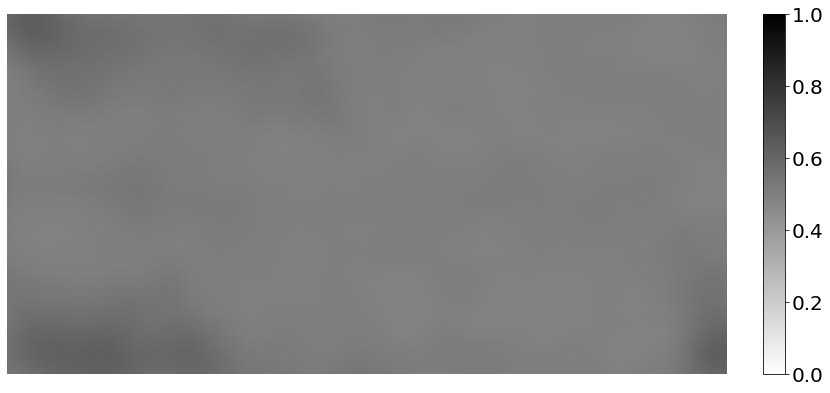

Epoch: 1500/15000, Cost: 0.735282
Et: 1.2726e-01, Eint: 1.3128e-01, Eext and Obj: 2.5854e-01, Vol: 5.1205e-01, Vc: 5.8093e-04
Epoch 1500, Training time: 32.46 seconds
change: 4.4353e-02


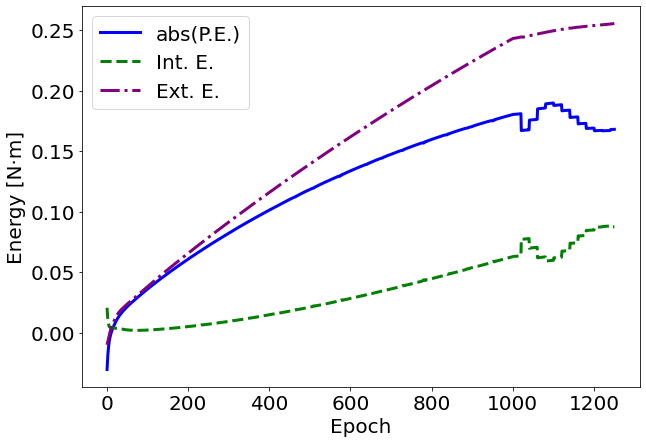

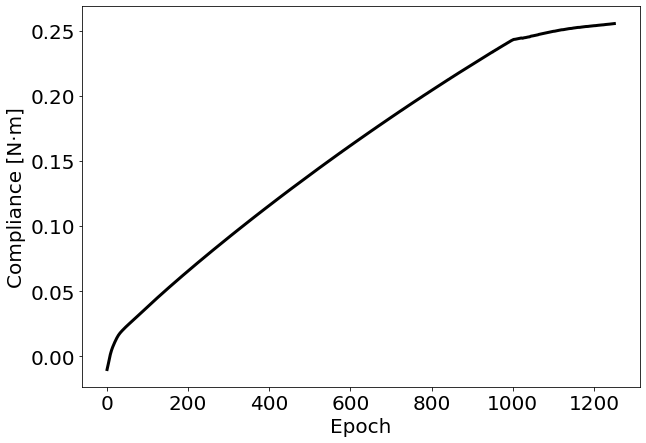

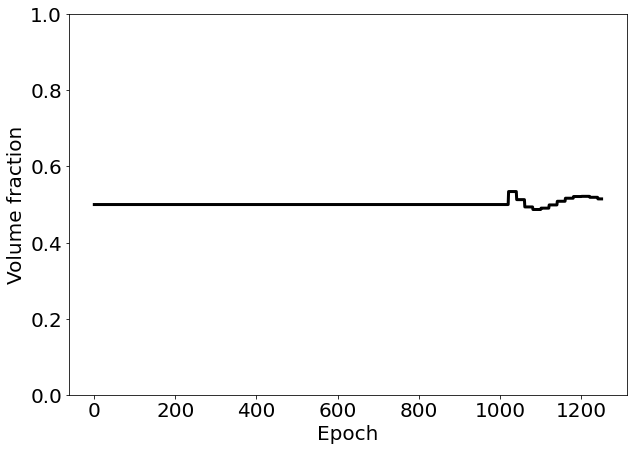

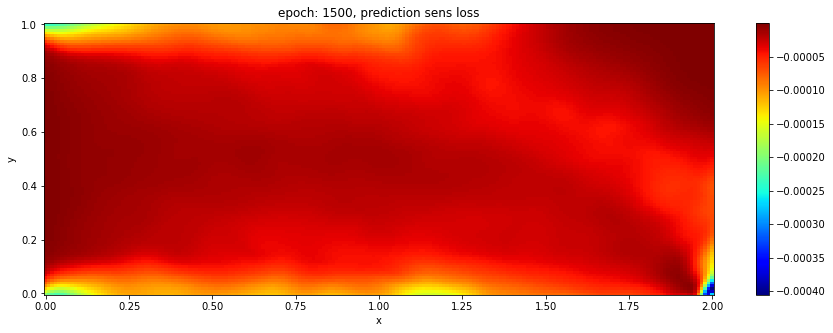

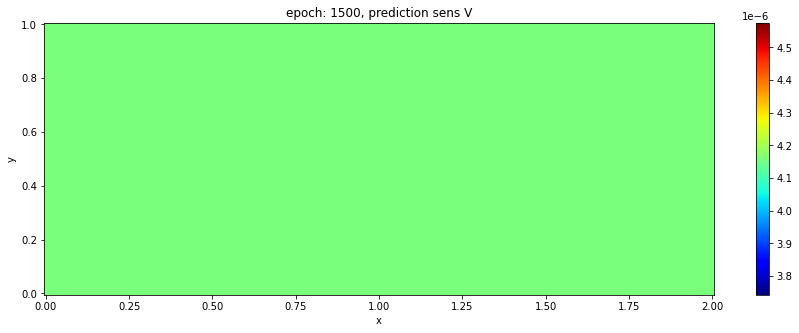

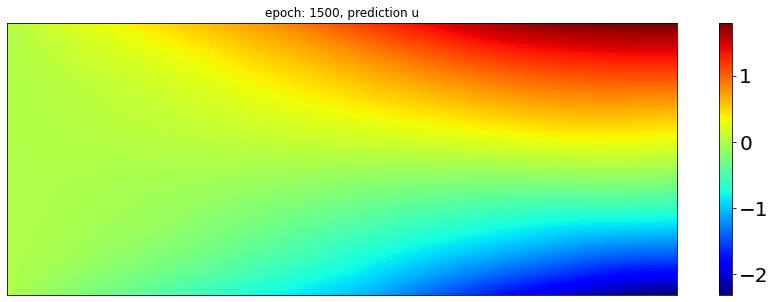

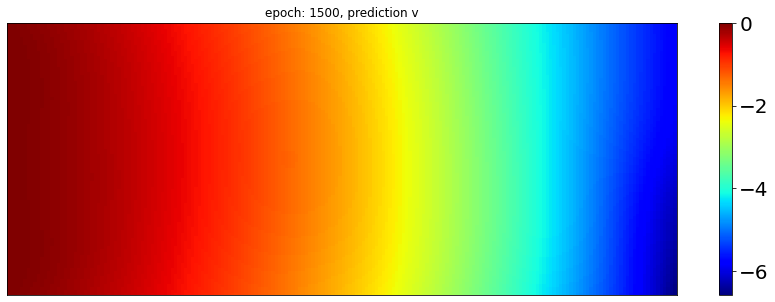

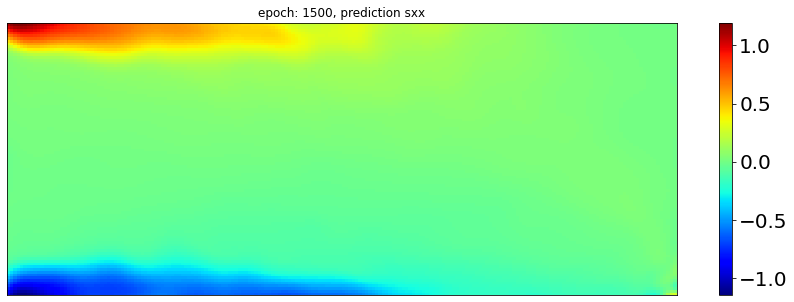

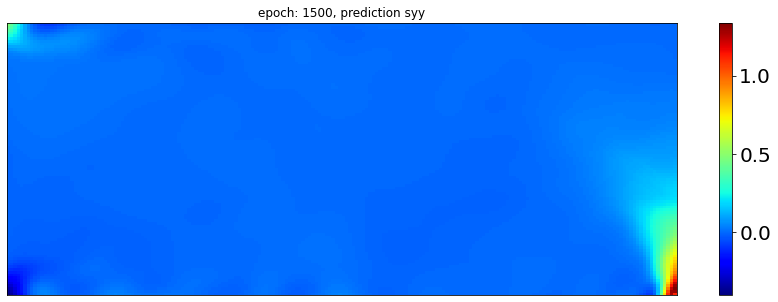

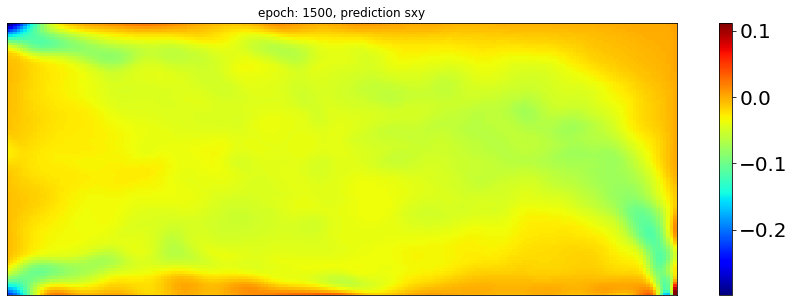

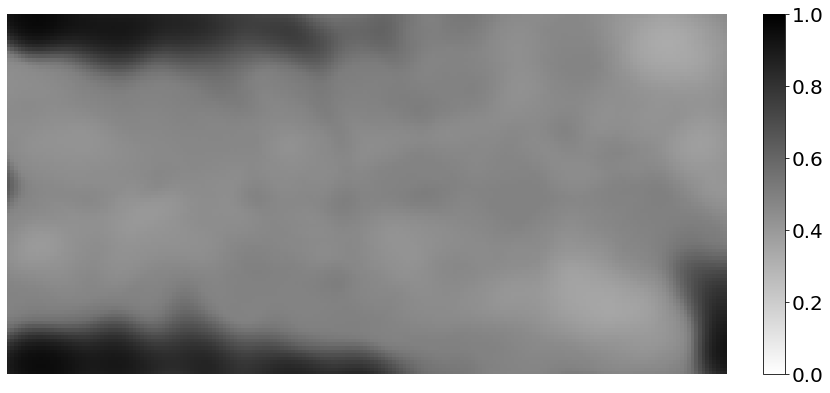

Epoch: 1750/15000, Cost: 0.548896
Et: 9.7542e-02, Eint: 9.7004e-02, Eext and Obj: 1.9455e-01, Vol: 5.0616e-01, Vc: 1.5195e-04
Epoch 1750, Training time: 39.53 seconds
change: 3.8213e-02


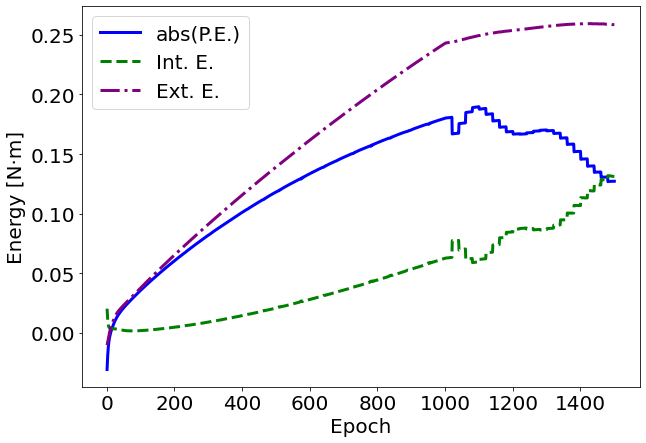

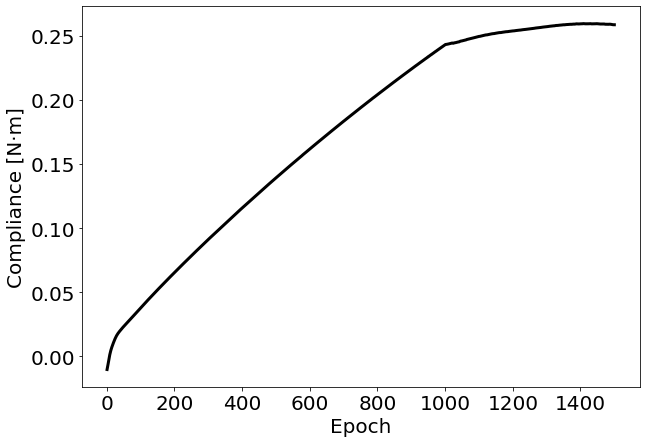

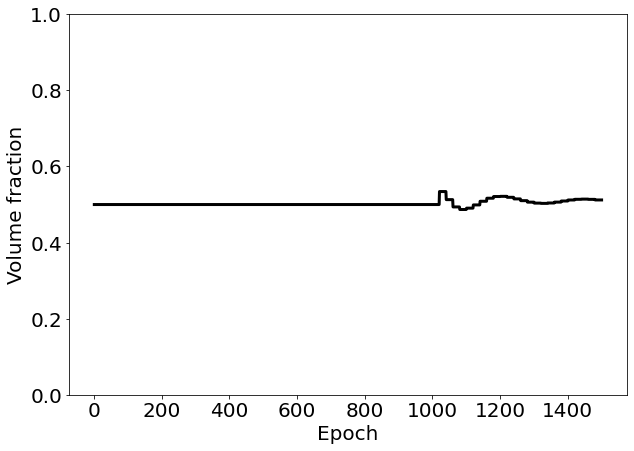

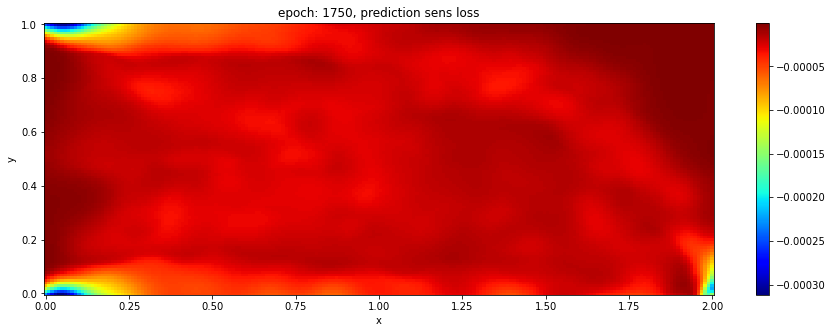

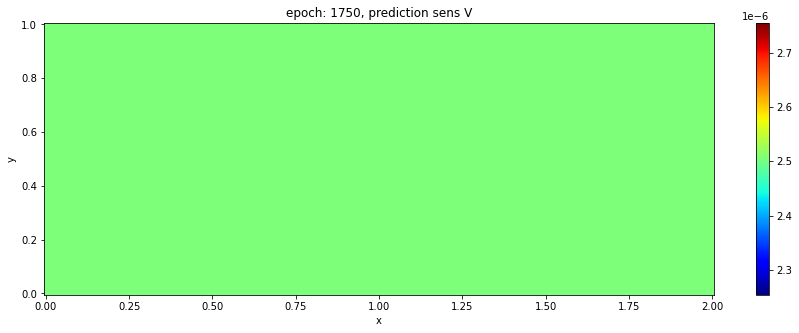

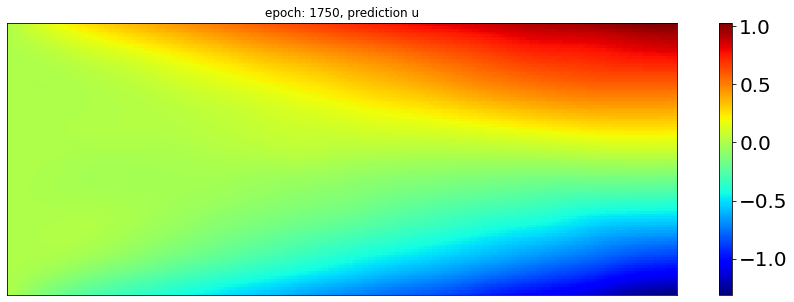

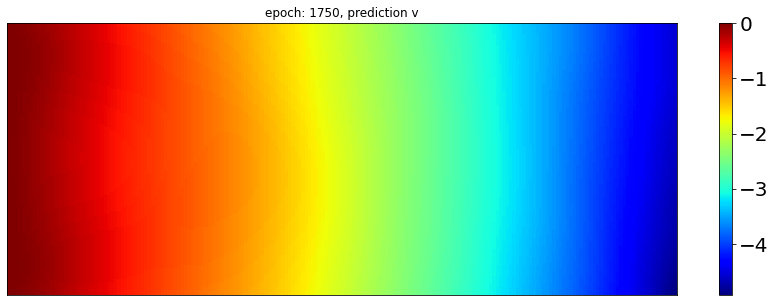

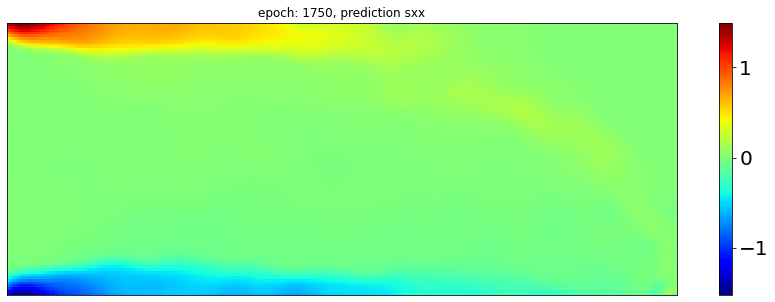

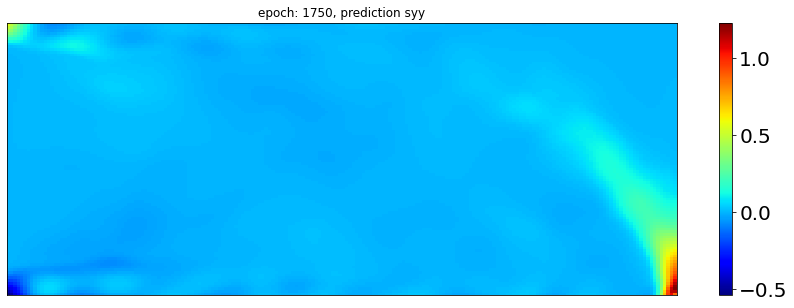

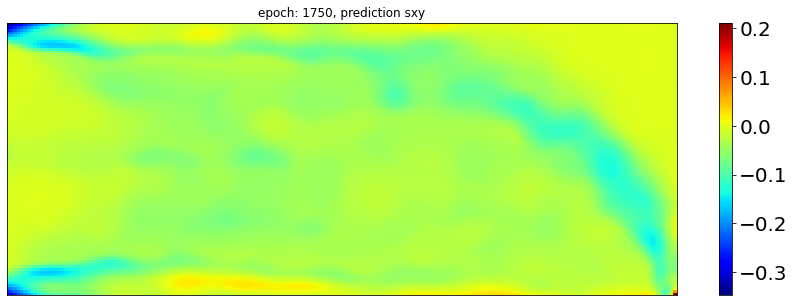

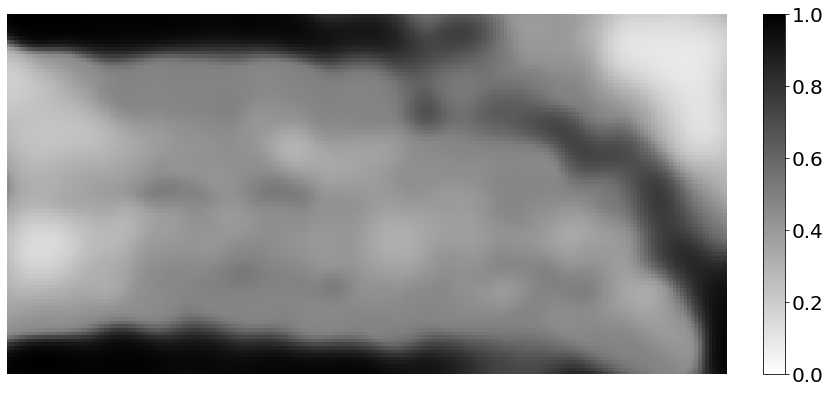

Epoch: 2000/15000, Cost: 0.462013
Et: 8.2486e-02, Eint: 8.2136e-02, Eext and Obj: 1.6462e-01, Vol: 5.0462e-01, Vc: 8.5325e-05
Epoch 2000, Training time: 47.38 seconds
change: 5.8733e-02


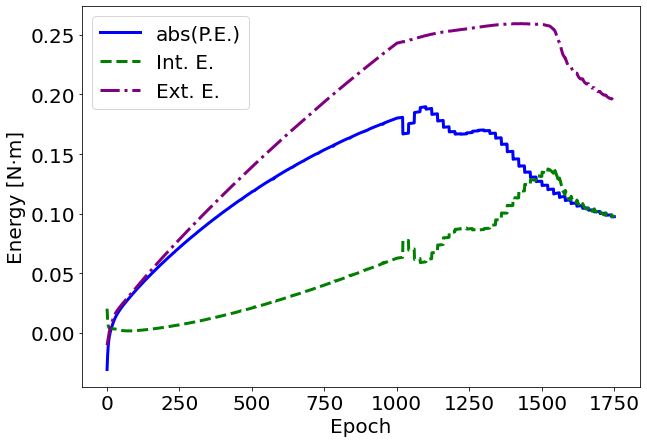

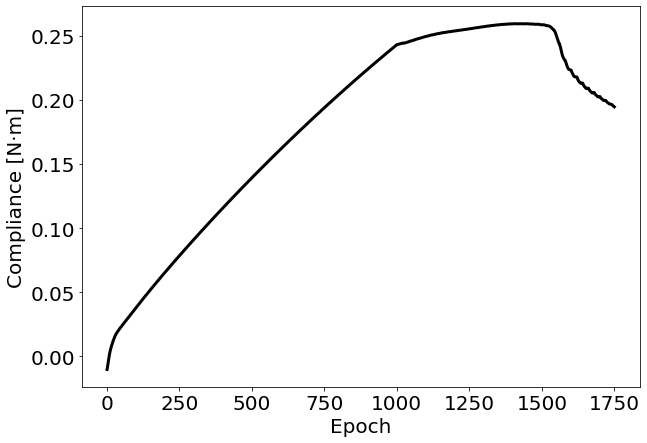

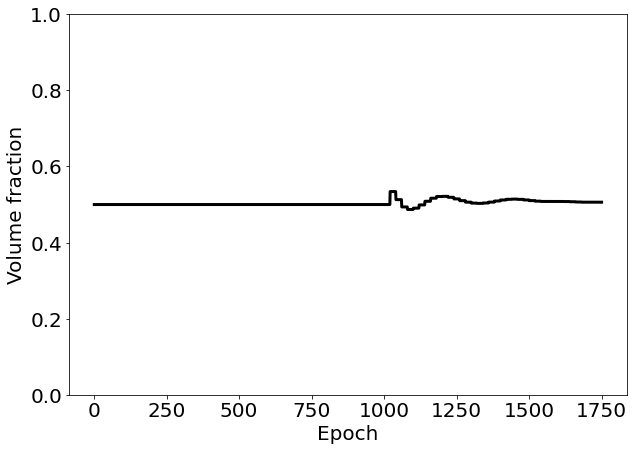

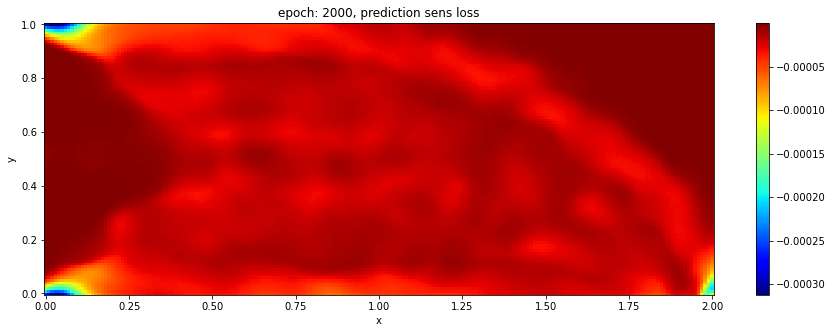

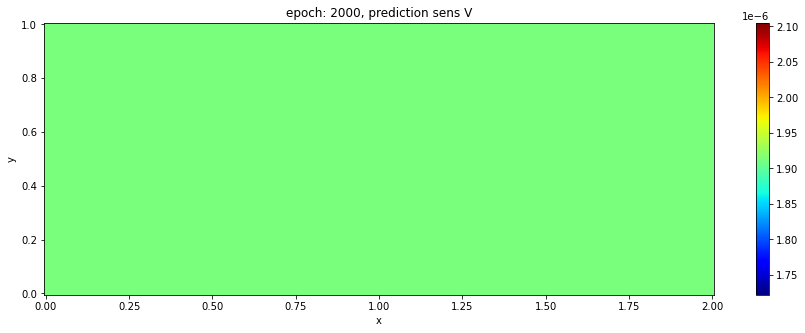

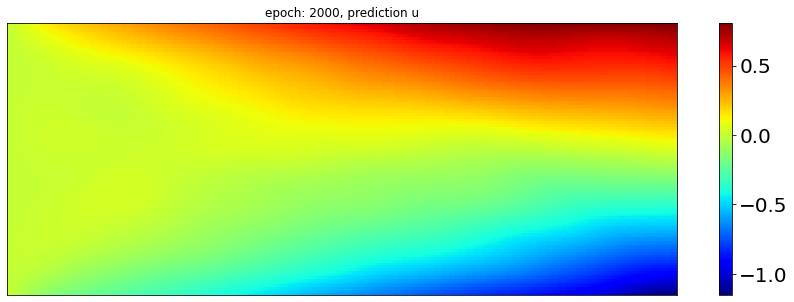

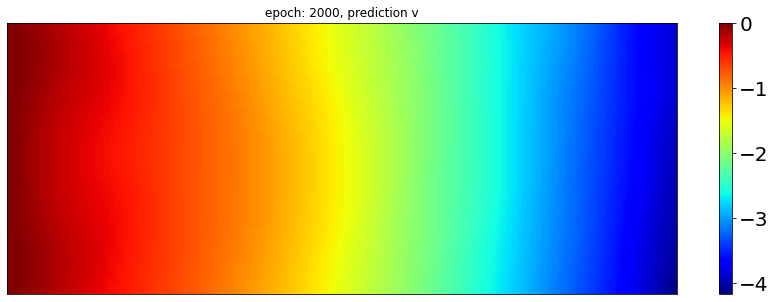

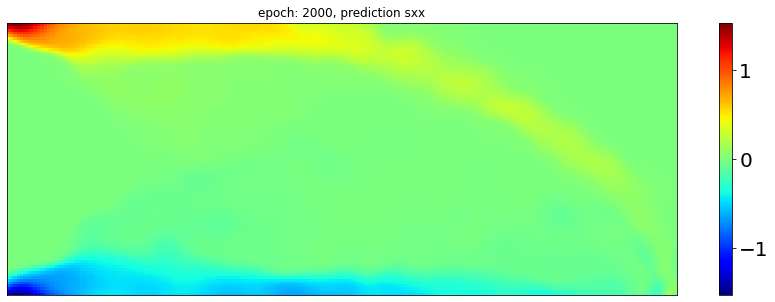

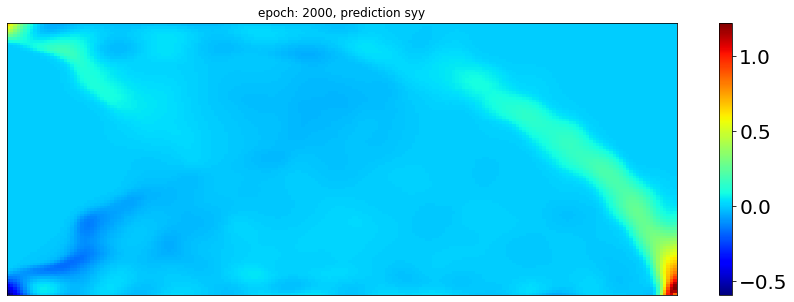

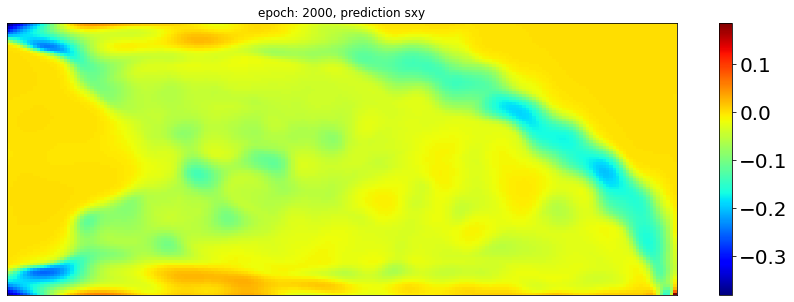

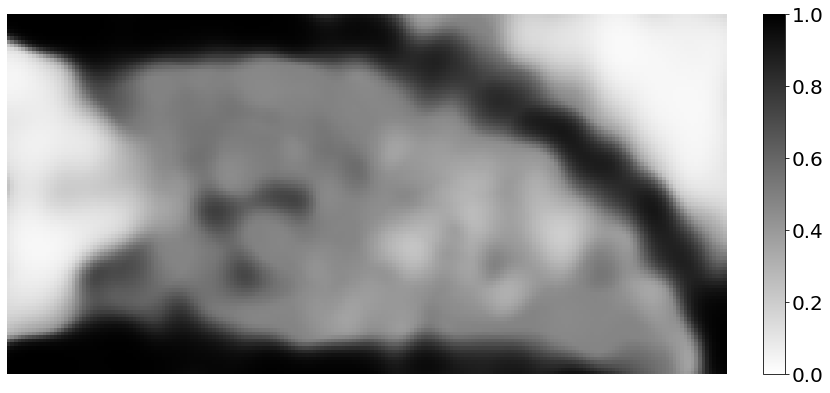

Epoch: 2250/15000, Cost: 0.397555
Et: 7.1168e-02, Eint: 7.1508e-02, Eext and Obj: 1.4268e-01, Vol: 5.0362e-01, Vc: 5.2311e-05
Epoch 2250, Training time: 54.91 seconds
change: 5.1342e-02


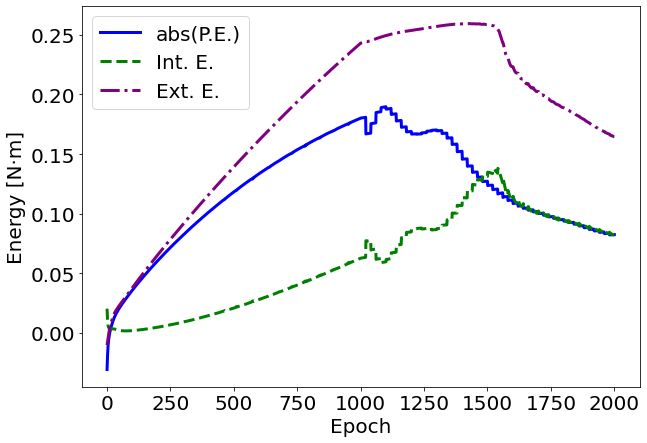

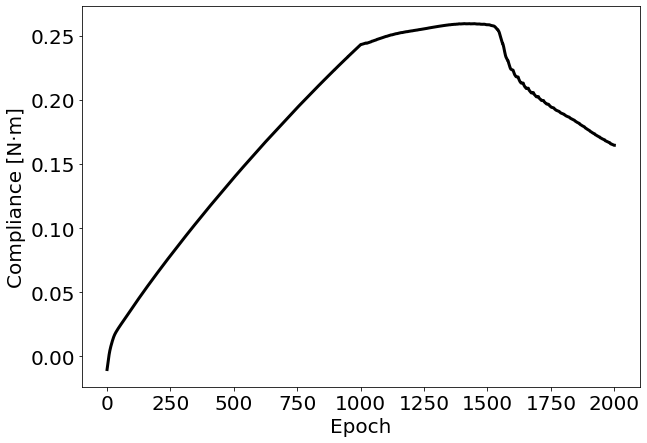

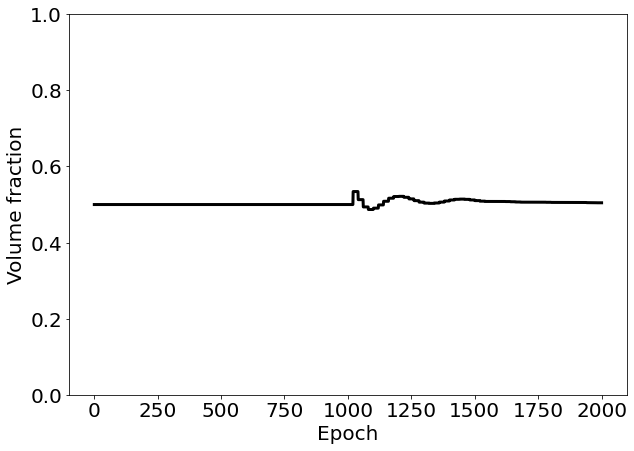

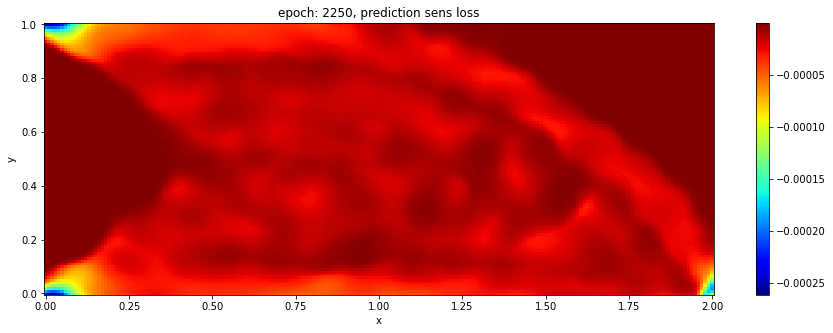

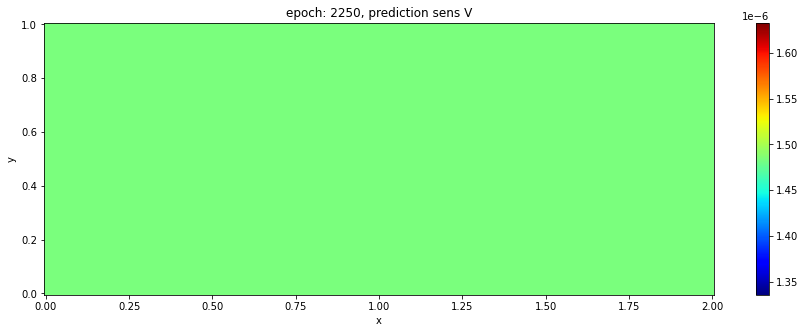

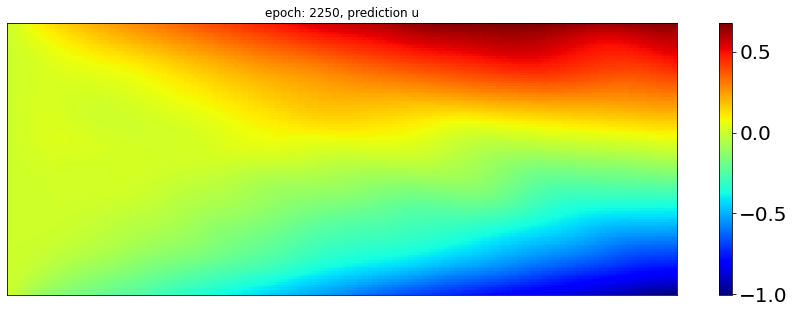

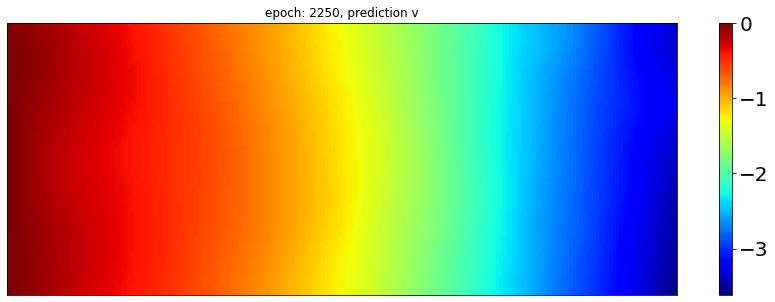

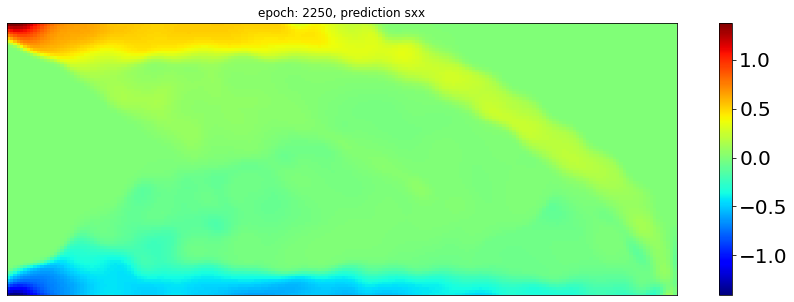

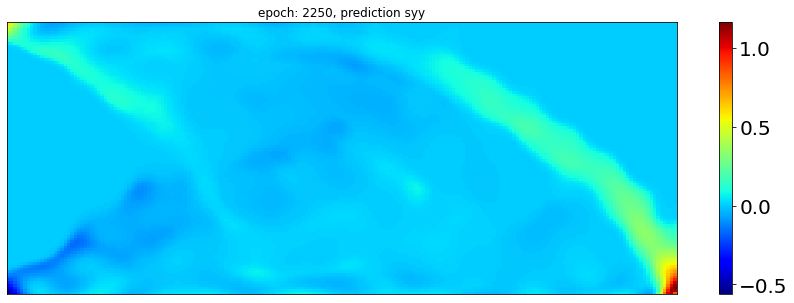

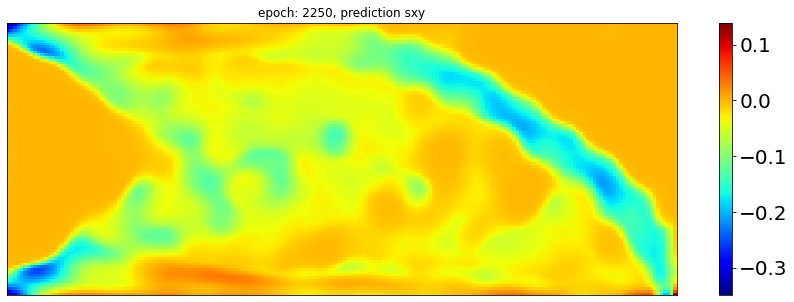

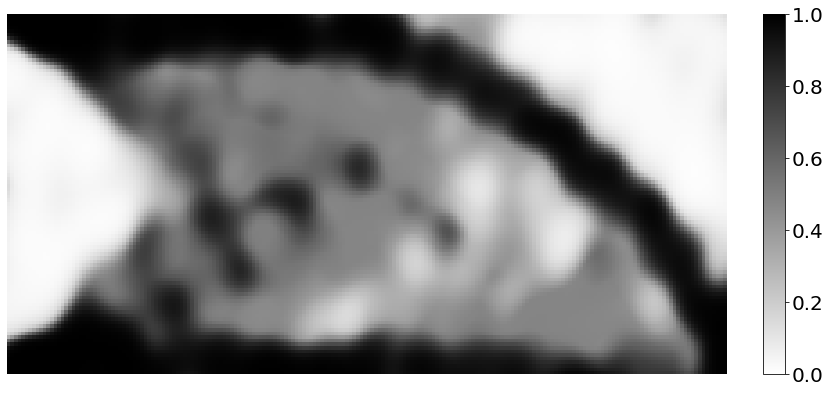

Epoch: 2500/15000, Cost: 0.361634
Et: 6.4843e-02, Eint: 6.4529e-02, Eext and Obj: 1.2937e-01, Vol: 5.0300e-01, Vc: 3.5883e-05
Epoch 2500, Training time: 62.73 seconds
change: 4.4220e-02


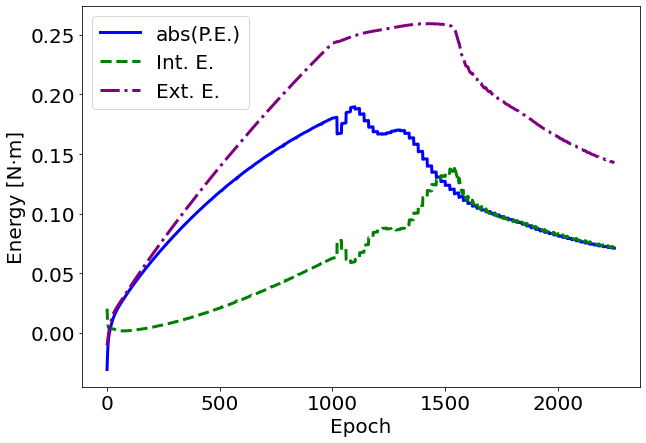

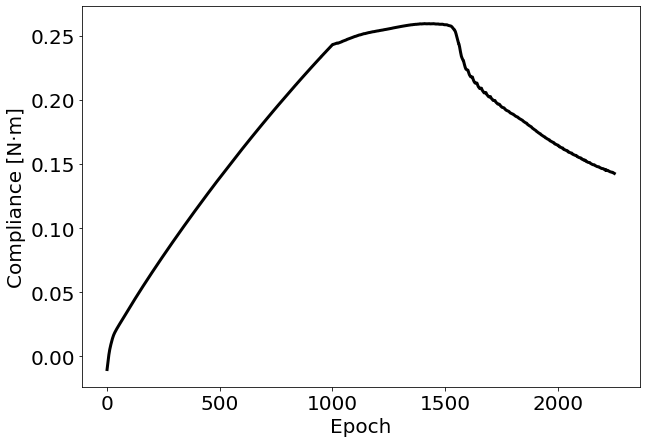

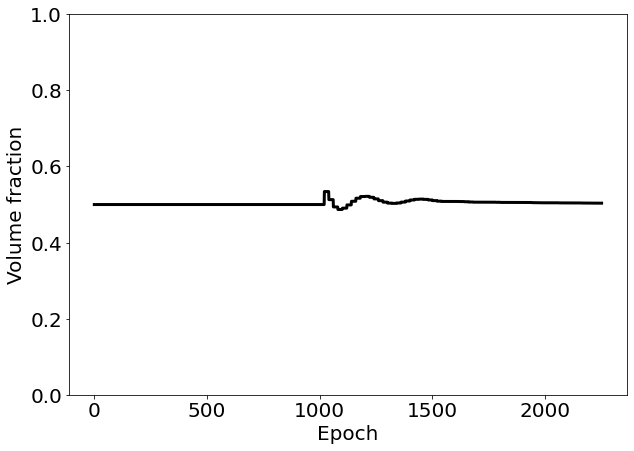

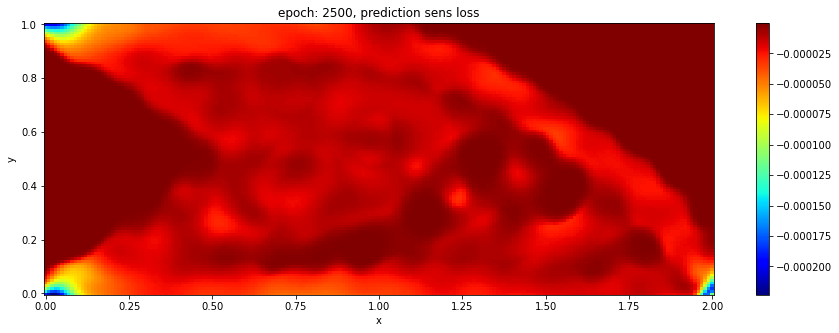

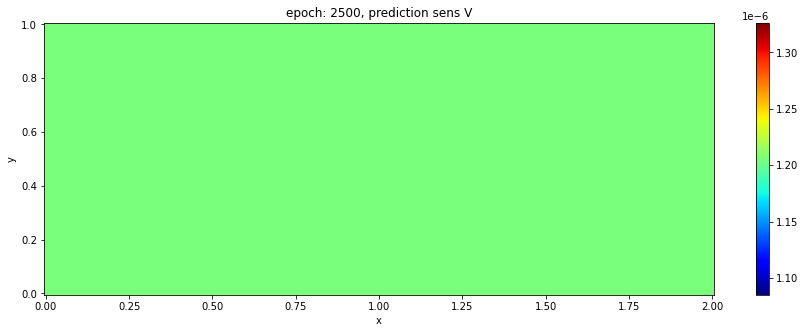

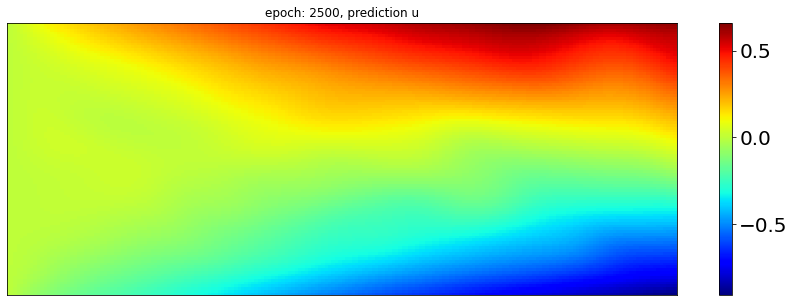

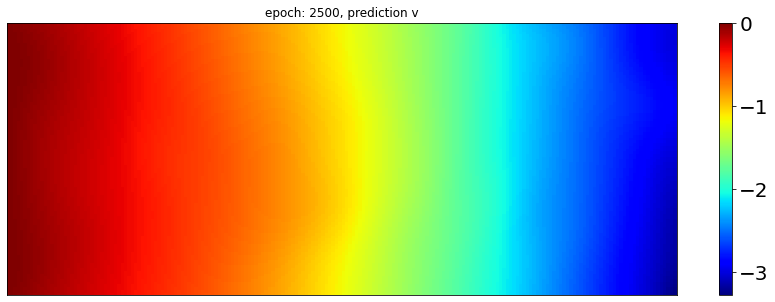

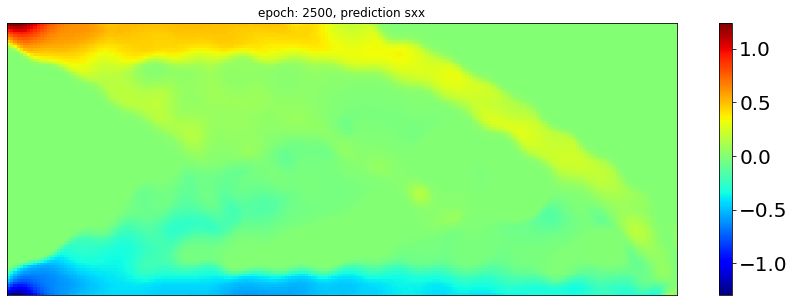

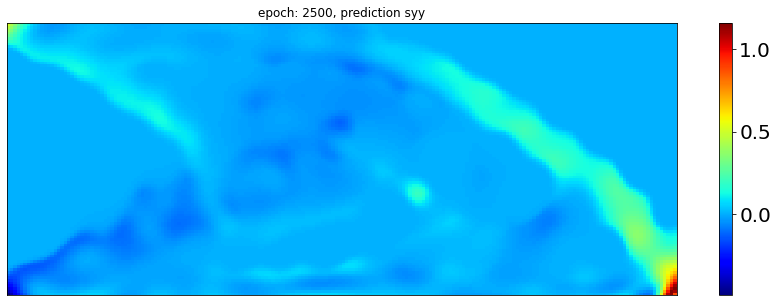

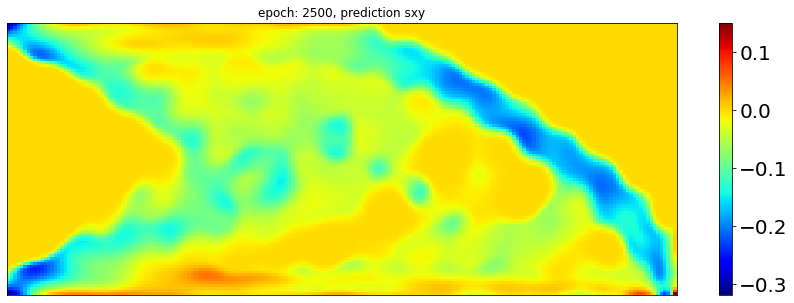

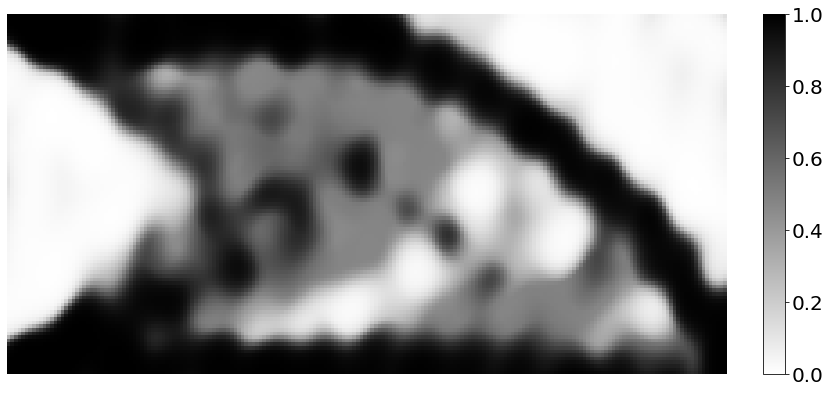

Epoch: 2750/15000, Cost: 0.330144
Et: 5.9280e-02, Eint: 5.9459e-02, Eext and Obj: 1.1874e-01, Vol: 5.0242e-01, Vc: 2.3482e-05
Epoch 2750, Training time: 70.15 seconds
change: 4.8907e-02


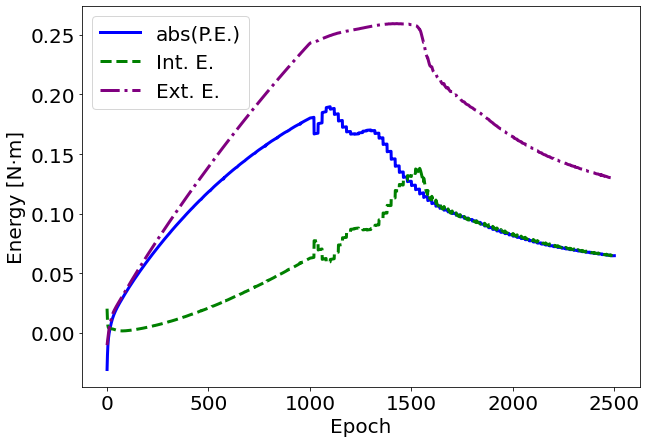

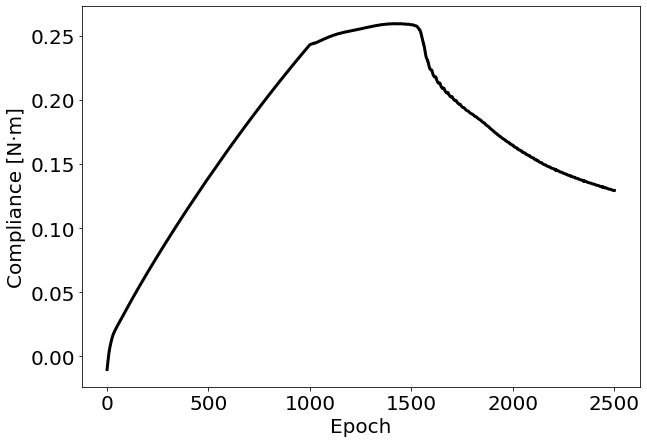

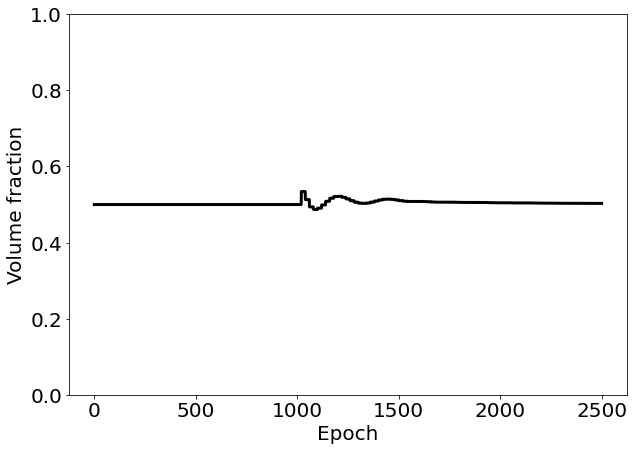

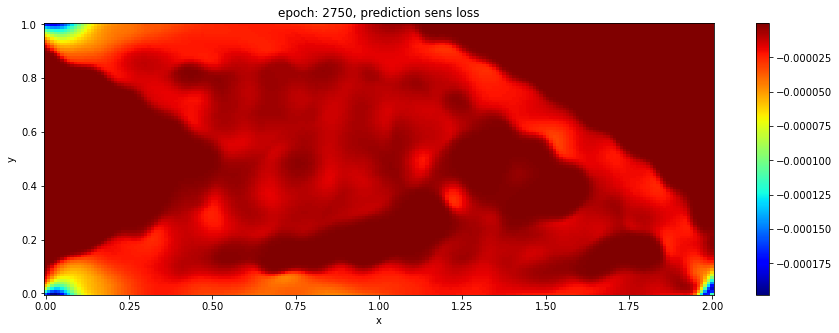

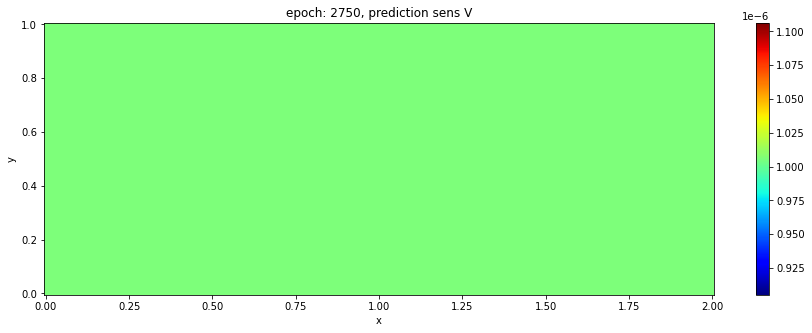

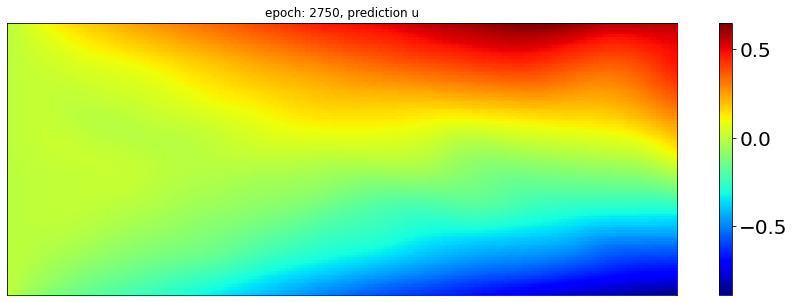

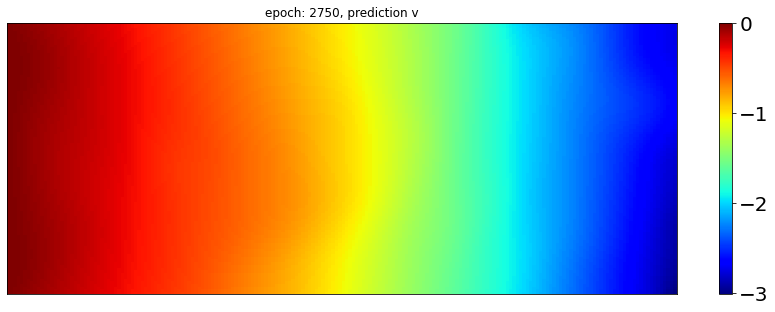

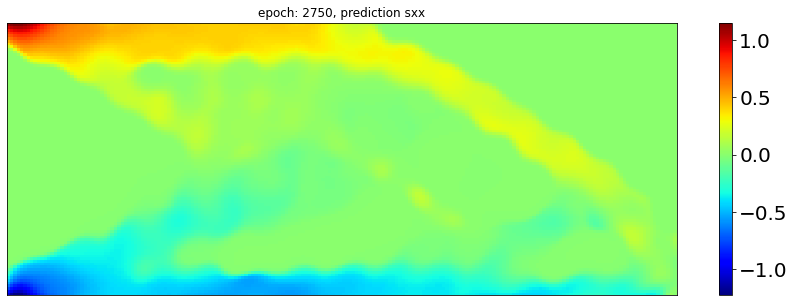

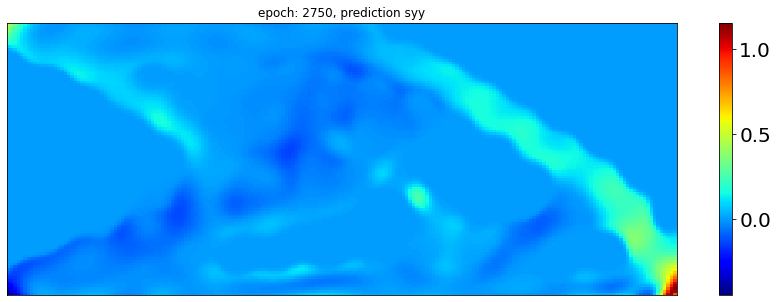

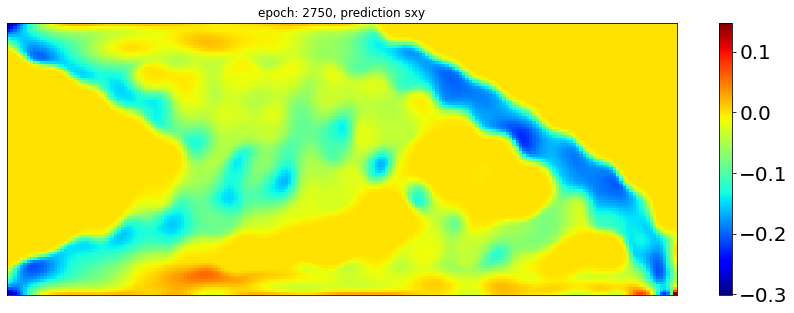

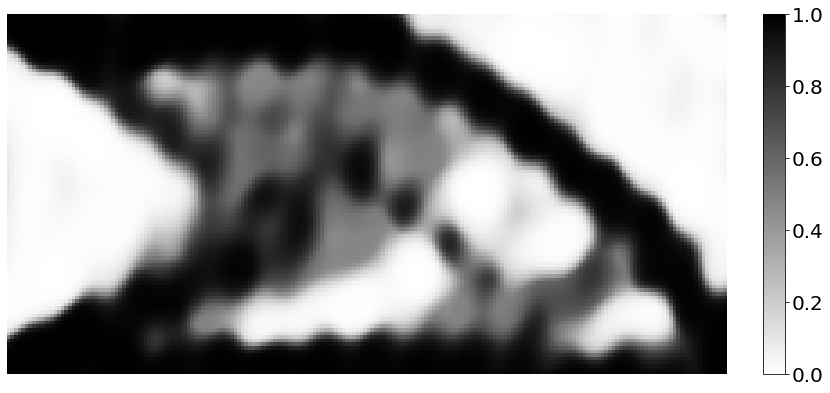

Epoch: 3000/15000, Cost: 0.312187
Et: 5.6094e-02, Eint: 5.6031e-02, Eext and Obj: 1.1212e-01, Vol: 5.0212e-01, Vc: 1.8021e-05
Epoch 3000, Training time: 77.96 seconds
change: 3.8394e-02


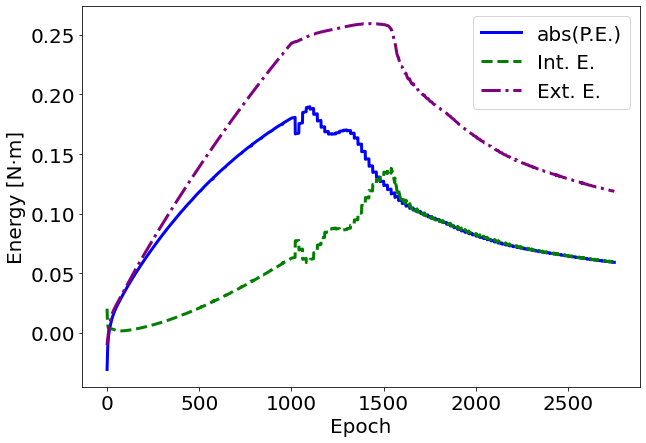

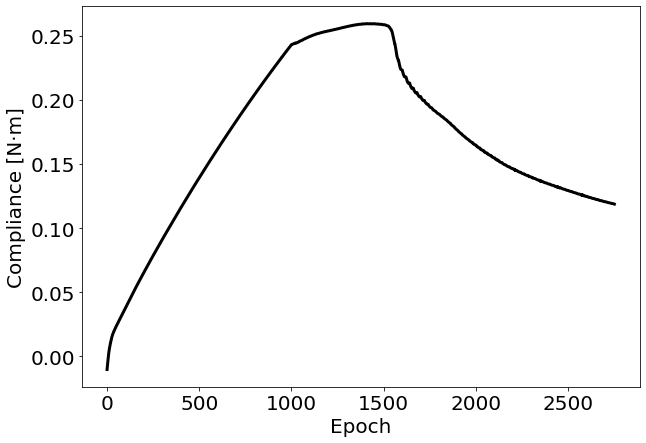

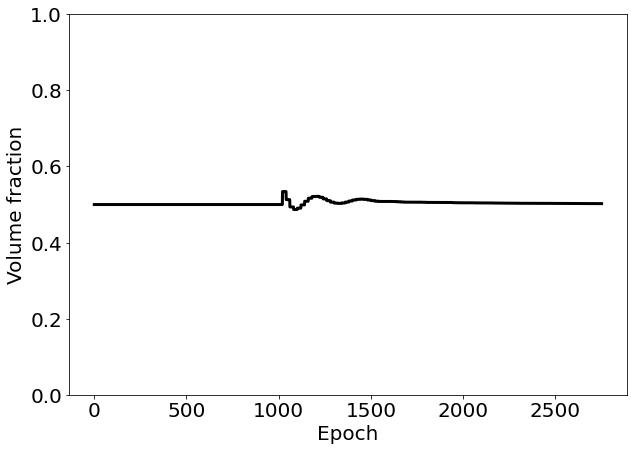

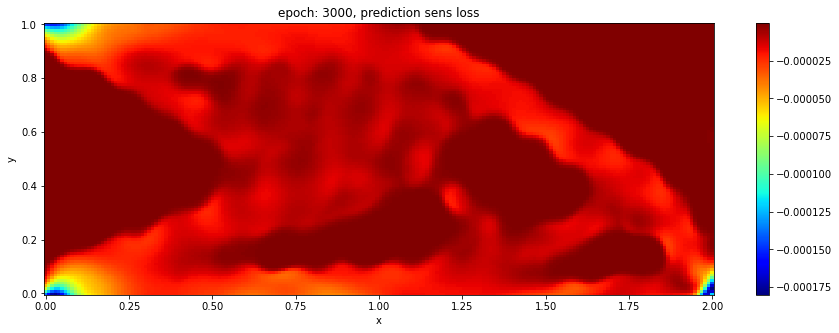

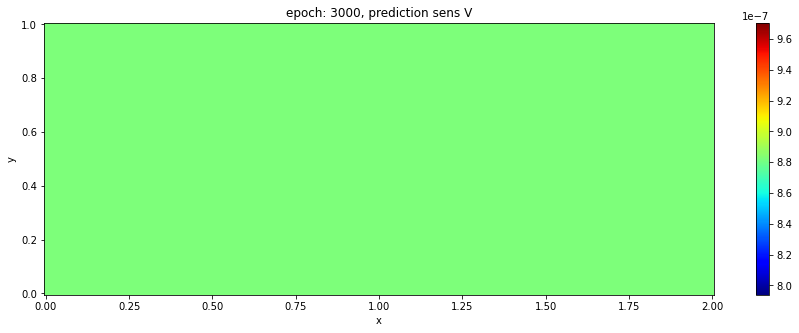

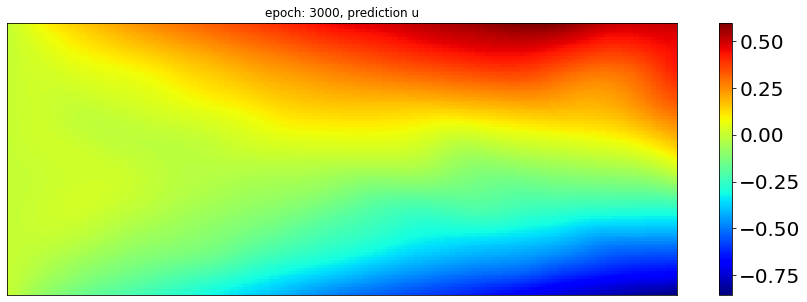

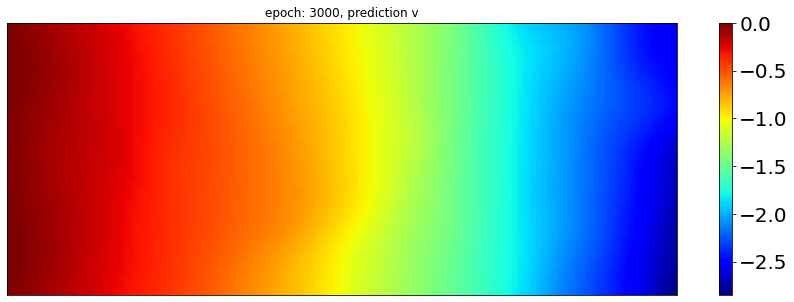

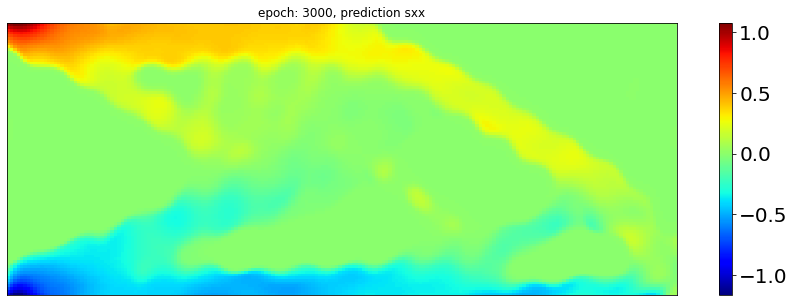

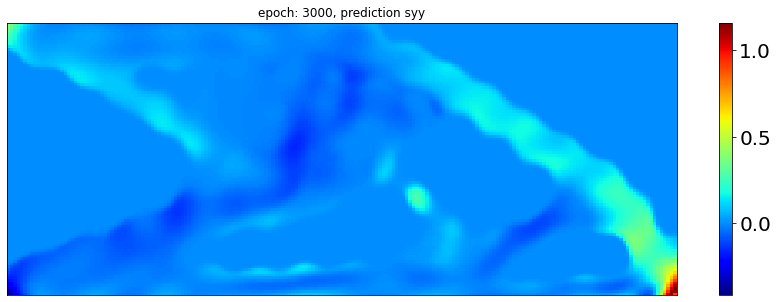

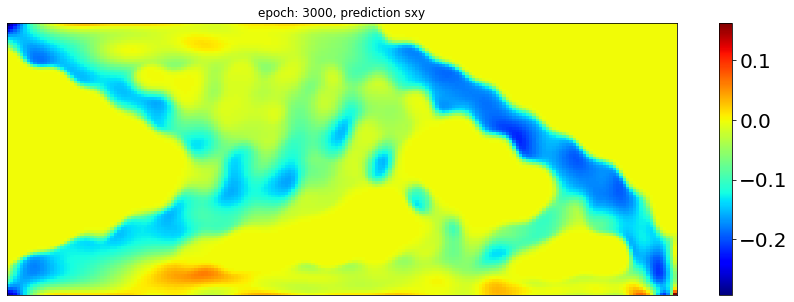

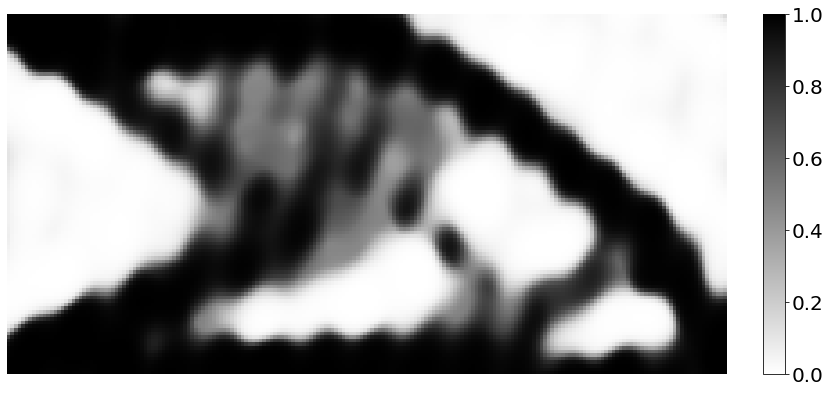

Epoch: 3250/15000, Cost: 0.300710
Et: 5.4054e-02, Eint: 5.3934e-02, Eext and Obj: 1.0799e-01, Vol: 5.0193e-01, Vc: 1.4884e-05
Epoch 3250, Training time: 85.59 seconds
change: 2.8166e-02


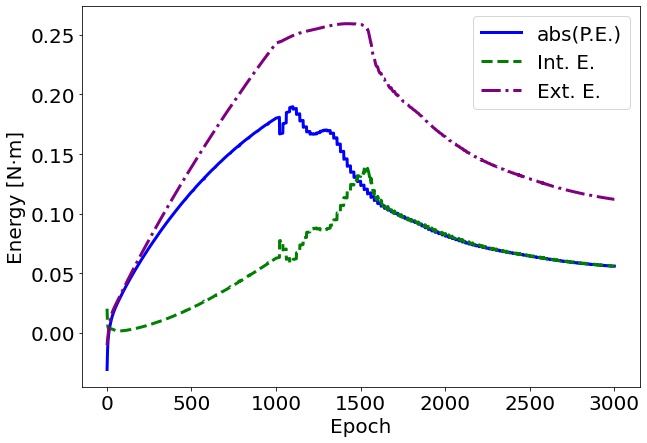

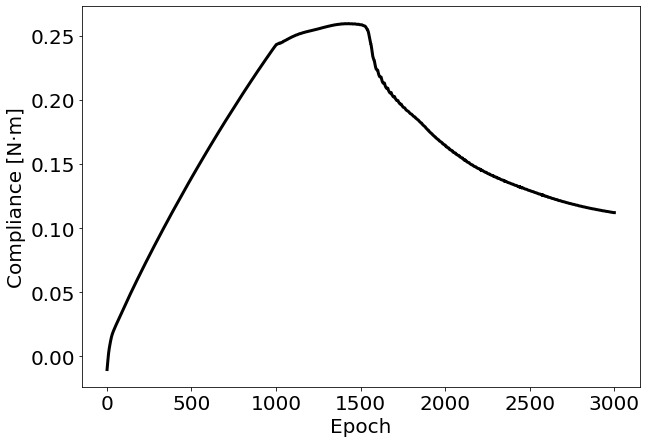

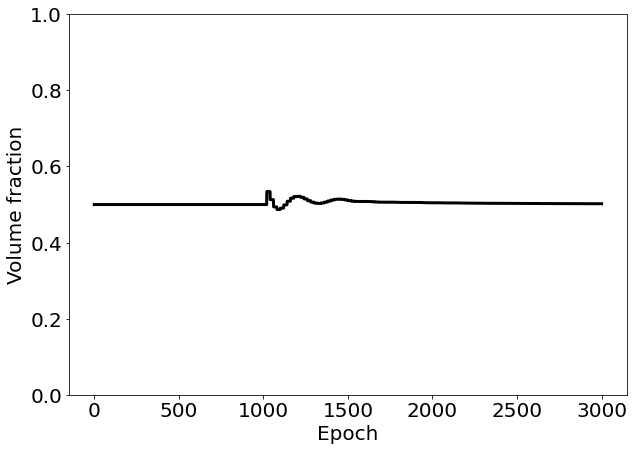

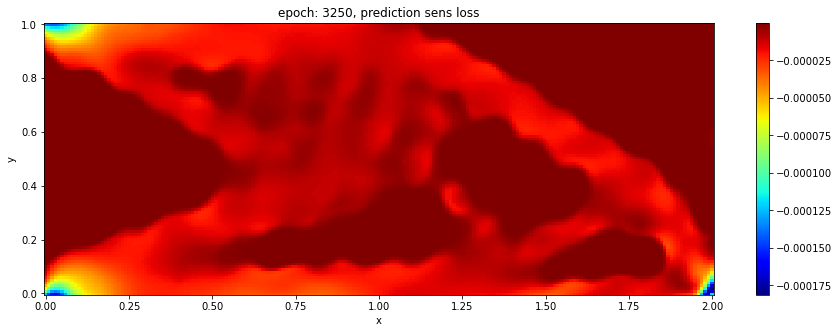

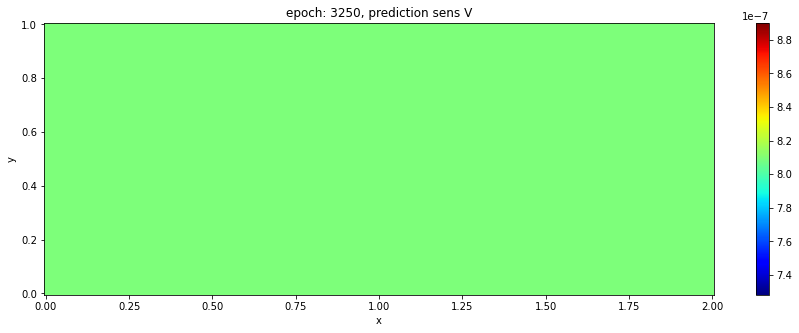

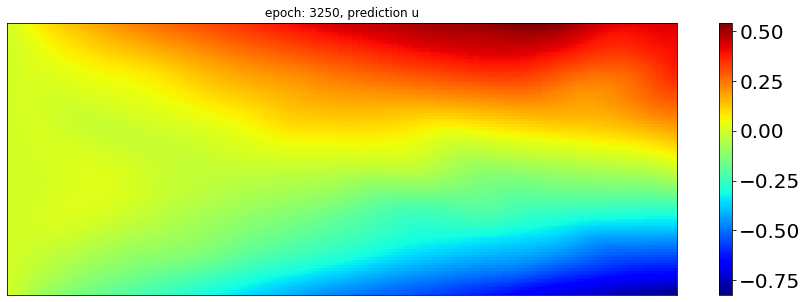

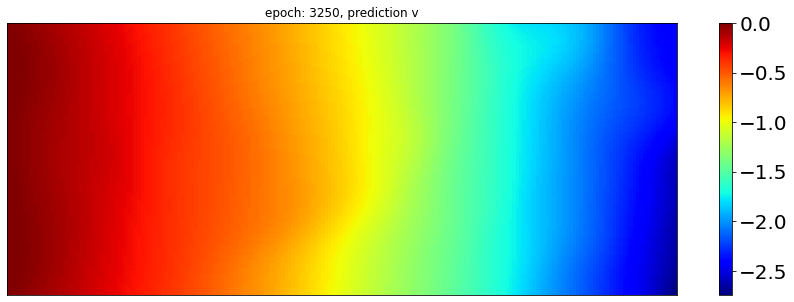

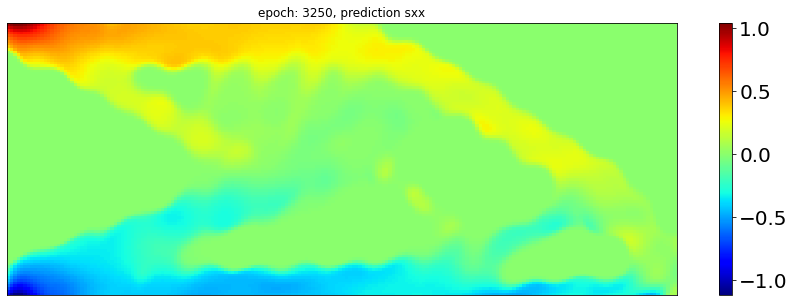

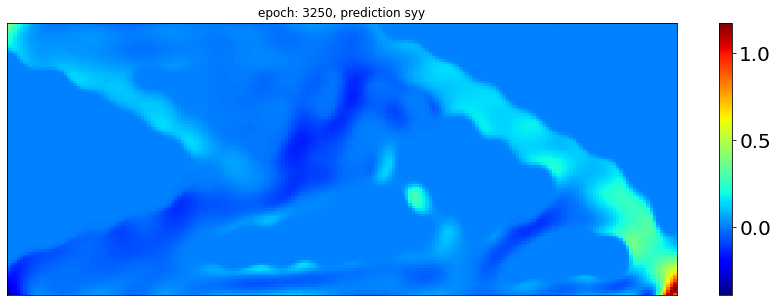

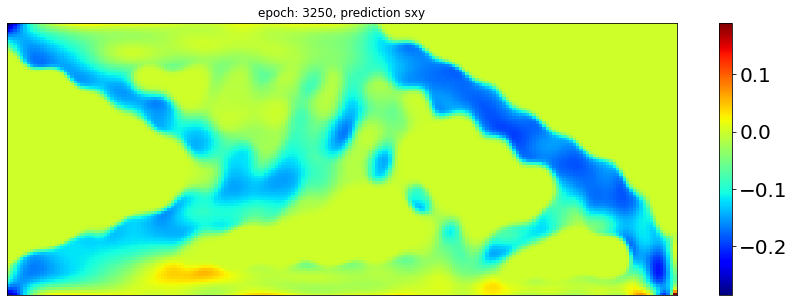

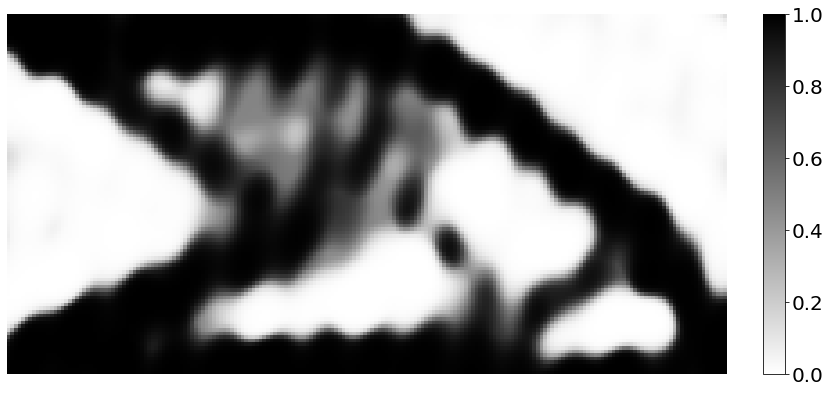

Epoch: 3500/15000, Cost: 0.292548
Et: 5.2606e-02, Eint: 5.2389e-02, Eext and Obj: 1.0499e-01, Vol: 5.0176e-01, Vc: 1.2366e-05
Epoch 3500, Training time: 93.54 seconds
change: 3.7158e-02


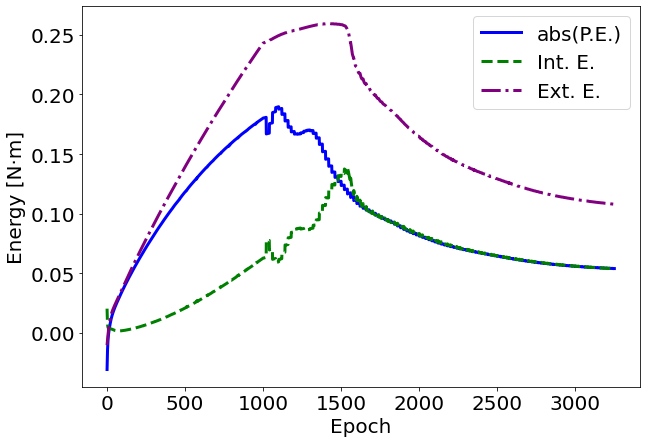

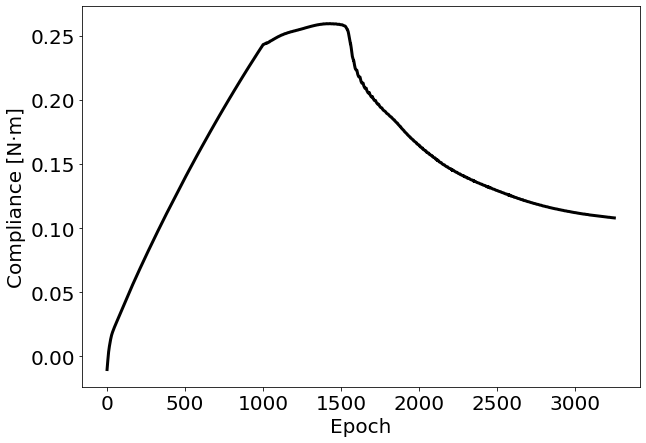

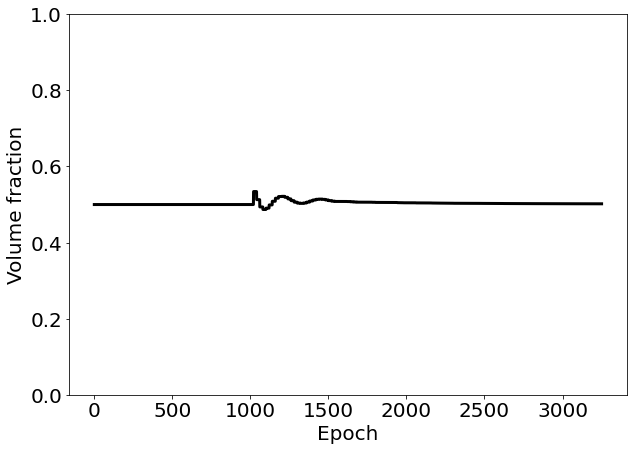

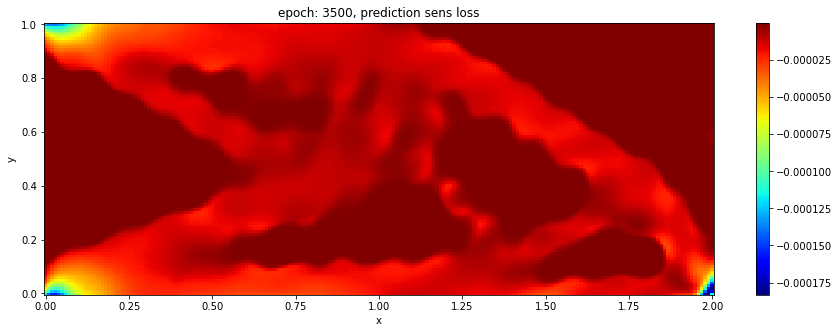

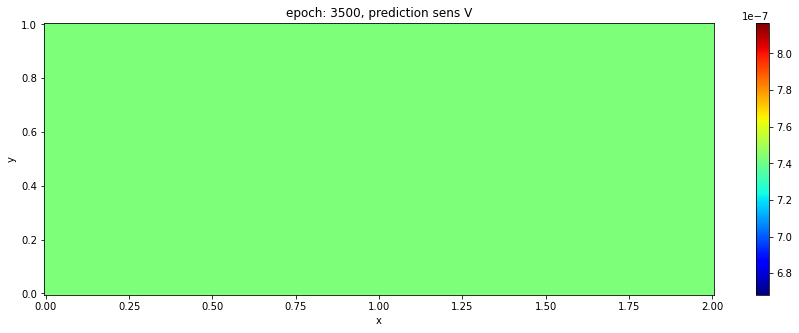

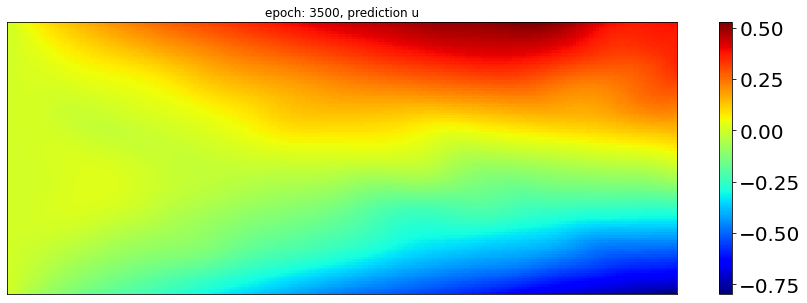

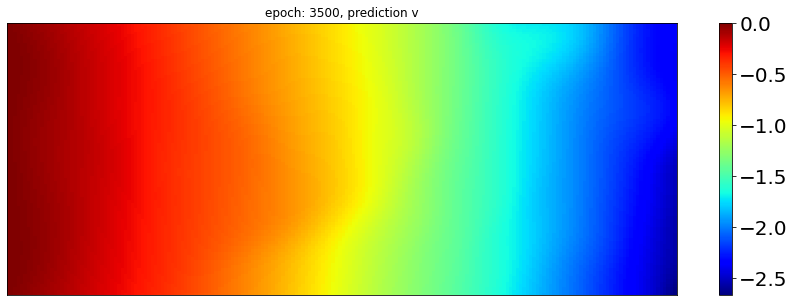

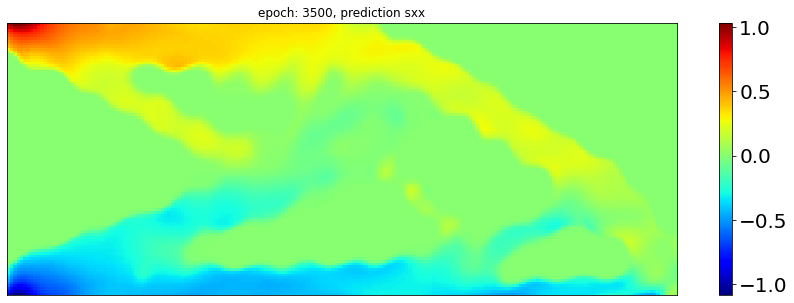

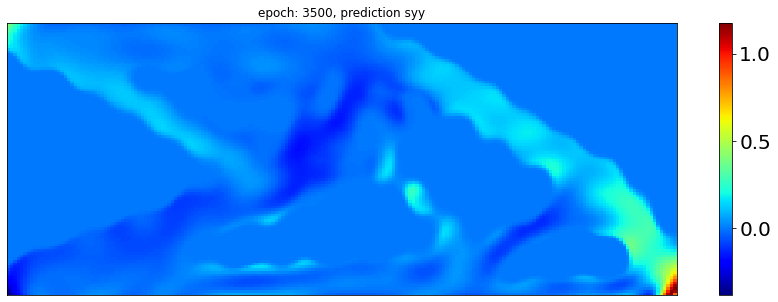

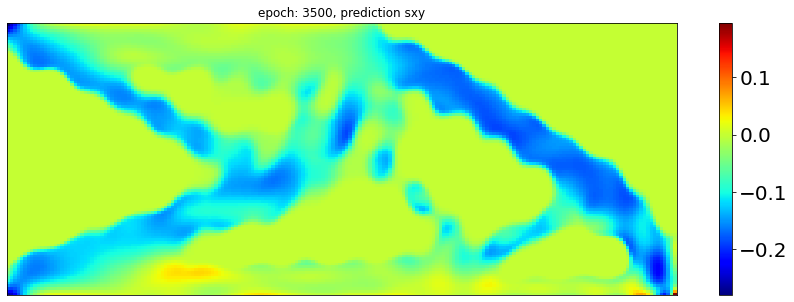

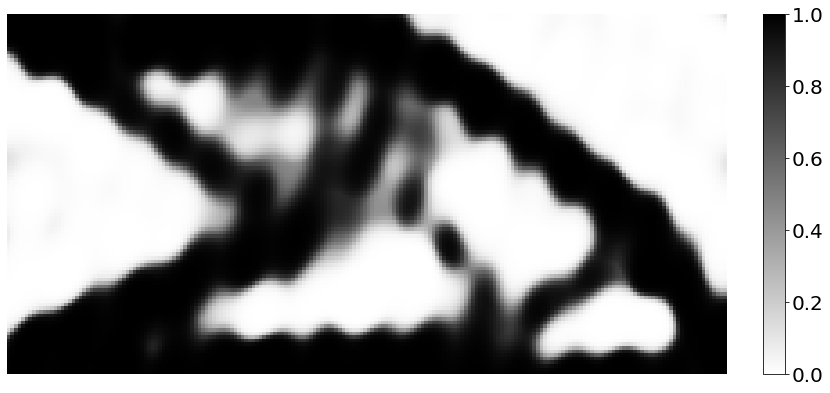

Epoch: 3750/15000, Cost: 0.285175
Et: 5.1294e-02, Eint: 5.1237e-02, Eext and Obj: 1.0253e-01, Vol: 5.0162e-01, Vc: 1.0449e-05
Epoch 3750, Training time: 101.22 seconds
change: 3.0853e-02


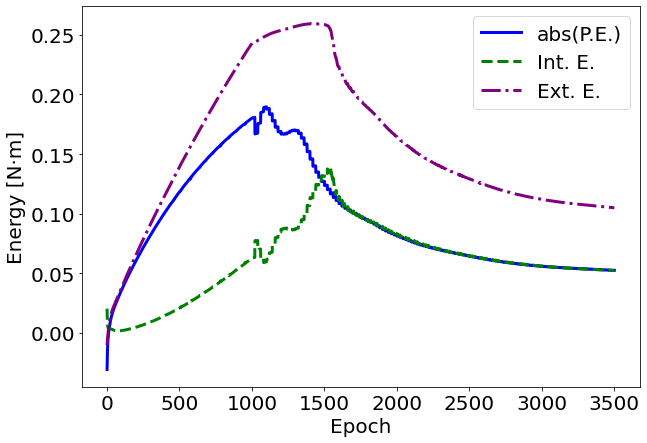

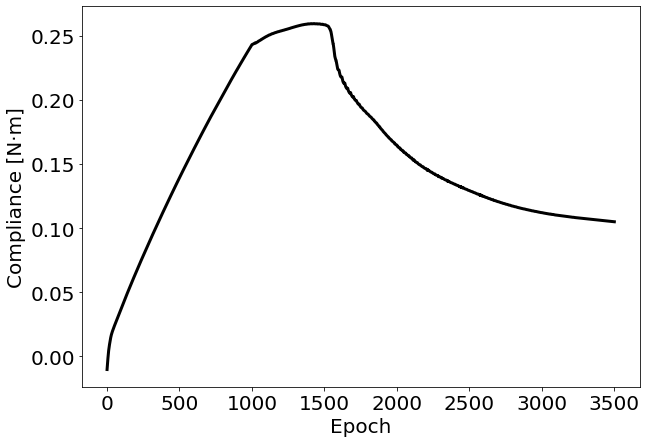

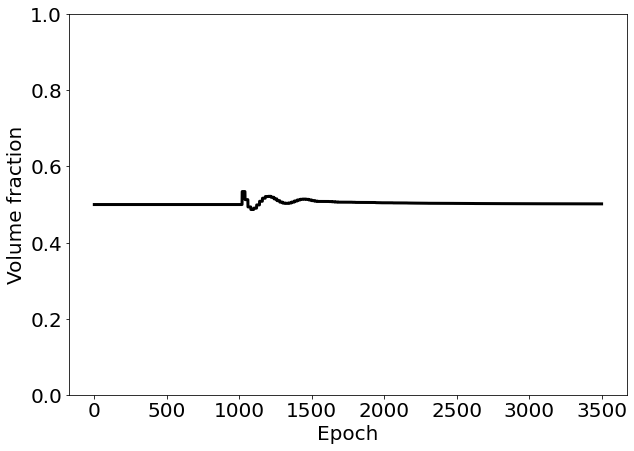

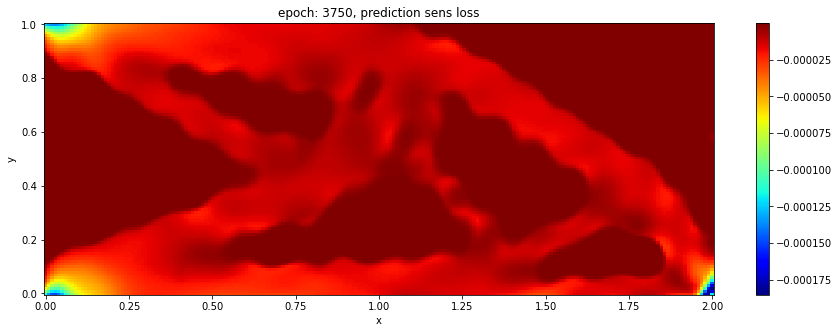

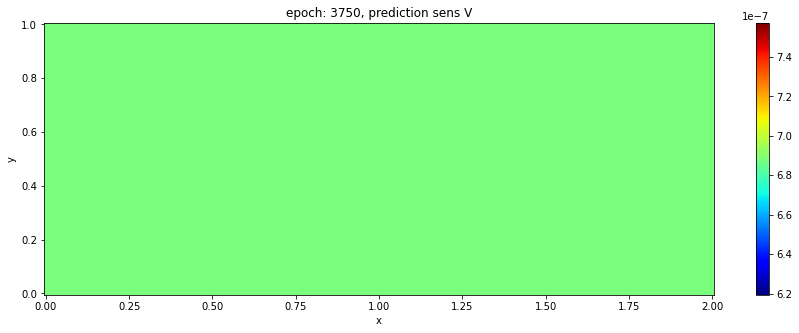

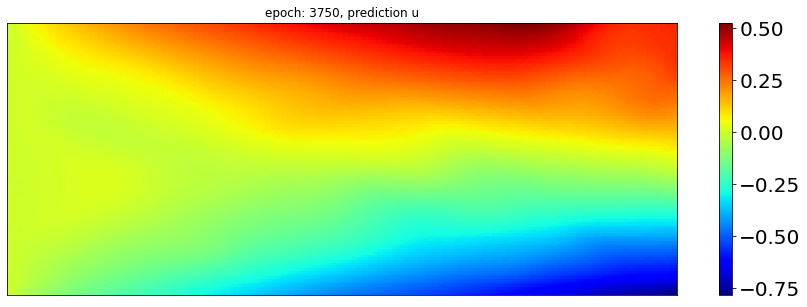

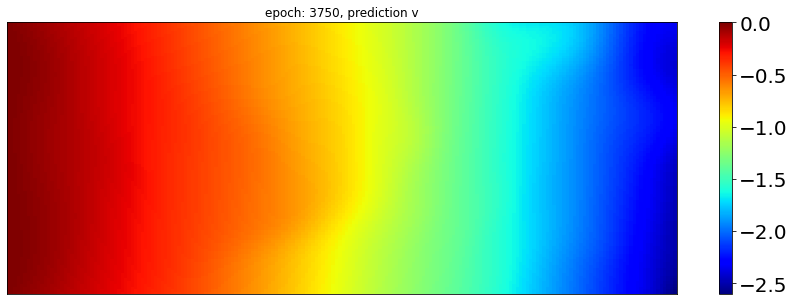

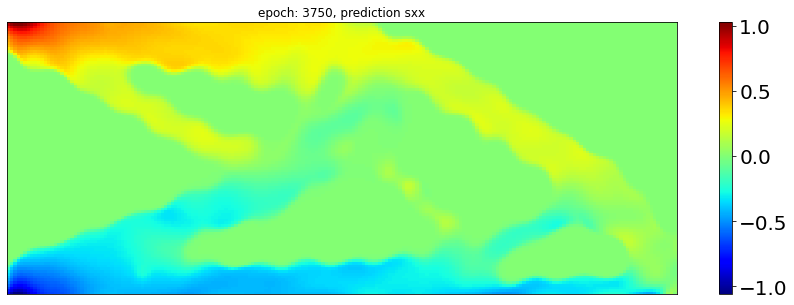

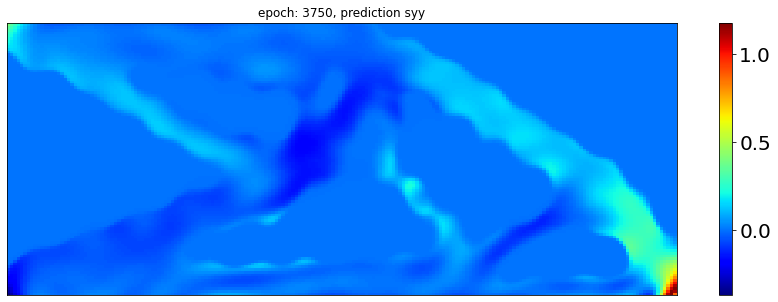

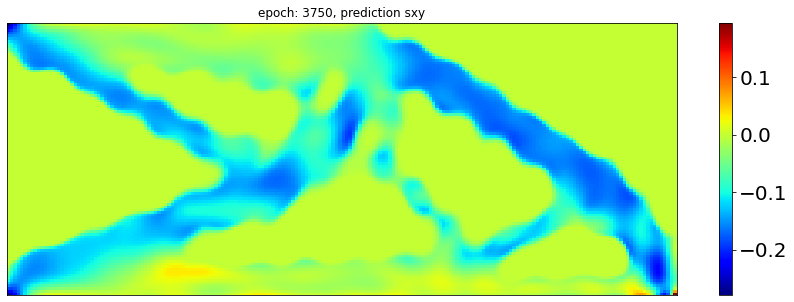

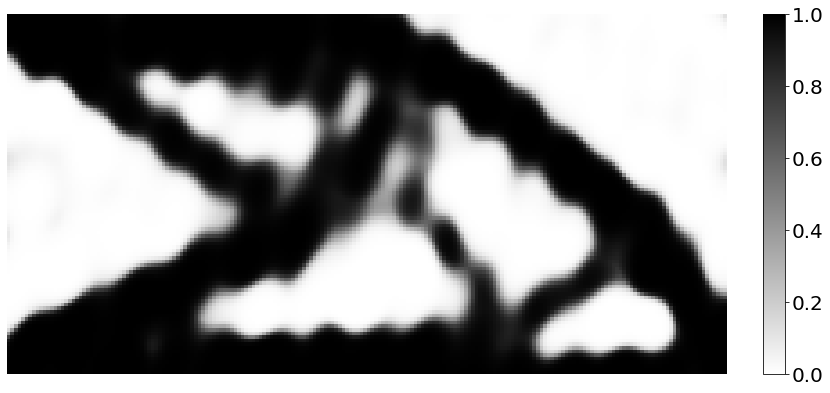

Epoch: 4000/15000, Cost: 0.280567
Et: 5.0469e-02, Eint: 5.0394e-02, Eext and Obj: 1.0086e-01, Vol: 5.0157e-01, Vc: 9.8804e-06
Epoch 4000, Training time: 109.02 seconds
change: 3.4305e-02


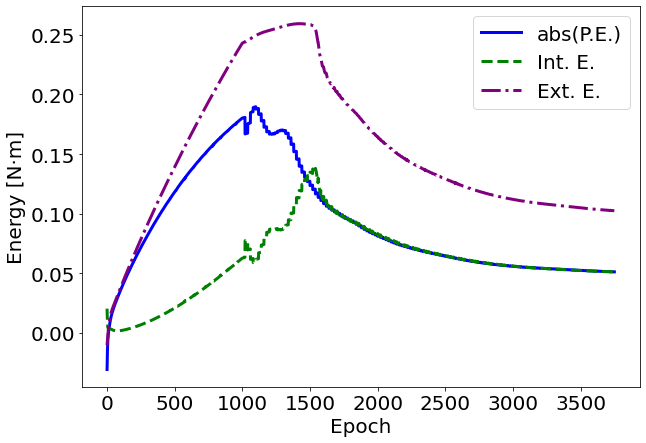

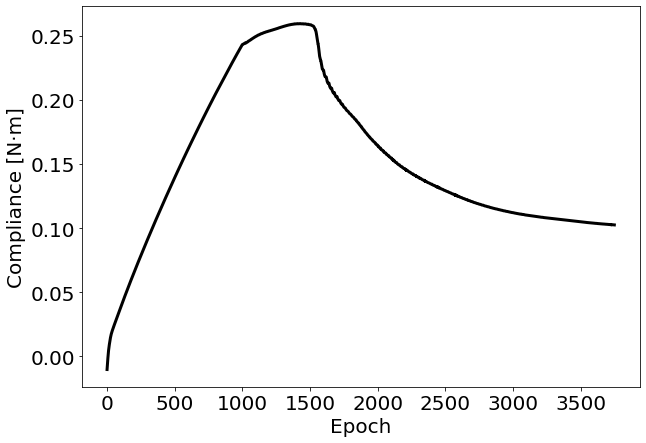

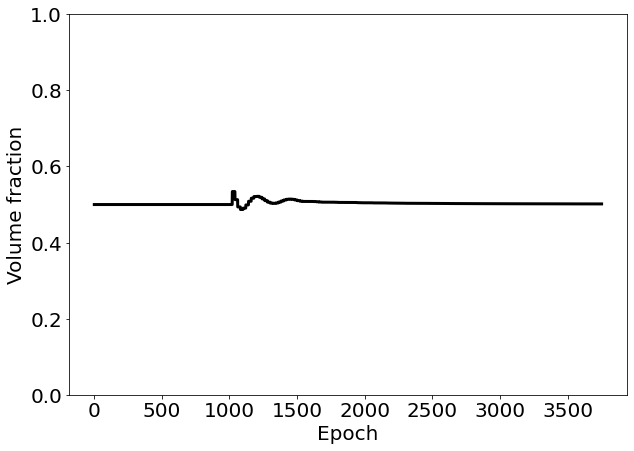

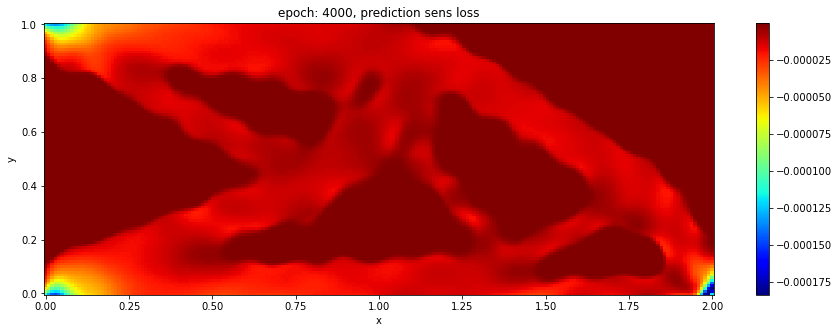

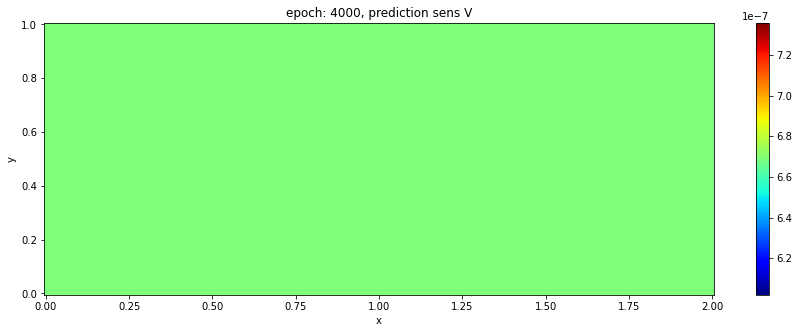

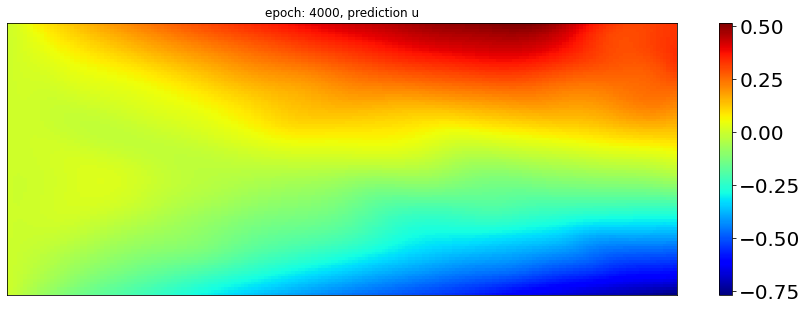

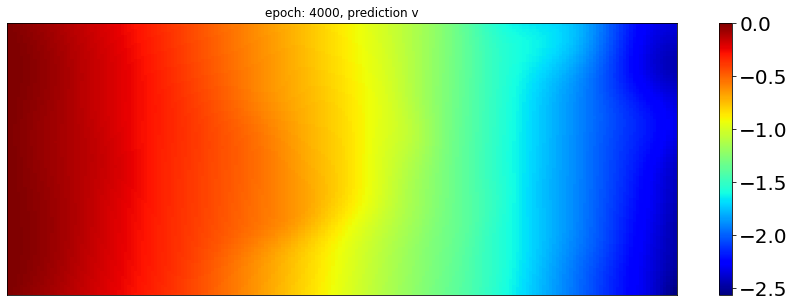

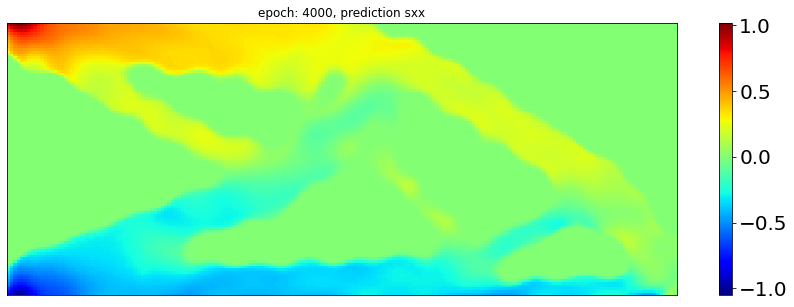

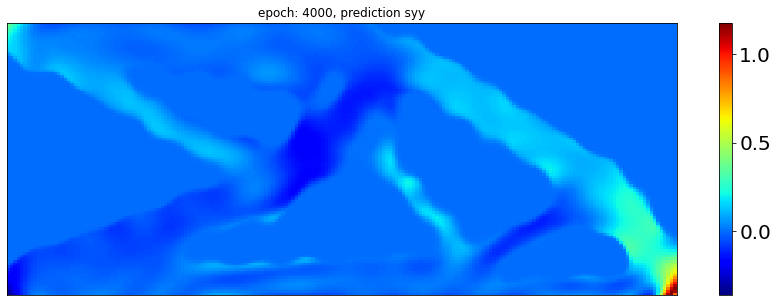

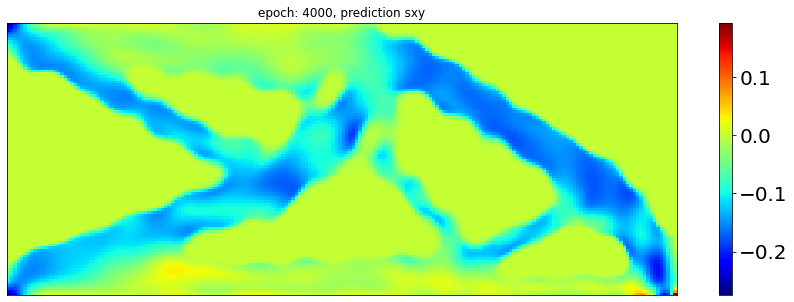

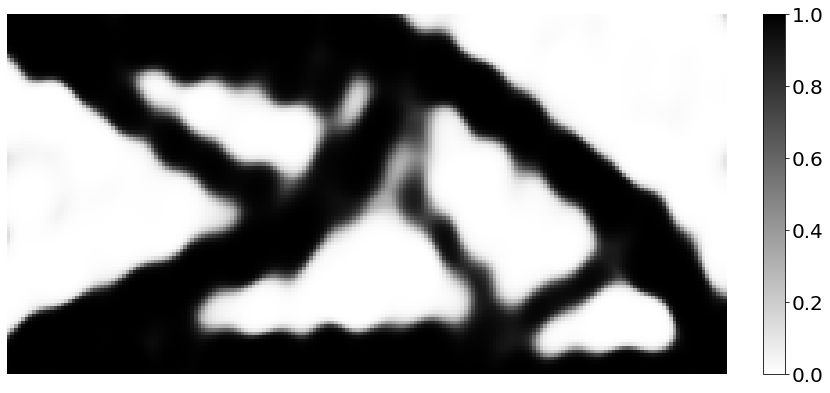

Epoch: 4250/15000, Cost: 0.276623
Et: 4.9765e-02, Eint: 4.9763e-02, Eext and Obj: 9.9528e-02, Vol: 5.0151e-01, Vc: 9.1279e-06
Epoch 4250, Training time: 116.53 seconds
change: 3.5713e-02


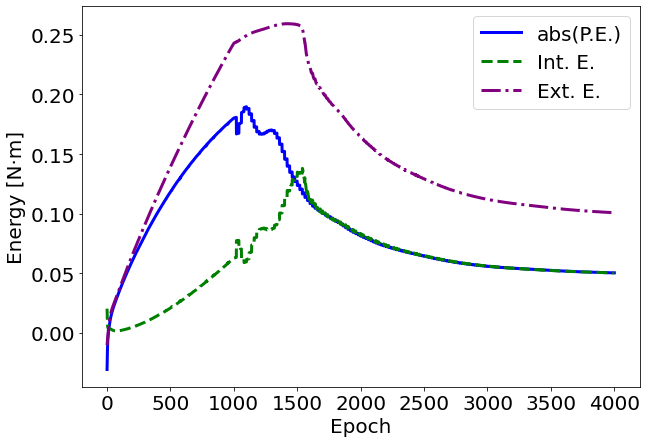

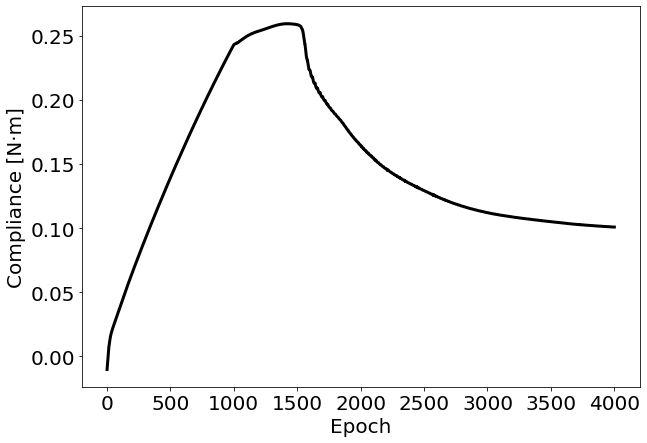

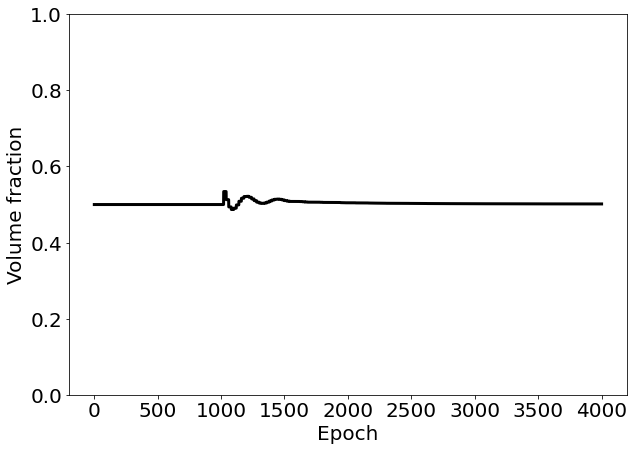

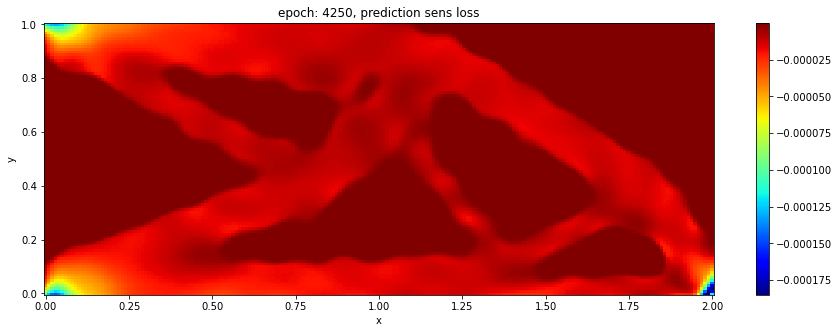

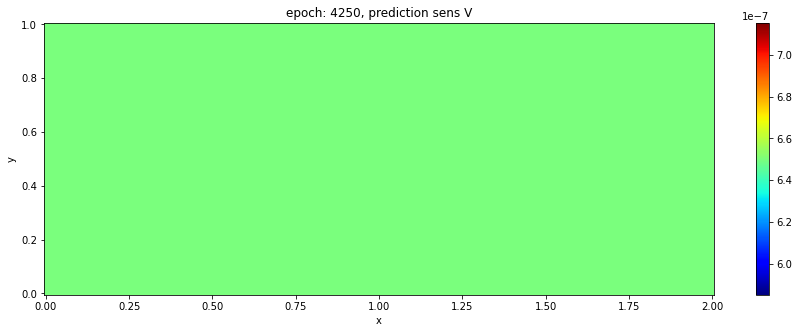

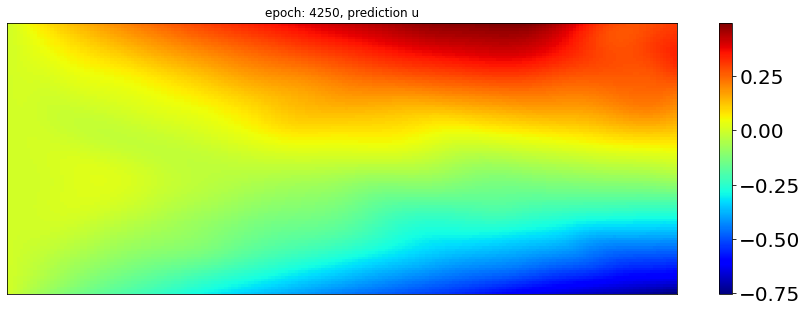

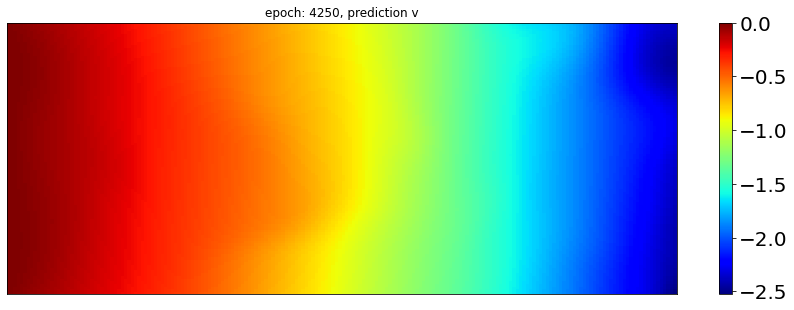

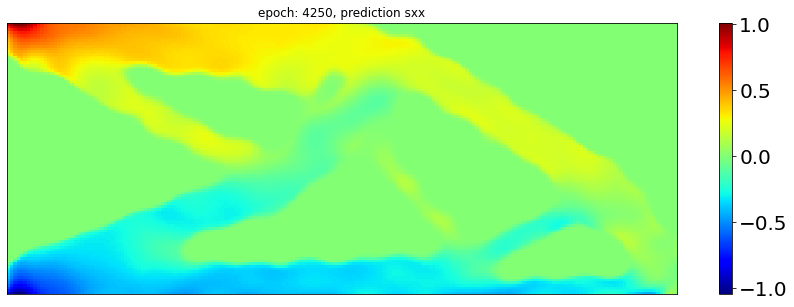

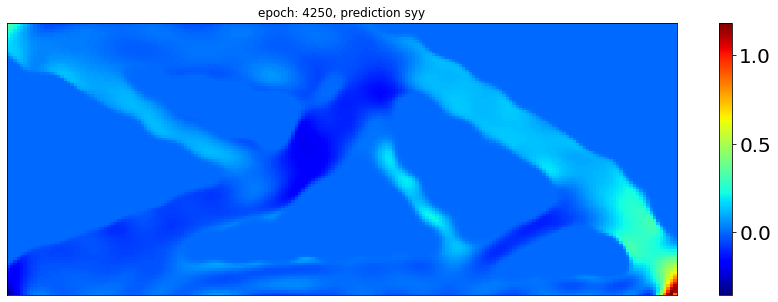

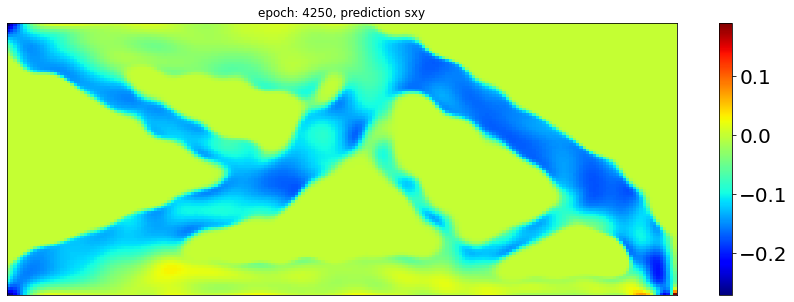

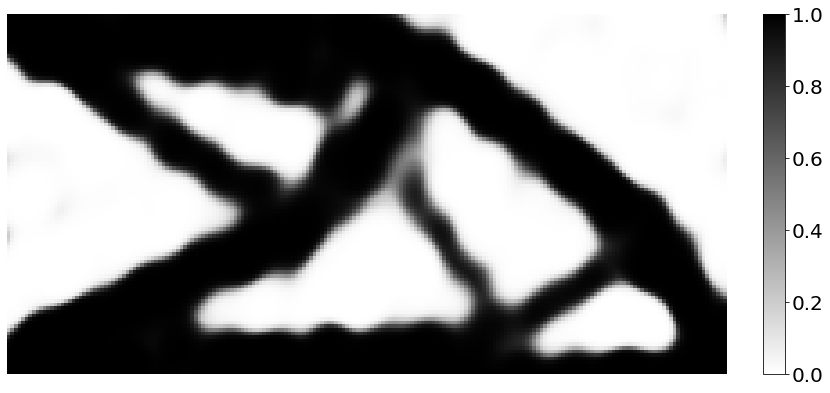

Epoch: 4500/15000, Cost: 0.274044
Et: 4.9306e-02, Eint: 4.9270e-02, Eext and Obj: 9.8576e-02, Vol: 5.0146e-01, Vc: 8.5600e-06
Epoch 4500, Training time: 124.50 seconds
change: 3.5915e-02


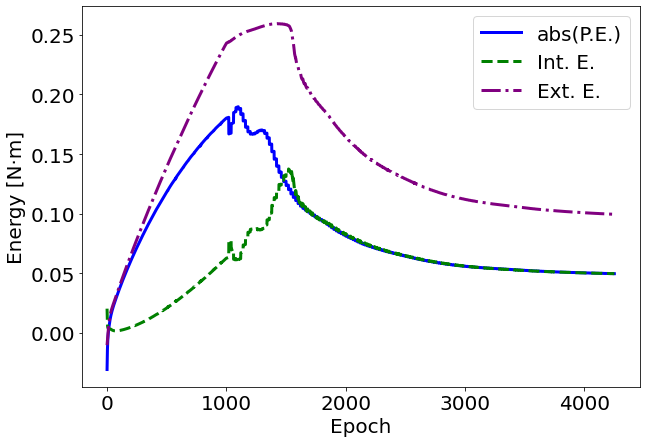

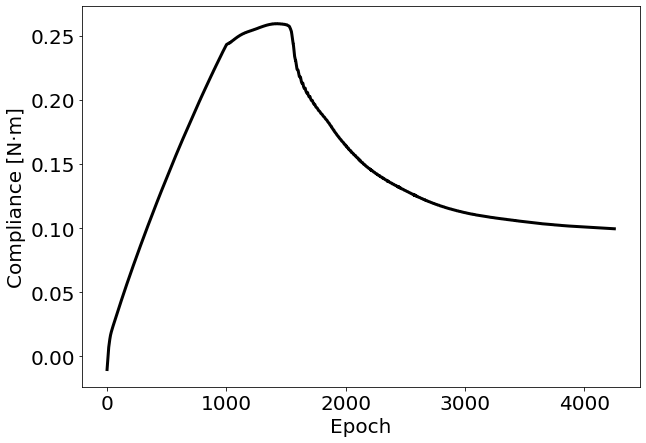

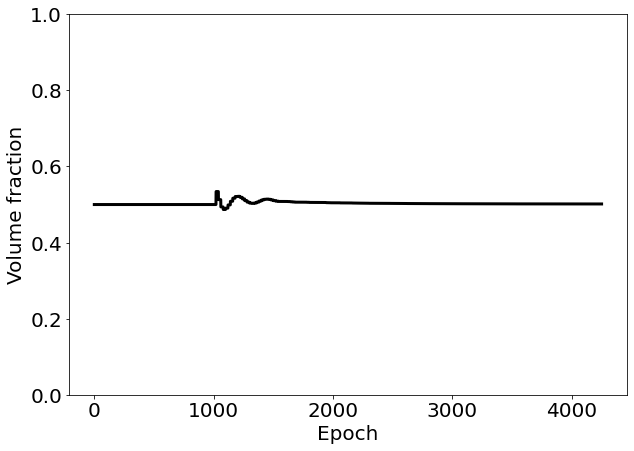

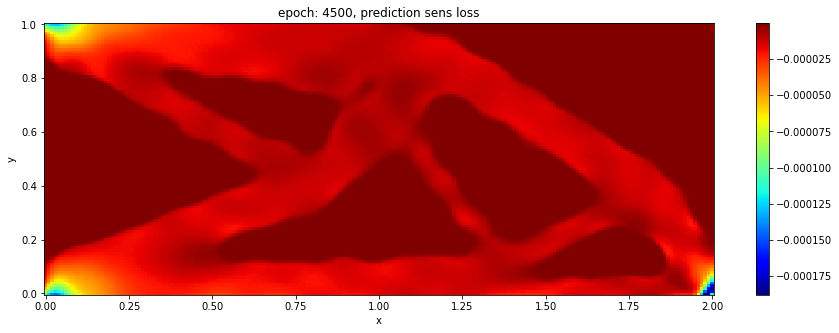

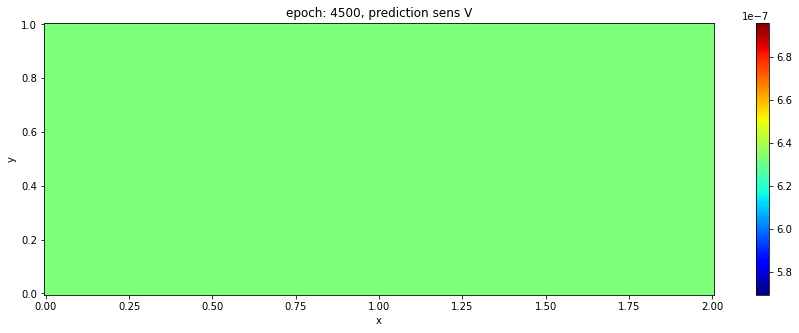

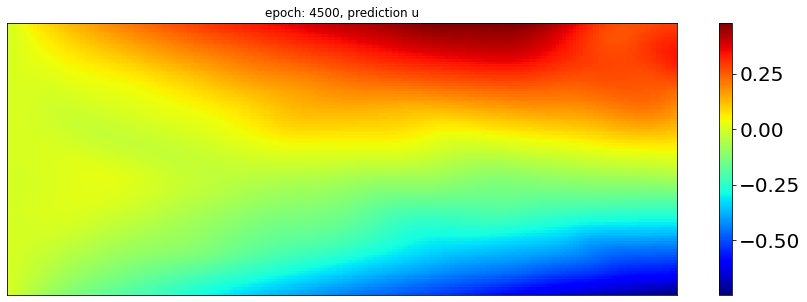

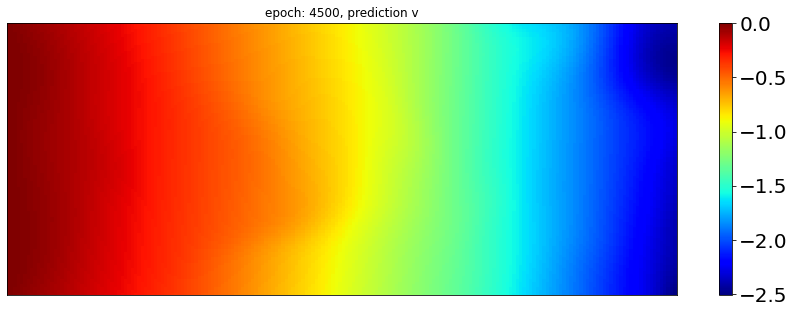

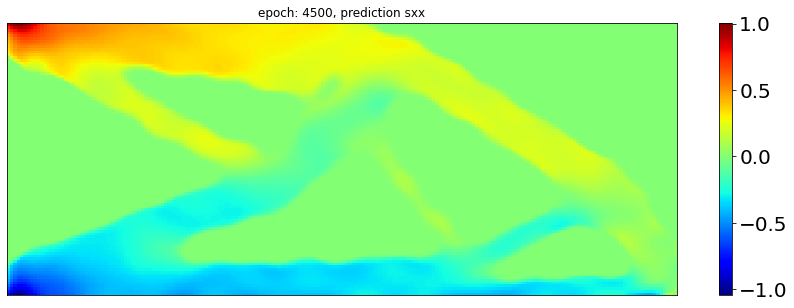

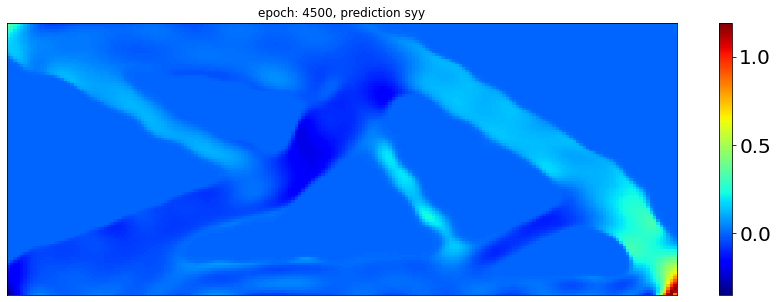

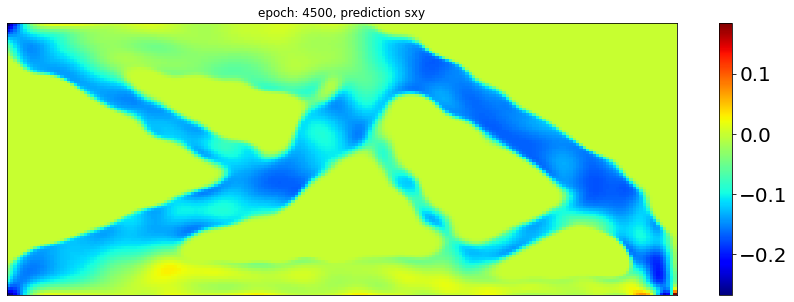

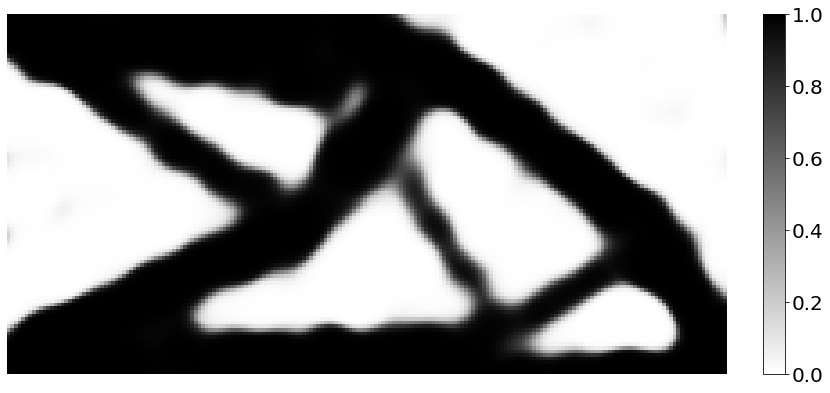

Epoch: 4750/15000, Cost: 0.271957
Et: 4.8934e-02, Eint: 4.8921e-02, Eext and Obj: 9.7855e-02, Vol: 5.0142e-01, Vc: 8.0672e-06
Epoch 4750, Training time: 132.06 seconds
change: 2.3840e-02


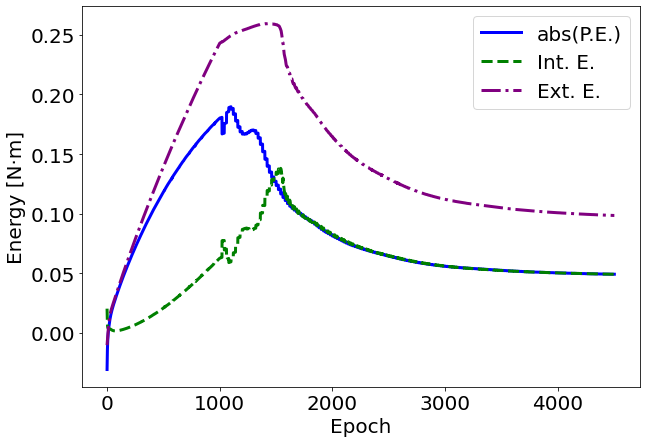

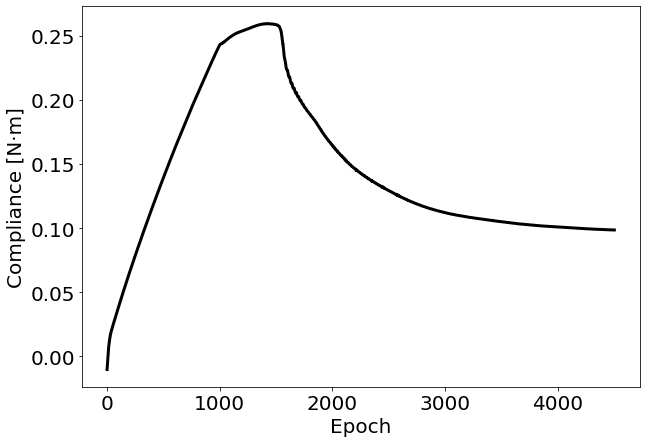

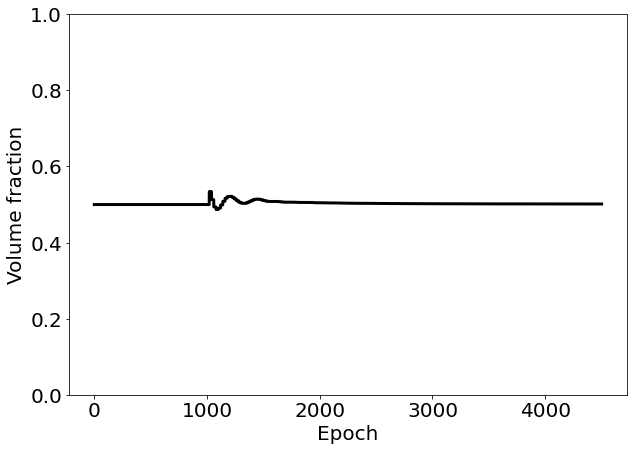

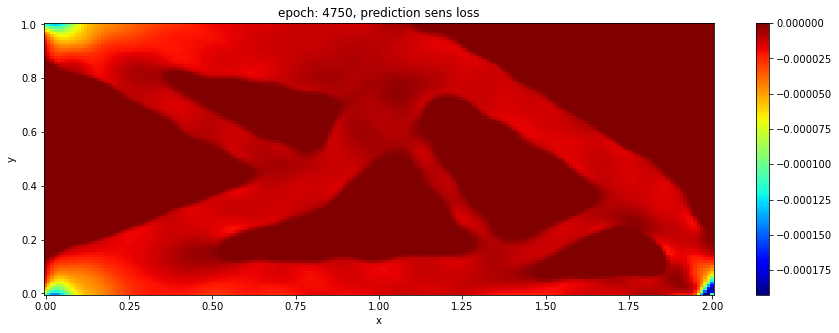

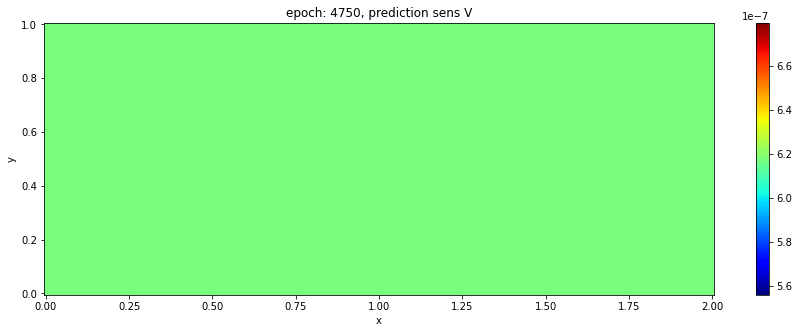

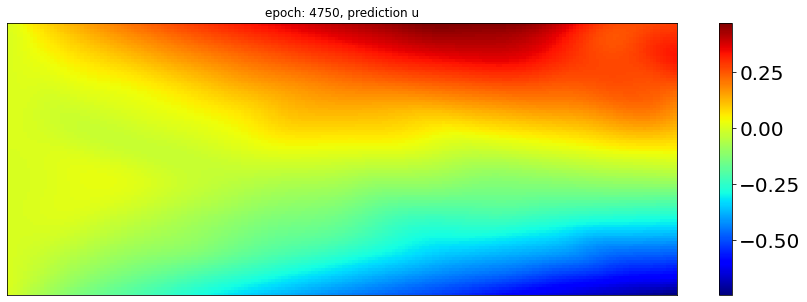

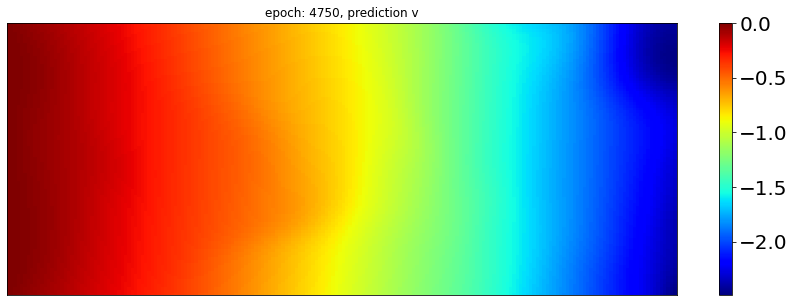

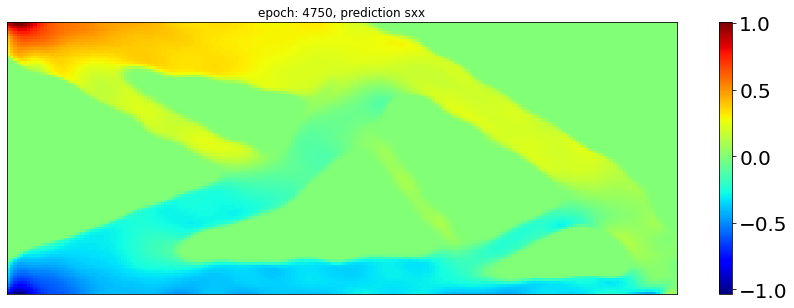

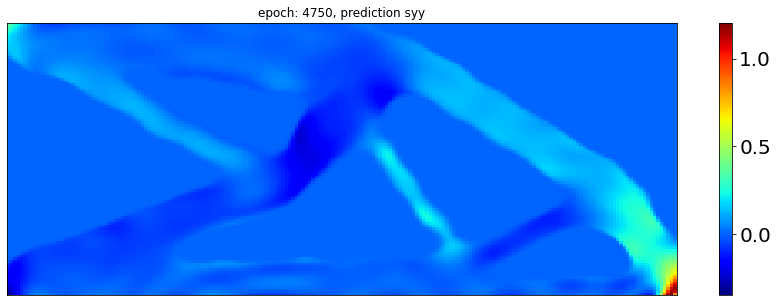

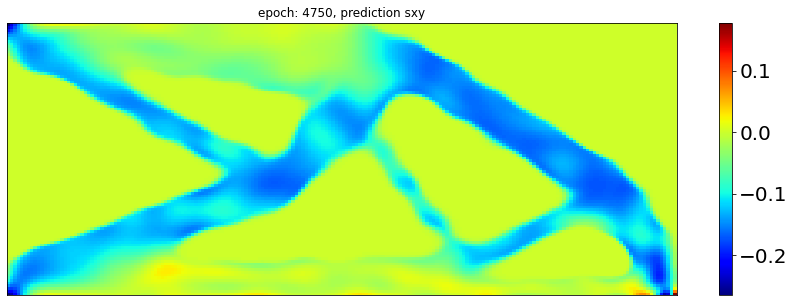

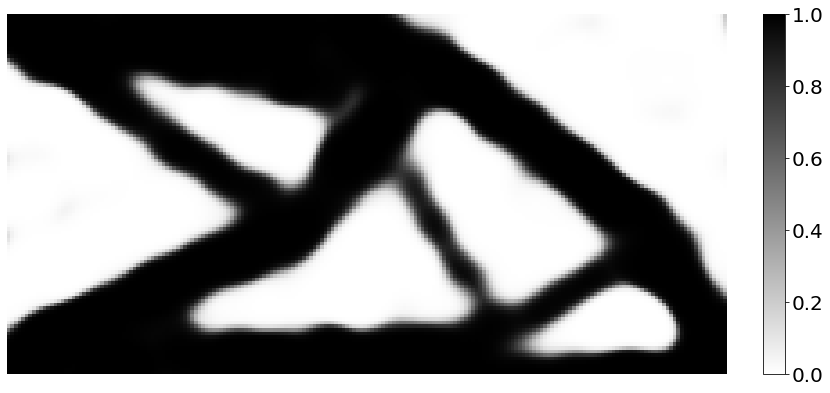

Epoch: 5000/15000, Cost: 0.270480
Et: 4.8669e-02, Eint: 4.8621e-02, Eext and Obj: 9.7290e-02, Vol: 5.0140e-01, Vc: 7.8874e-06
Epoch 5000, Training time: 139.62 seconds
change: 1.8326e-02


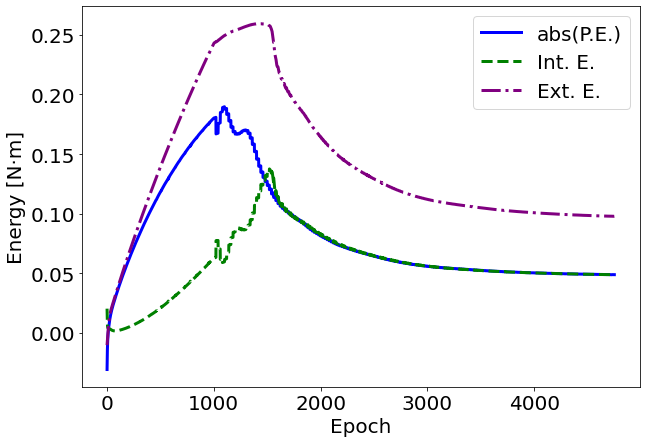

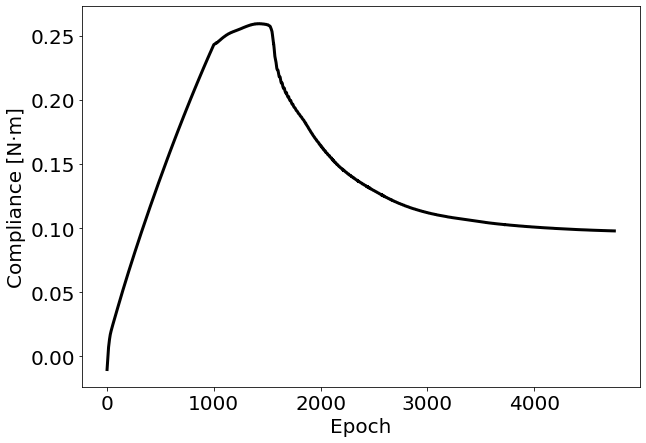

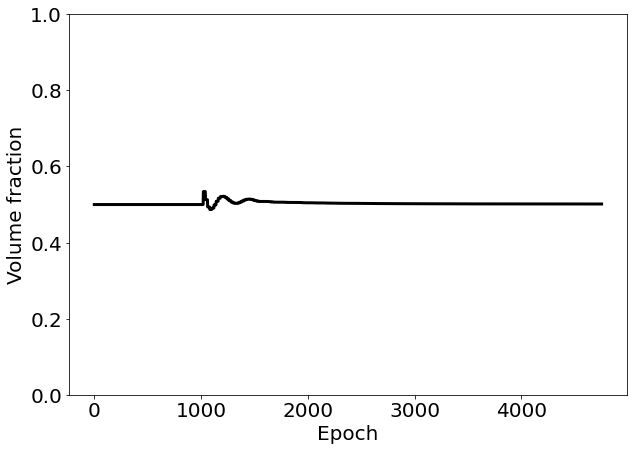

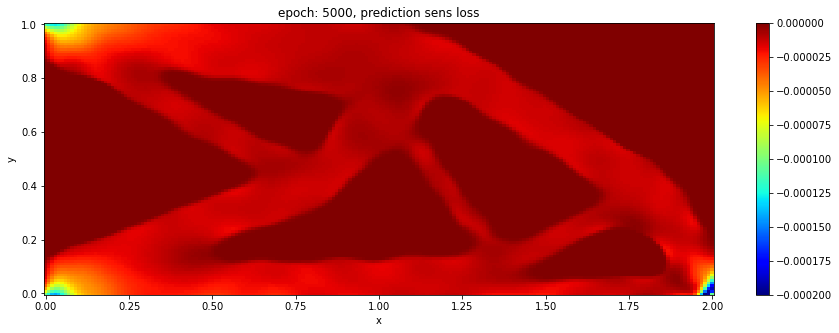

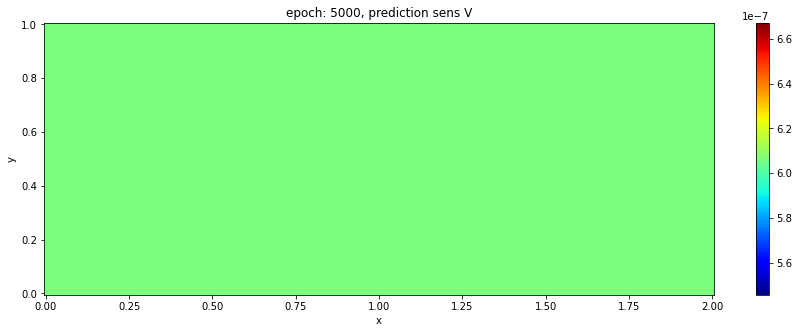

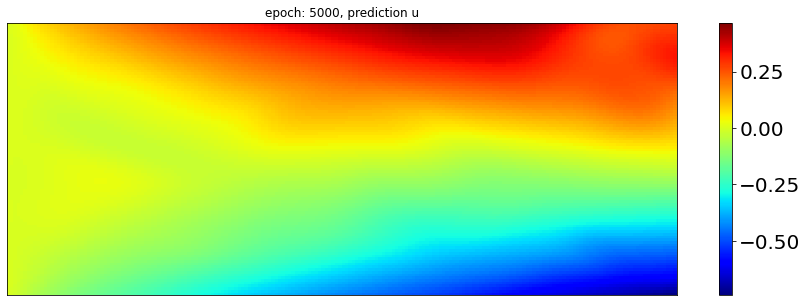

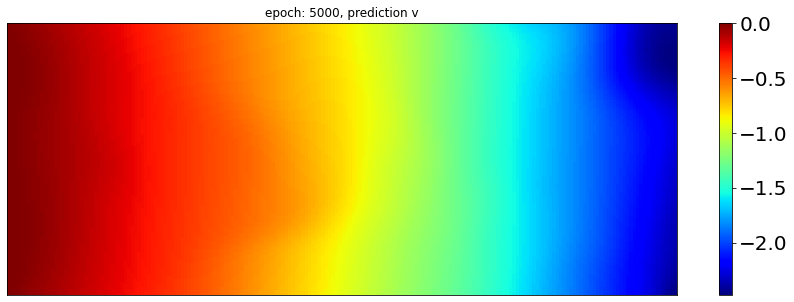

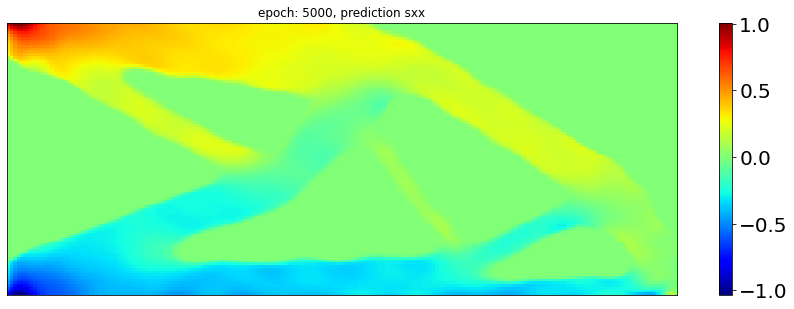

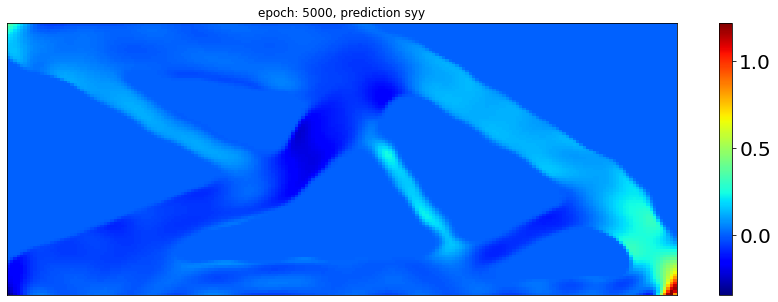

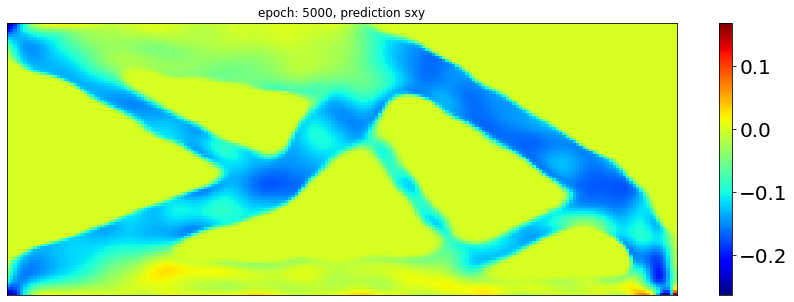

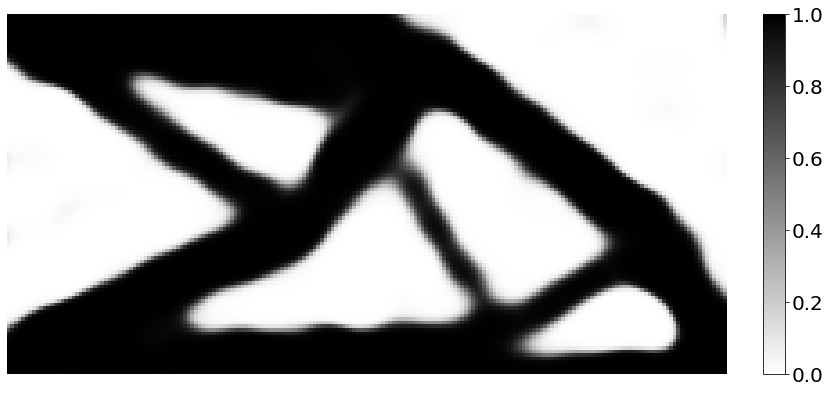

Epoch: 5250/15000, Cost: 0.269163
Et: 4.8434e-02, Eint: 4.8399e-02, Eext and Obj: 9.6833e-02, Vol: 5.0138e-01, Vc: 7.6396e-06
Epoch 5250, Training time: 147.10 seconds
change: 1.7851e-02


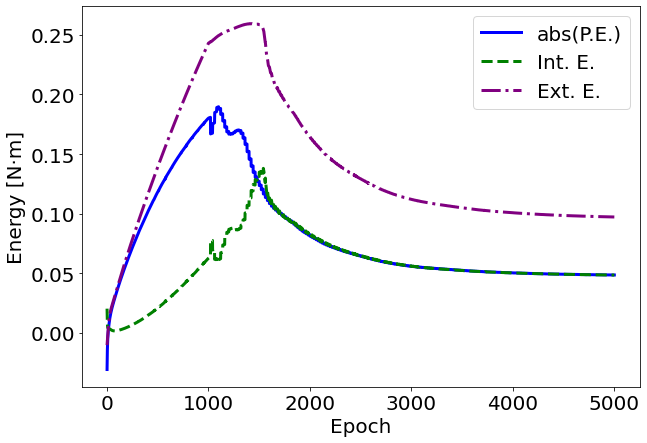

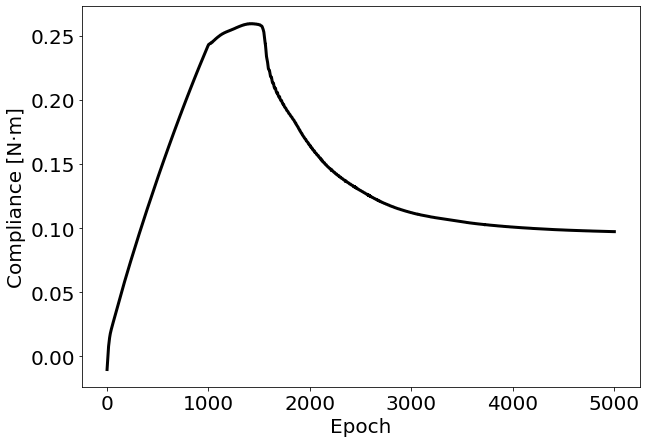

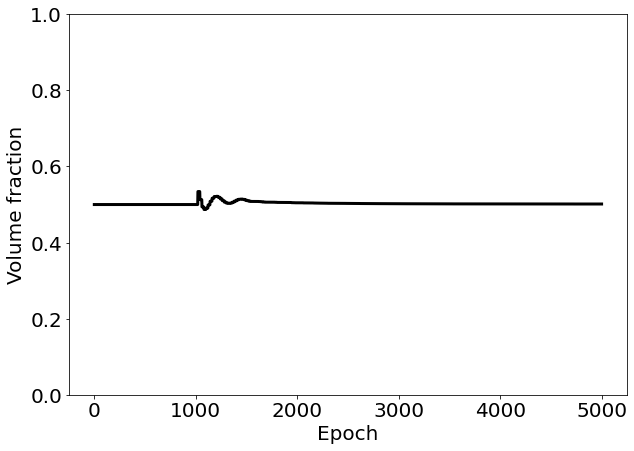

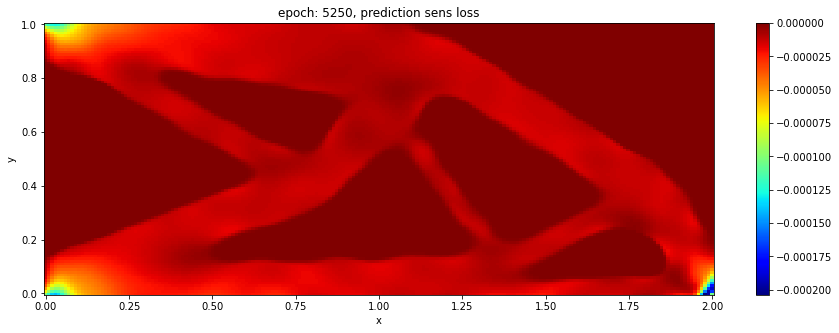

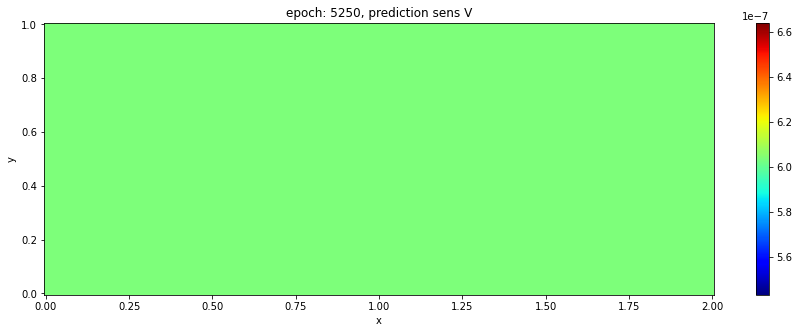

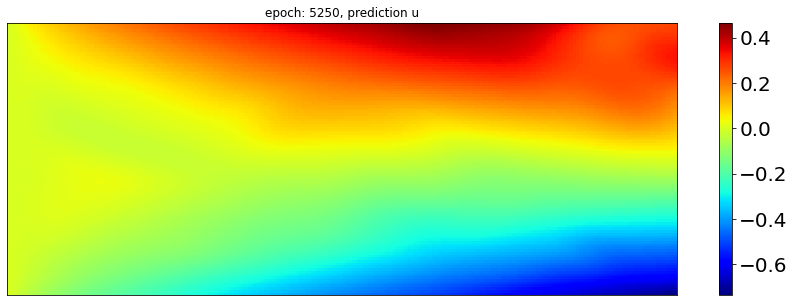

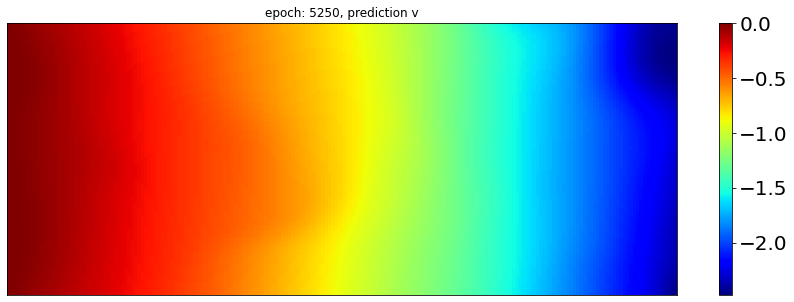

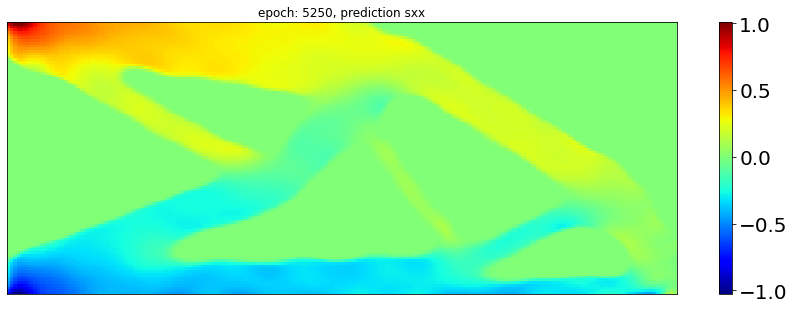

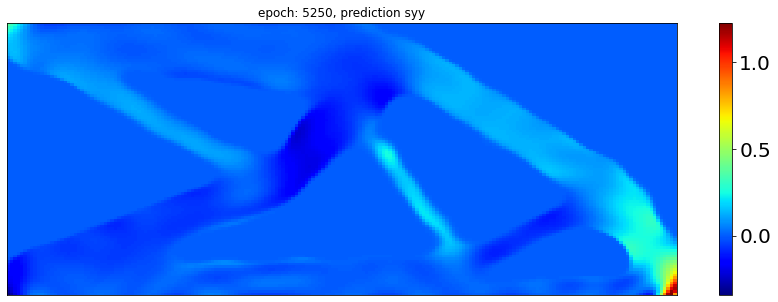

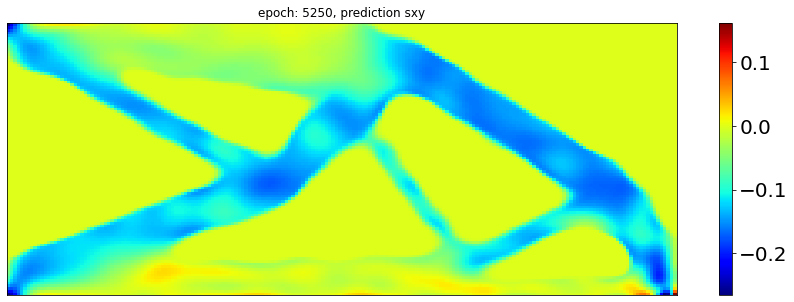

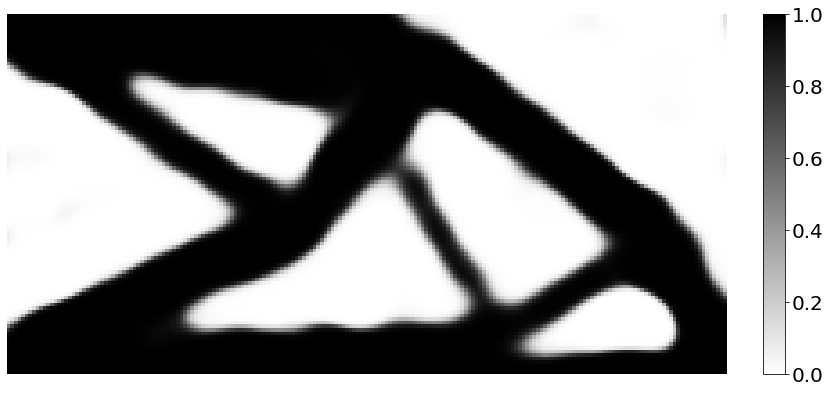

Epoch: 5500/15000, Cost: 0.268198
Et: 4.8263e-02, Eint: 4.8212e-02, Eext and Obj: 9.6475e-02, Vol: 5.0136e-01, Vc: 7.3673e-06
Epoch 5500, Training time: 155.05 seconds
change: 1.4158e-02


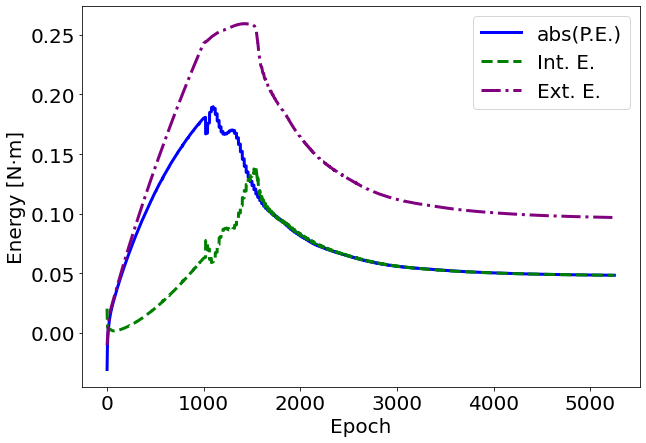

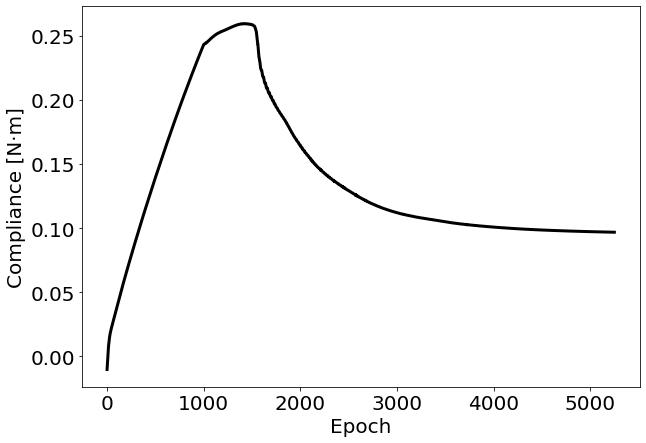

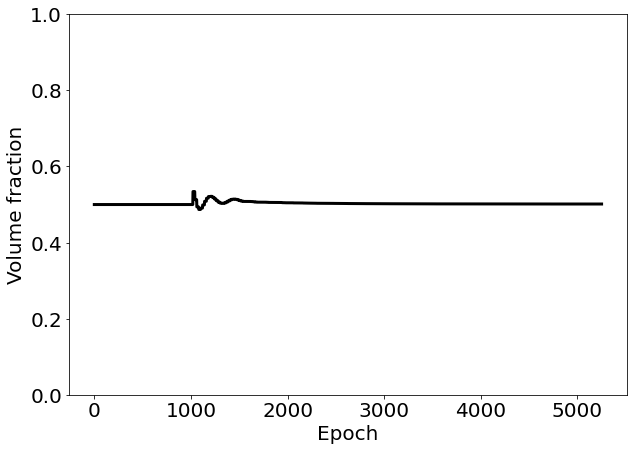

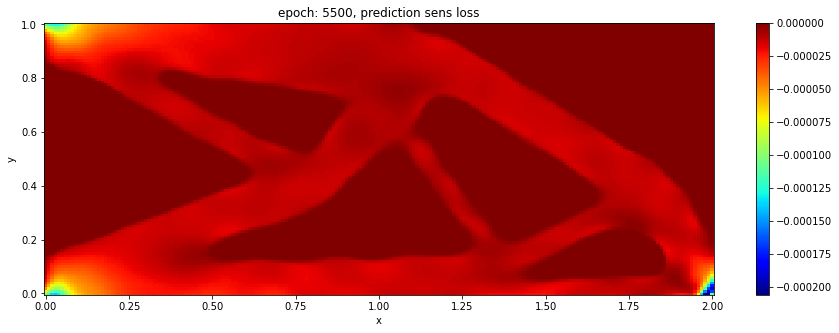

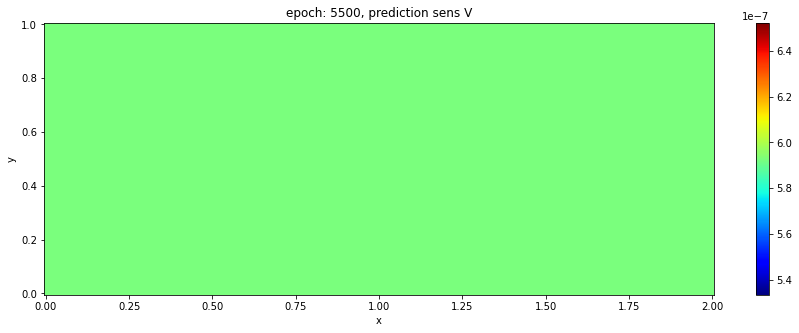

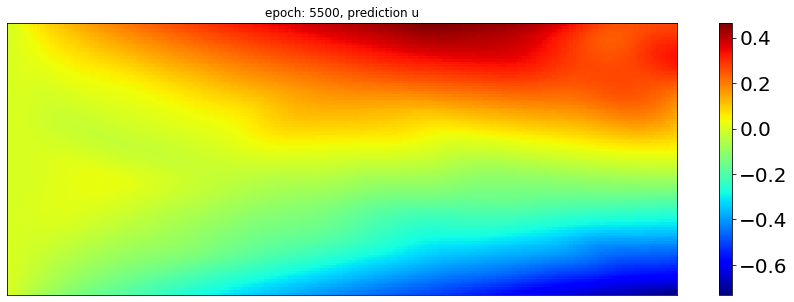

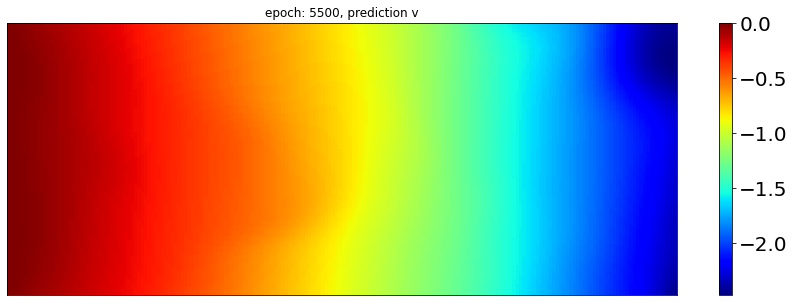

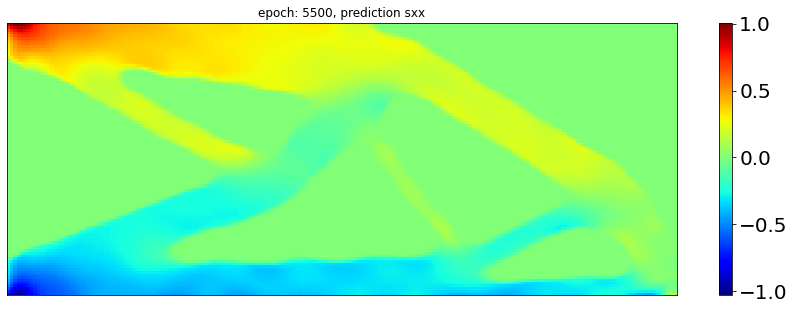

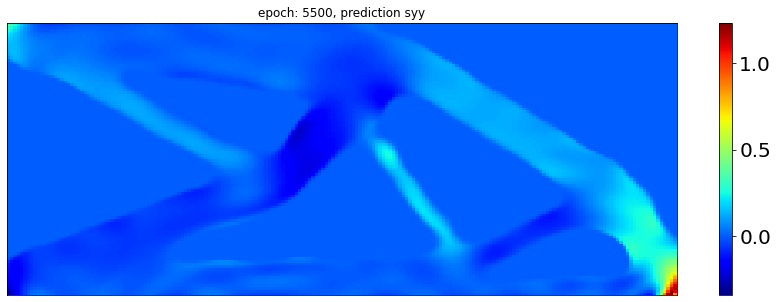

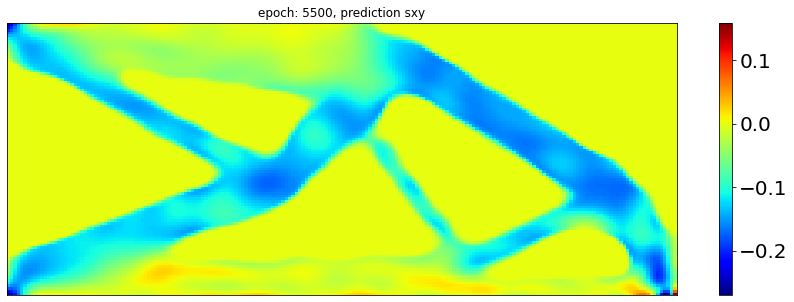

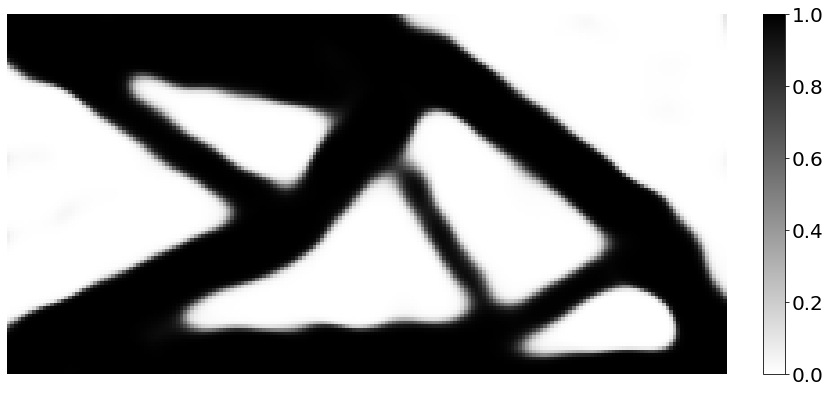

Epoch: 5750/15000, Cost: 0.267306
Et: 4.8104e-02, Eint: 4.8062e-02, Eext and Obj: 9.6165e-02, Vol: 5.0134e-01, Vc: 7.1764e-06
Epoch 5750, Training time: 162.66 seconds
change: 1.1809e-02


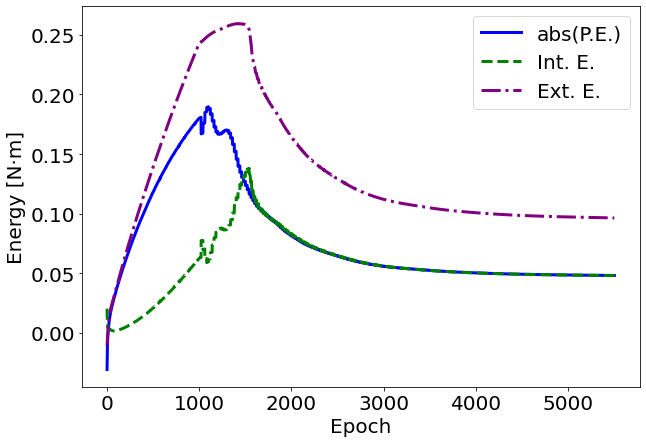

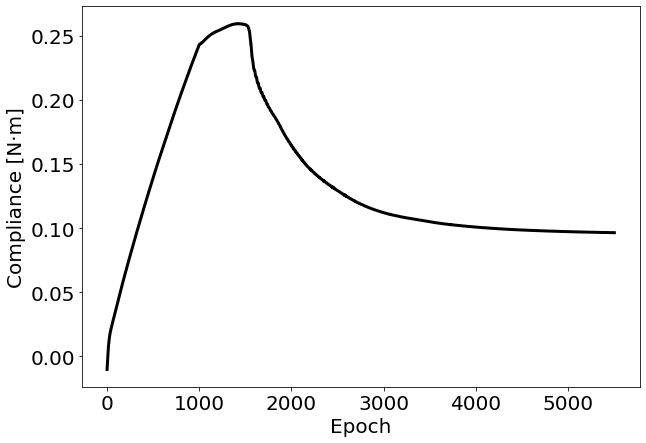

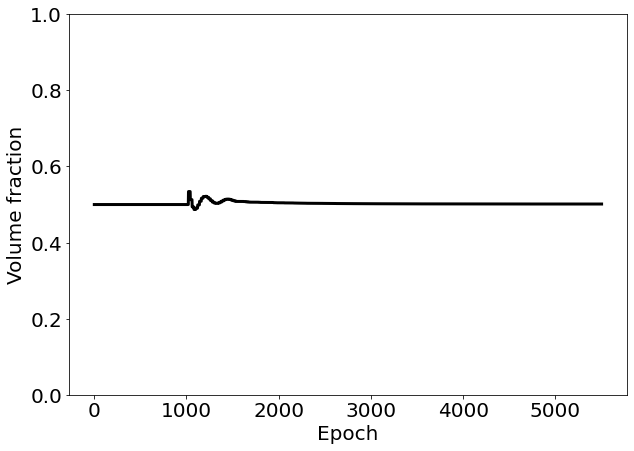

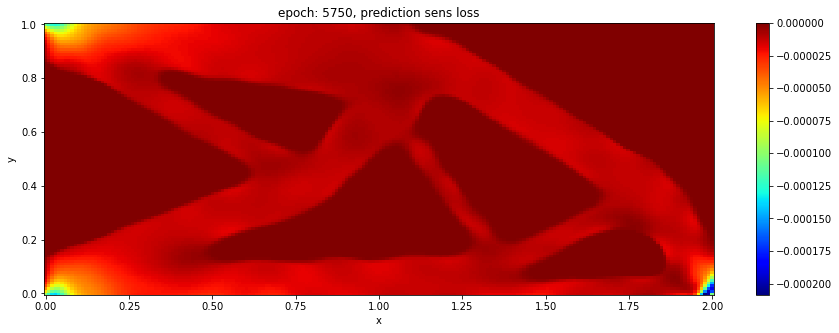

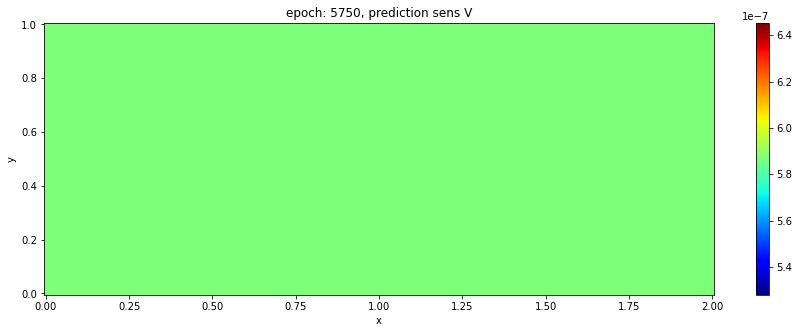

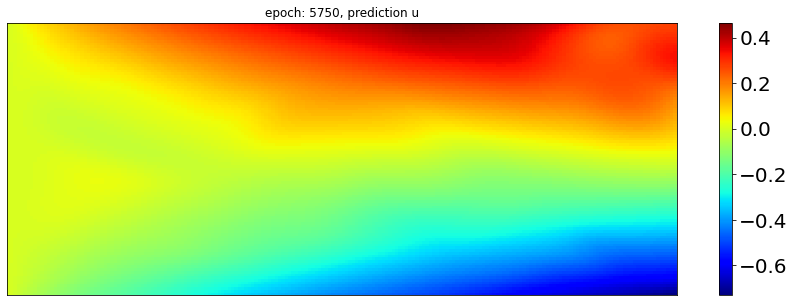

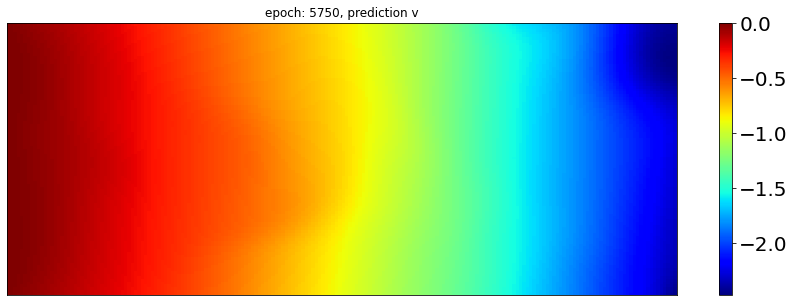

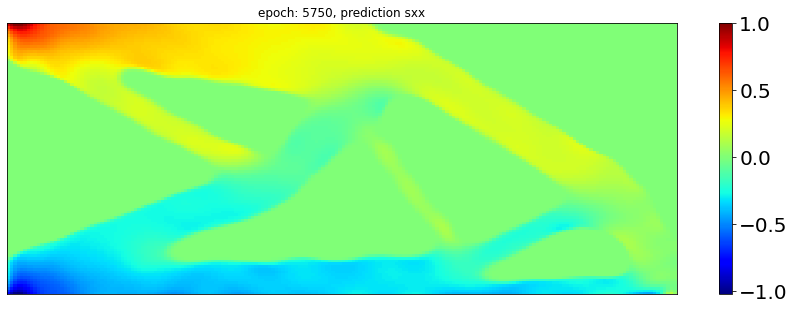

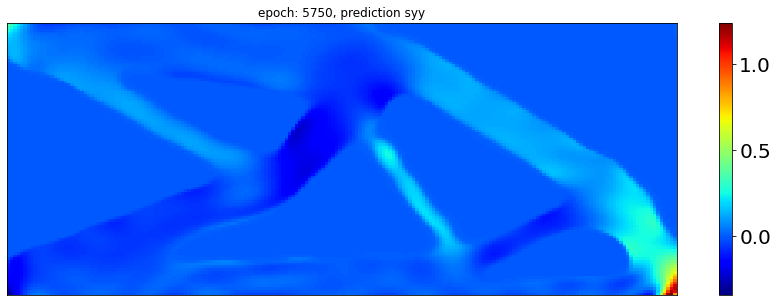

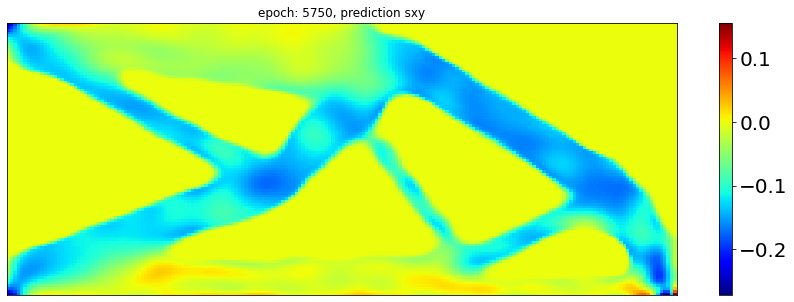

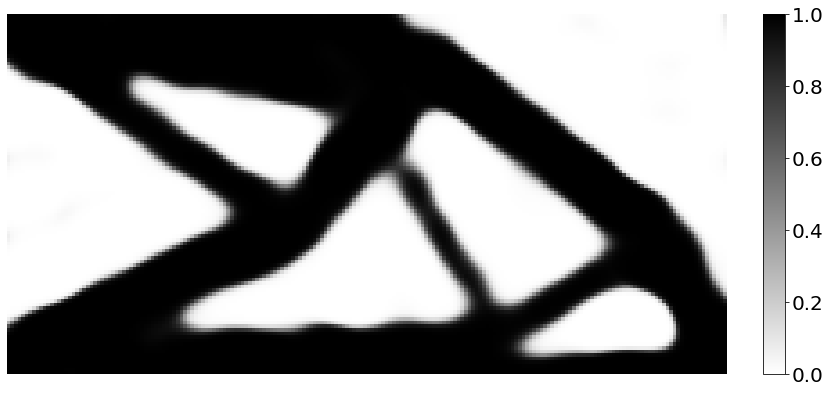

Optimization finishied
Total training time: 168.85 seconds


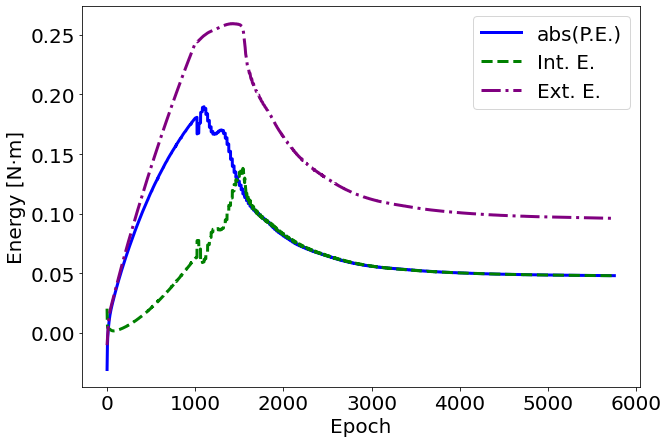

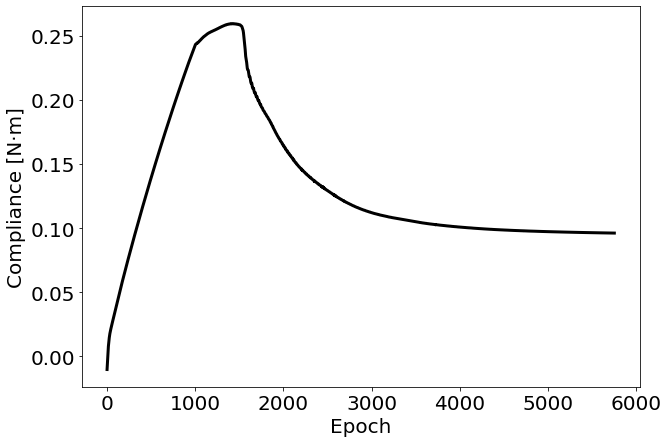

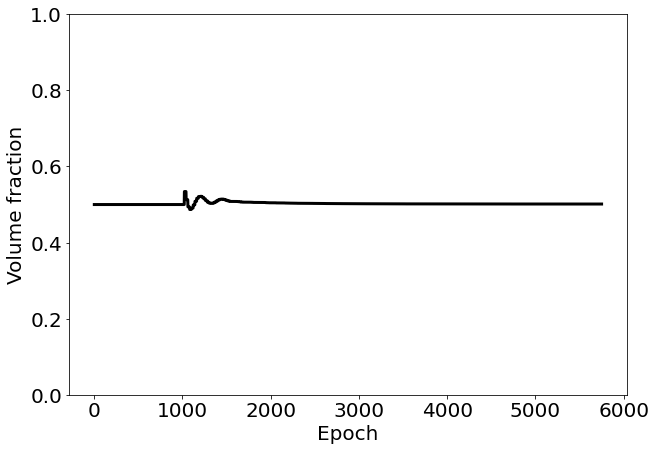

In [14]:
for epoch in range(1,num_epochs_total+1):

    optimizerU.zero_grad()
    optimizerRho.zero_grad()

    # Internal and Vol
    Eint, Vol, rho = pinnLoss(xi, yi)

    # Cantilever With Right Bottom Load
    xLoad = xpBL.view(-1,1)
    yLoad = ypBL.view(-1,1)
    uLoad = 0 + xLoad * net_u(xLoad,yLoad)
    vLoad = 0 + xLoad * net_v(xLoad,yLoad)

    # External energy
    Eext = torch.sum(f*vLoad) * ( lineload/ xLoad.shape[0])

    Et = -1*(Eint - Eext)

    Vc = (1-Vol/Vf)**2

    # Loss

    if  (epoch <= num_epochs_initial_disp):

        loss = Et
        loss.backward(retain_graph = True)
        optimizerU.step()

        if epoch == num_epochs_initial_disp:
            c0 = Et.item()
            print('**********c0 : {:4f}**********'.format(c0))


    elif  (epoch > num_epochs_initial_disp):

        optimizerU.param_groups[0]['lr'] = 0.00001
        
        # Loss
        loss = Et/c0 + 50*Vc
        
        if (epoch%20) == 0:

            oldrho = rho.clone().detach()

            loss.backward(retain_graph = True)
            #torch.nn.utils.clip_grad_norm_(net_rho.parameters(),0.01) # Gradient clipping

            optimizerRho.step()

            _,_,rho = pinnLoss(xi, yi)
            newrho = rho.clone().detach()
            change = max(abs(newrho-oldrho)).item()
            if (change < 0.01) and (epoch > 2000):
                print("Optimization finishied")
                break
    
            if epoch == 1:
                print("**********Update Rho**********")
                
        else:
            loss.backward(retain_graph = True)
            optimizerU.step()
        '''
        if (epoch%250) == 0:
            optimizerU.param_groups[0]['lr'] = max(optimizerU.param_groups[0]['lr'] * 0.9 ,  lrU*0.1)
            print(optimizerU.param_groups[0]['lr'])'''

    end_time = time.time()
    epoch_time = end_time - start_time
    
    item_loss = np.array([epoch, loss.item()])
    history_totalloss = np.vstack((history_totalloss, item_loss))
    history_Et = np.vstack((history_Et, np.array([epoch, Et.item()])))
    history_Eint = np.vstack((history_Eint, np.array([epoch, Eint.item()])))
    history_Eext = np.vstack((history_Eext, np.array([epoch, Eext.item()])))
    history_Vol = np.vstack((history_Vol, np.array([epoch, Vol.item()])))
    history_Vc = np.vstack((history_Vc, np.array([epoch, Vc.item()])))
    history_p = np.vstack((history_p, np.array([epoch, p])))


    if ((epoch) == 1):
        print('Epoch: {:4d}/{}, Cost: {:6f}'.format(epoch, num_epochs_total, loss.item()))
        print(f'Et: {Et:.4e}, Eint: {Eint:.4e}, Eext and Obj: {Eext:.4e}, Vol: {Vol:.4e}, Vc: {Vc:.4e}')
        print(f'Epoch {epoch}, Training time: {epoch_time:.2f} seconds')
        print(f'change: {change:.4e}')
        
    if ((epoch) % 250) == 0:
        print('Epoch: {:4d}/{}, Cost: {:6f}'.format(epoch, num_epochs_total, loss.item()))
        print(f'Et: {Et:.4e}, Eint: {Eint:.4e}, Eext and Obj: {Eext:.4e}, Vol: {Vol:.4e}, Vc: {Vc:.4e}')
        print(f'Epoch {epoch}, Training time: {epoch_time:.2f} seconds')
        print(f'change: {change:.4e}')
        
        drawplot(mse, epoch)

end_time_total = time.time()

total_time = end_time_total - start_time_total

print(f'Total training time: {total_time:.2f} seconds')

torch.save(net_u, f'./net_u.pt')
torch.save(net_v, f'./net_v.pt')
torch.save(net_rho, f'./net_rho.pt')

Eext = np.array(history_Eext)
Eint = np.array(history_Eint)
Et = np.array(history_Et)
Vol = np.array(history_Vol)

np.savetxt('Eext.csv', Eext, delimiter=',')
np.savetxt('Eint.csv', Eint, delimiter=',')
np.savetxt('Et.csv', Et, delimiter=',')
np.savetxt('Vol.csv', Vol, delimiter=',')
